Este notebook contiene la implementación experimental para la tesis de maestría. El objetivo es diseñar y validar un método de trading sistemático para el ETF SPY, comparando diferentes enfoques de modelado basados en Machine Learning contra un benchmark de Buy & Hold.

## 1. Configuración del entorno y carga de datos
En esta primera sección, se importan todas las librerías necesarias para el análisis y se cargan los datos históricos del SPDR S&P 500 ETF (SPY).

In [ ]:
# Instalar librerías
!pip install mplfinance

In [ ]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
# Configuración de parámetros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')
pd.options.mode.chained_assignment = None

# En producción eliminar, se incluye por información
print(f'Pandas Version: {pd.__version__}')

Pandas Version: 2.2.2


In [ ]:
np.set_printoptions(suppress=True)

# En produccióon eliminar, se incluye por información
print(f'Numpy version: {np.__version__}')

Numpy version: 2.0.2


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# Para pandas: todos los floats en decimales normales, hasta 6 cifras decimales
pd.set_option('display.float_format', '{:.6f}'.format)

# Para numpy: print de arrays sin notación científica
np.set_printoptions(suppress=True, precision=6)

In [ ]:
# Definir Parámetros
ticker = "SPY"
inicio = "1993-01-29"
final = "2025-06-30"

In [ ]:
# Descargar datos diarios
df = yf.download(tickers=ticker, start=inicio, end=final, interval="1d", multi_level_index=False)
print(df.head())
print(df.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open   Volume
Date                                                       
1993-01-29 24.380445 24.397786 24.276404 24.397786  1003200
1993-02-01 24.553843 24.553843 24.397780 24.397780   480500
1993-02-02 24.605860 24.623200 24.484478 24.536499   201300
1993-02-03 24.865965 24.883305 24.623201 24.640541   529400
1993-02-04 24.970003 25.022024 24.675218 24.952663   531500
                Close       High        Low       Open    Volume
Date                                                            
2025-06-23 600.150024 600.539978 591.890015 595.039978  87426000
2025-06-24 606.780029 607.849976 603.409973 604.330017  67735300
2025-06-25 607.119995 608.609985 605.539978 607.909973  62114800
2025-06-26 611.869995 612.309998 608.369995 608.989990  78548400
2025-06-27 614.909973 616.390015 610.830017 612.880005  86258400


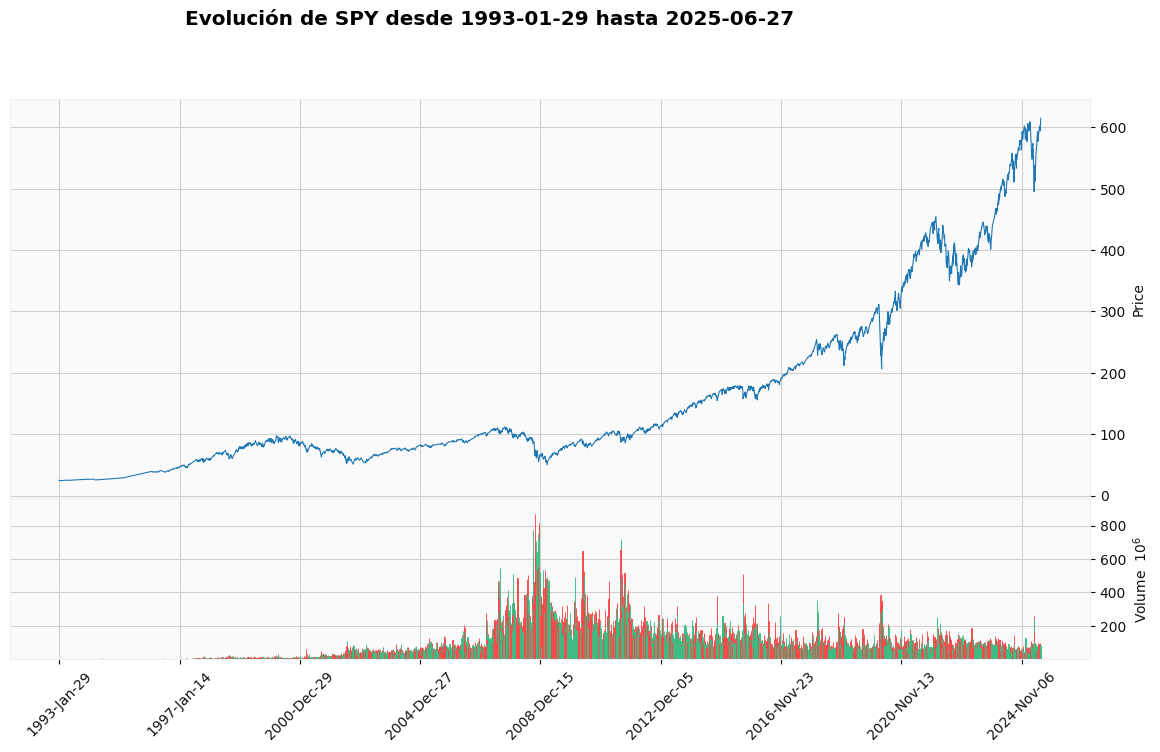

In [ ]:
# Graficar la evolución del SPY

mpf.plot(df, type="line", style="yahoo", volume=True, figsize=(15,8), figscale=2.0, title=f"Evolución de {ticker} desde {df.index[0].date()} hasta {df.index[-1].date()}")
plt.show()

In [ ]:
# Agregar el ATR(20) al dataframe

# Paso 1: desplazamos el Close para obtener el Close del día anterior
df['Prev_Close'] = df['Close'].shift(1)

# Paso 2: calculamos las tres componentes del True Range (TR)
df['TR1'] = df['High'] - df['Low']
df['TR2'] = (df['High'] - df['Prev_Close']).abs()
df['TR3'] = (df['Low']  - df['Prev_Close']).abs()

# Paso 3: el True Range es el máximo de esas tres series
df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

# Paso 4: calculamos el ATR(20) como media móvil simple de 20 periodos de TR
df['ATR20'] = df['TR'].rolling(window=20, min_periods=20).mean()

# Paso 5 (opcional): limpiar columnas auxiliares
df.drop(columns=['Prev_Close', 'TR1', 'TR2', 'TR3', 'TR'], inplace=True)

# Eliminar las filas NaN
df.dropna(inplace=True)

# Ahora df incluye la columna 'ATR20'
df.tail()

,Close,High,Low,Open,Volume,ATR20
Date,,,,,,
2025-06-23,600.150024,600.539978,591.890015,595.039978,87426000,6.538930
2025-06-24,606.780029,607.849976,603.409973,604.330017,67735300,6.550528
2025-06-25,607.119995,608.609985,605.539978,607.909973,62114800,6.061927
2025-06-26,611.869995,612.309998,608.369995,608.989990,78548400,6.033277
2025-06-27,614.909973,616.390015,610.830017,612.880005,86258400,5.955828


ATR (Average True Range): Es una medida de volatilidad que promedia el rango real de movimiento de precios en un período determinado.

# 2. Análisis exploratorio de datos

In [ ]:
# Tasa de Crecimiento Anual Compuesta (CAGR)

# Precio inicial y precio final
precio_inicial = df['Close'].iloc[0]
precio_final = df['Close'].iloc[-1]

# Cálculo del número de años transcurridos
dias = (df.index[-1] - df.index[0]).days
años = dias / 365.25

# Fórmula del CAGR
cagr = (precio_final / precio_inicial)**(1/años) - 1

# Resultado
print(f"CAGR del SPY entre {df.index[0].date()} y {df.index[-1].date()}: {cagr:.2%}")

CAGR del SPY entre 1993-02-26 y 2025-06-27: 10.46%


CAGR (Compound Annual Growth Rate - Tasa de Crecimiento Anual Compuesta): Representa la tasa constante a la que una inversión habría crecido si los beneficios se hubieran reinvertido anualmente.

In [ ]:
# Volatilidad

# Calcular retornos diarios simples
df['Retorno_diario'] = df['Close'].pct_change()

# Eliminar la primera fila con NaN en Retorno_diario
df_ret = df.dropna(subset=['Retorno_diario'])

# Volatilidad diaria: desviación estándar de los retornos diarios
volatilidad_diaria = df_ret['Retorno_diario'].std()

# Volatilidad anualizada (√252 días hábiles)
volatilidad_anual = volatilidad_diaria * np.sqrt(252)

print(f"Volatilidad diaria: {volatilidad_diaria:.2%}")
print(f"Volatilidad anualizada: {volatilidad_anual:.2%}")

# Borrar la columna Retorno_diario
df.drop(columns=['Retorno_diario'], inplace=True)

Volatilidad diaria: 1.18%
Volatilidad anualizada: 18.74%


Volatilidad Anualizada: Mide la dispersión de los rendimientos del activo, un proxy del riesgo.

In [ ]:
# Definimos la tasa libre de riesgo anual (asumimos un 0,00 %)
tasa_anual = 0.00

# Convertir a tasa diaria equivalente
tasa_diaria = (1 + tasa_anual) ** (1/252) - 1

# Calcular los retornos diarios y eliminar el primer NaN
retornos = df['Close'].pct_change().dropna()

# Exceso de retornos sobre la tasa libre de riesgo
retornos_exceso = retornos - tasa_diaria


# Coeficiente de Sharpe

sharpe = (retornos_exceso.mean() / retornos_exceso.std()) * np.sqrt(252)
print(f"Coeficiente de Sharpe entre {df.index[0].date()} y {df.index[-1].date()}: {sharpe:.2f}")

Coeficiente de Sharpe entre 1993-02-26 y 2025-06-27: 0.63


Sharpe Ratio: Evalúa el rendimiento ajustado por riesgo, indicando cuánto retorno excedente se obtiene por cada unidad de riesgo asumido. Un valor más alto es mejor.

In [ ]:
# Coeficiente de Sortino

retornos_negativos = retornos_exceso[retornos_exceso < 0]
sortino = (retornos_exceso.mean() / retornos_negativos.std()) * np.sqrt(252)
print(f"Coeficiente de Sortino entre {df.index[0].date()} y {df.index[-1].date()}: {sortino:.2f}")

Coeficiente de Sortino entre 1993-02-26 y 2025-06-27: 0.80


Sortino Ratio: Similar al Sharpe, pero solo penaliza la volatilidad de los retornos negativos (las "pérdidas"), siendo más relevante para inversores adversos al riesgo de caídas.

In [ ]:
# Retroceso Máximo

max_drawdown = ((df['Close'].cummax() - df['Close']) / df['Close'].cummax()).max()
print(f"Retroceso Máximo: {max_drawdown:.2%}")

Retroceso Máximo: 55.19%


Maximum Drawdown (MDD - Retroceso Máximo): Cuantifica la peor pérdida porcentual desde un máximo histórico hasta un mínimo posterior.

In [ ]:
# Cálculo del Calmar Ratio

calmar = cagr / max_drawdown
print(f"Calmar Ratio: {calmar:.2f}")

Calmar Ratio: 0.19


Calmar Ratio: Relaciona la CAGR con el MDD, evaluando la rentabilidad por unidad de riesgo de pérdida extrema.

# 3. Ingeniería de características

## Creación de eventos informativos

In [ ]:
# Parámetros
TP_SL_MULT  = 2.0  # multiplicador para TP y SL (2×ATR20)
UMBRAL_MULT = 2.0  # threshold = ATR20 * UMBRAL_MULT

# Asumimos que `df` ya contiene las columnas:
# 'Open', 'High', 'Low', 'Close', 'Volume', 'ATR20' (sin NaN en ATR20)

barras_info = []

# 1) Evento inicial (fila 0)
row0      = df.iloc[0]
price_ref = row0['Close']
atr_ref   = row0['ATR20']
idx0      = df.index[0]

barras_info.append({
    "Fecha_Cierre":  idx0,
    "Precio_Cierre": price_ref,
    "Volume":        np.nan,
    "ATR20":         atr_ref
})

vol_acum = 0.0

# 2) Iteración para detectar y registrar eventos
for i in range(1, len(df)):
    row      = df.iloc[i]
    vol_acum += row['Volume']
    o, h, l  = row['Open'], row['High'], row['Low']

    # Calculamos niveles basados en el evento previo
    threshold = atr_ref * UMBRAL_MULT
    tp_level  = price_ref + threshold
    sl_level  = price_ref - threshold

    cierre = None

    # 2.1 GAP: si la apertura cruza el threshold
    if o >= tp_level or o <= sl_level:
        cierre = o

    # 2.2 Cruce intravela al alza
    elif h >= tp_level:
        cierre = tp_level

    # 2.3 Cruce intravela a la baja
    elif l <= sl_level:
        cierre = sl_level

    if cierre is None:
        continue  # no hubo evento en esta vela

    # 3) Registramos el evento
    barras_info.append({
        "Fecha_Cierre":  df.index[i],
        "Precio_Cierre": cierre,
        "Volume":        vol_acum,
        "ATR20":         row['ATR20']
    })

    # 4) Preparamos variables para el siguiente evento
    price_ref = cierre
    atr_ref   = row['ATR20']
    vol_acum  = 0.0

# 5) Construcción del DataFrame final y cálculo de TP/SL
df_barras = pd.DataFrame(barras_info)
df_barras['TP'] = df_barras['Precio_Cierre'] + TP_SL_MULT * df_barras['ATR20']
df_barras['SL'] = df_barras['Precio_Cierre'] - TP_SL_MULT * df_barras['ATR20']


print(f"Total de barras informativas: {len(df_barras)}")
display(df_barras.head(10))

Total de barras informativas: 1005


,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL
0,1993-02-26,24.640545,NaN,0.230627,25.101799,24.179291
1,1993-03-08,25.101799,709300.000000,0.250569,25.602937,24.600661
2,1993-04-02,24.600661,2498800.000000,0.219893,25.040446,24.160875
3,1993-04-12,25.040446,859200.000000,0.201943,25.444332,24.636561
4,1993-04-22,24.636561,1064300.000000,0.208197,25.052954,24.220167
5,1993-04-26,24.220167,168600.000000,0.215166,24.650499,23.789836
6,1993-04-30,24.650499,416200.000000,0.222134,25.094766,24.206231
7,1993-05-19,25.094766,1030800.000000,0.214293,25.523352,24.666180
8,1993-06-01,25.523352,805500.000000,0.206454,25.936260,25.110444
9,1993-06-08,25.087937,299800.000000,0.216037,25.520010,24.655863


Barras de Volatilidad (Volatility Threshold Bars): Este es un paso crucial que sigue la metodología de Marcos López de Prado. En lugar de usar "barras temporales" (datos diarios, horarios, etc., que pueden ser redundantes y "ruidosos"), se construyen "eventos informativos". Una nueva "barra" o evento solo se registra cuando el precio del SPY se mueve una cantidad "relevante", definida como el doble del Average True Range (ATR) de los últimos 20 periodos.

## Análisis de Estacionariedad

La estacionariedad (cuando las propiedades estadísticas de una serie no cambian con el tiempo) es fundamental para que los modelos de machine learning y las inferencias estadísticas sean válidas. Los datos financieros brutos (precios) no suelen ser estacionarios.

**Test de Dickey-Fuller aumentado (ADF)**

In [ ]:
# Calcular retornos porcentuales sin eliminar ninguna fila del DataFrame
df_barras['Retorno_pct'] = df_barras['Precio_Cierre'].pct_change()

# --- Test de Dickey-Fuller aumentado (ADF) ---
from statsmodels.tsa.stattools import adfuller

# Solo eliminamos NaN para el test, nunca en df_barras
serie_test = df_barras['Retorno_pct'].dropna()

resultado_adf = adfuller(serie_test)

adf_stat = resultado_adf[0]
p_value  = resultado_adf[1]
n_lags   = resultado_adf[2]
n_obs    = resultado_adf[3]

print(f"Estadístico ADF: {adf_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
print(f"Número de rezagos usados: {n_lags}")
print(f"Número de observaciones usadas: {n_obs}")

if p_value < 0.05:
    print("✔️ La serie es estacionaria (rechaza la hipótesis nula de raíz unitaria).")
else:
    print("❌ La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")

Estadístico ADF: -11.6107
p-valor: 0.0000
Número de rezagos usados: 7
Número de observaciones usadas: 996
✔️ La serie es estacionaria (rechaza la hipótesis nula de raíz unitaria).


 Test de Dickey-Fuller Aumentado (ADF): Prueba para detectar la presencia de una "raíz unitaria" (indicador de no estacionariedad). Un p-valor bajo (menor a 0,05) sugiere estacionariedad.

**Visualización**

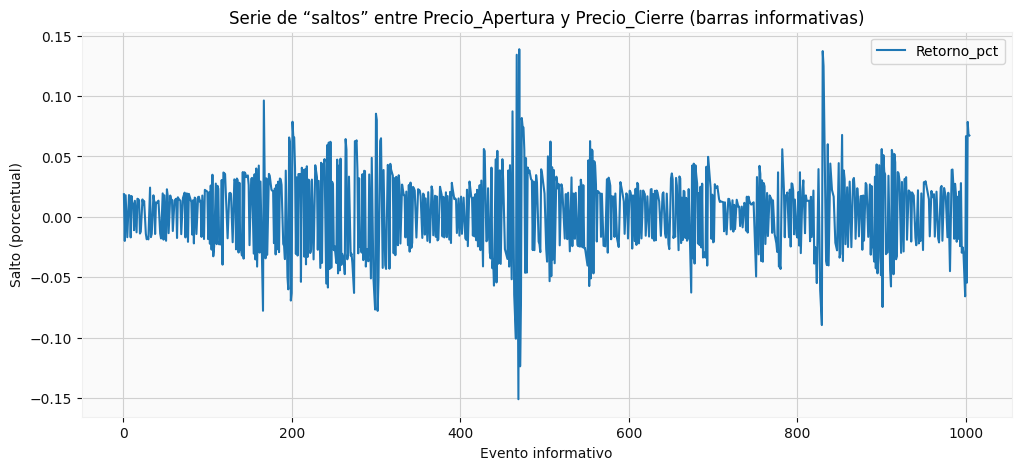

In [ ]:
# --- Visualización ---
plt.figure(figsize=(12,5))
plt.plot(df_barras.index, df_barras['Retorno_pct'], label='Retorno_pct')
plt.title('Serie de “saltos” entre Precio_Apertura y Precio_Cierre (barras informativas)')
plt.xlabel('Evento informativo')
plt.ylabel('Salto (porcentual)')
plt.legend()
plt.show()

**Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**

In [ ]:
from statsmodels.tsa.stattools import kpss

# Usamos la misma serie de saltos que antes (sin modificar df_barras)
resultado_kpss = kpss(serie_test, regression='c', nlags='auto')

kpss_stat  = resultado_kpss[0]
p_value    = resultado_kpss[1]
n_lags     = resultado_kpss[2]

print(f"Estadístico KPSS: {kpss_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
print(f"Número de lags usados: {n_lags}")

if p_value < 0.05:
    print("❌ La serie NO es estacionaria según KPSS (se rechaza la hipótesis nula).")
else:
    print("✔️ La serie es estacionaria según KPSS (no se rechaza la hipótesis nula).")

Estadístico KPSS: 0.0583
p-valor: 0.1000
Número de lags usados: 11
✔️ La serie es estacionaria según KPSS (no se rechaza la hipótesis nula).


Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS): Complementa el ADF, con la hipótesis nula opuesta (la serie es estacionaria). Un p-valor alto (mayor a 0,10) confirma la estacionariedad.

**Diagnóstico de Correlación y Distribución de Saltos**

<Figure size 1000x400 with 0 Axes>

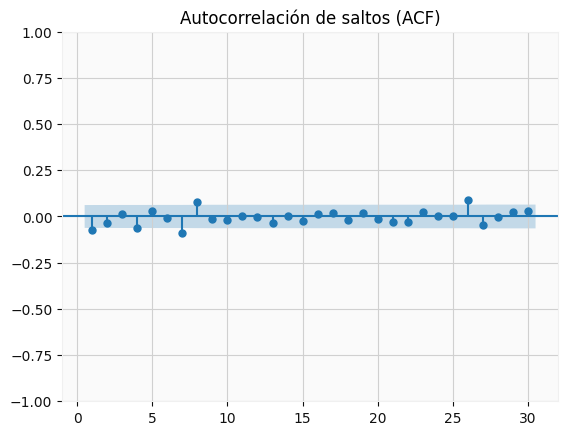

<Figure size 1000x400 with 0 Axes>

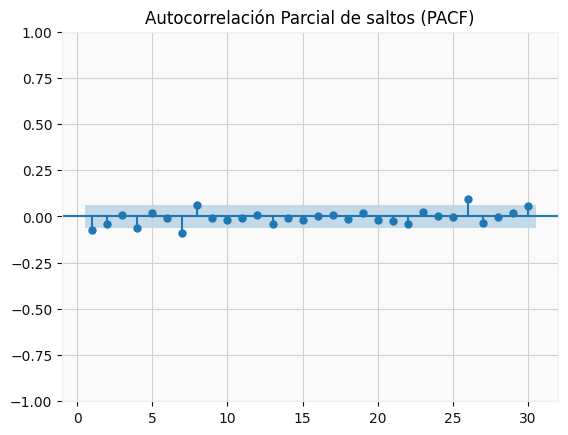

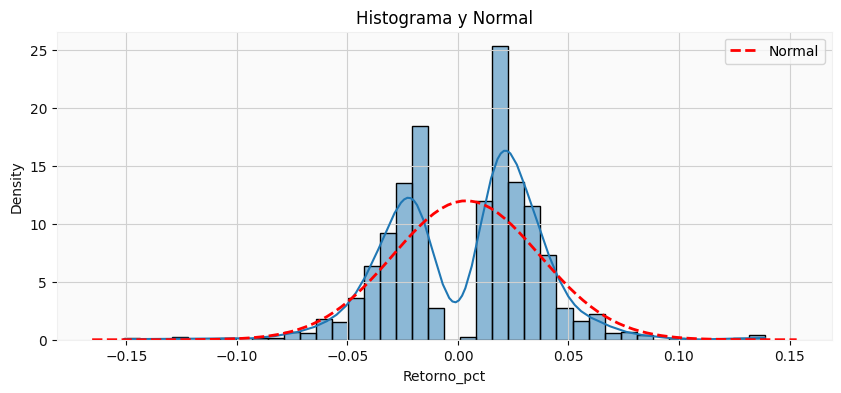

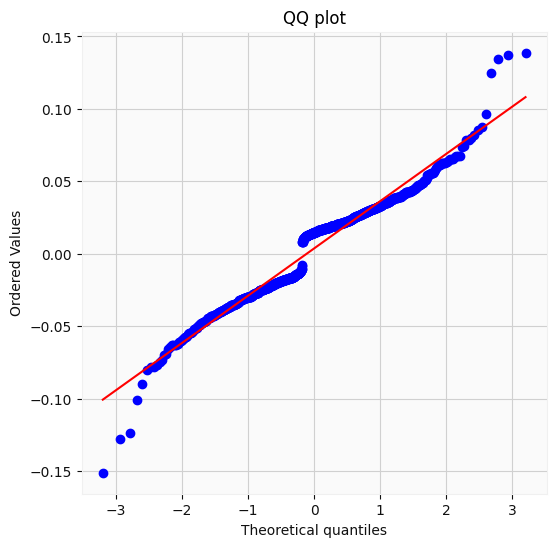

Media:     0.0037
Desvío:    0.0333
Skewness:  -0.14
Kurtosis:  0.79


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis, norm, probplot

# 1. Autocorrelación
plt.figure(figsize=(10,4))
plot_acf(serie_test, lags=30, zero=False)
plt.title("Autocorrelación de saltos (ACF)")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(serie_test, lags=30, zero=False)
plt.title("Autocorrelación Parcial de saltos (PACF)")
plt.show()

# 2. Distribución
plt.figure(figsize=(10,4))
sns.histplot(serie_test, bins=40, kde=True, stat="density")
mu, sigma = serie_test.mean(), serie_test.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label='Normal')
plt.title('Histograma y Normal')
plt.legend()
plt.show()

# QQ plot
plt.figure(figsize=(6,6))
probplot(serie_test, dist="norm", plot=plt)
plt.title('QQ plot')
plt.show()

# Estadísticos
print(f"Media:     {mu:.4f}")
print(f"Desvío:    {sigma:.4f}")
print(f"Skewness:  {skew(serie_test):.2f}")
print(f"Kurtosis:  {kurtosis(serie_test, fisher=True):.2f}")

Análisis gráfico: Los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) muestran que la serie de "saltos" (retornos entre eventos) tiene una autocorrelación cercana a cero, lo que implica que cada evento es casi independiente del anterior, lo cual es deseable estadísticamente.

## Etiquetar la variable objetivo

In [ ]:
# Etiqueta: 1 si Precio_Cierre siguiente es mayor a Precio_Cierre actual, de lo contario, 0
df_barras['Objetivo'] = (df_barras['Precio_Cierre'].shift(-1) > df_barras['Precio_Cierre']).astype(int)

Clasificación binaria: Cada evento informativo se etiqueta como "1" si el siguiente evento es alcista (precio de cierre supera al actual) o "0" (bajista). Esto define lo que el modelo intentará predecir.

In [ ]:
# Contar cuántas veces aparece cada valor en 'Objetivo' y calcular proporción
conteo_objetivo = df_barras['Objetivo'].value_counts()
proporcion_objetivo = conteo_objetivo / len(df_barras)

print("Conteo de 'Objetivo':")
print(conteo_objetivo)

print("\nProporción de 'Objetivo':")
print(proporcion_objetivo)

Conteo de 'Objetivo':
Objetivo
1    574
0    431
Name: count, dtype: int64

Proporción de 'Objetivo':
Objetivo
1   0.571144
0   0.428856
Name: count, dtype: float64


 Ventajas: Este método busca optimizar la relación señal/ruido, incorporar la volatilidad intrínsecamente y evitar etiquetas neutrales, lo que contribuye a un entrenamiento más robusto del modelo.

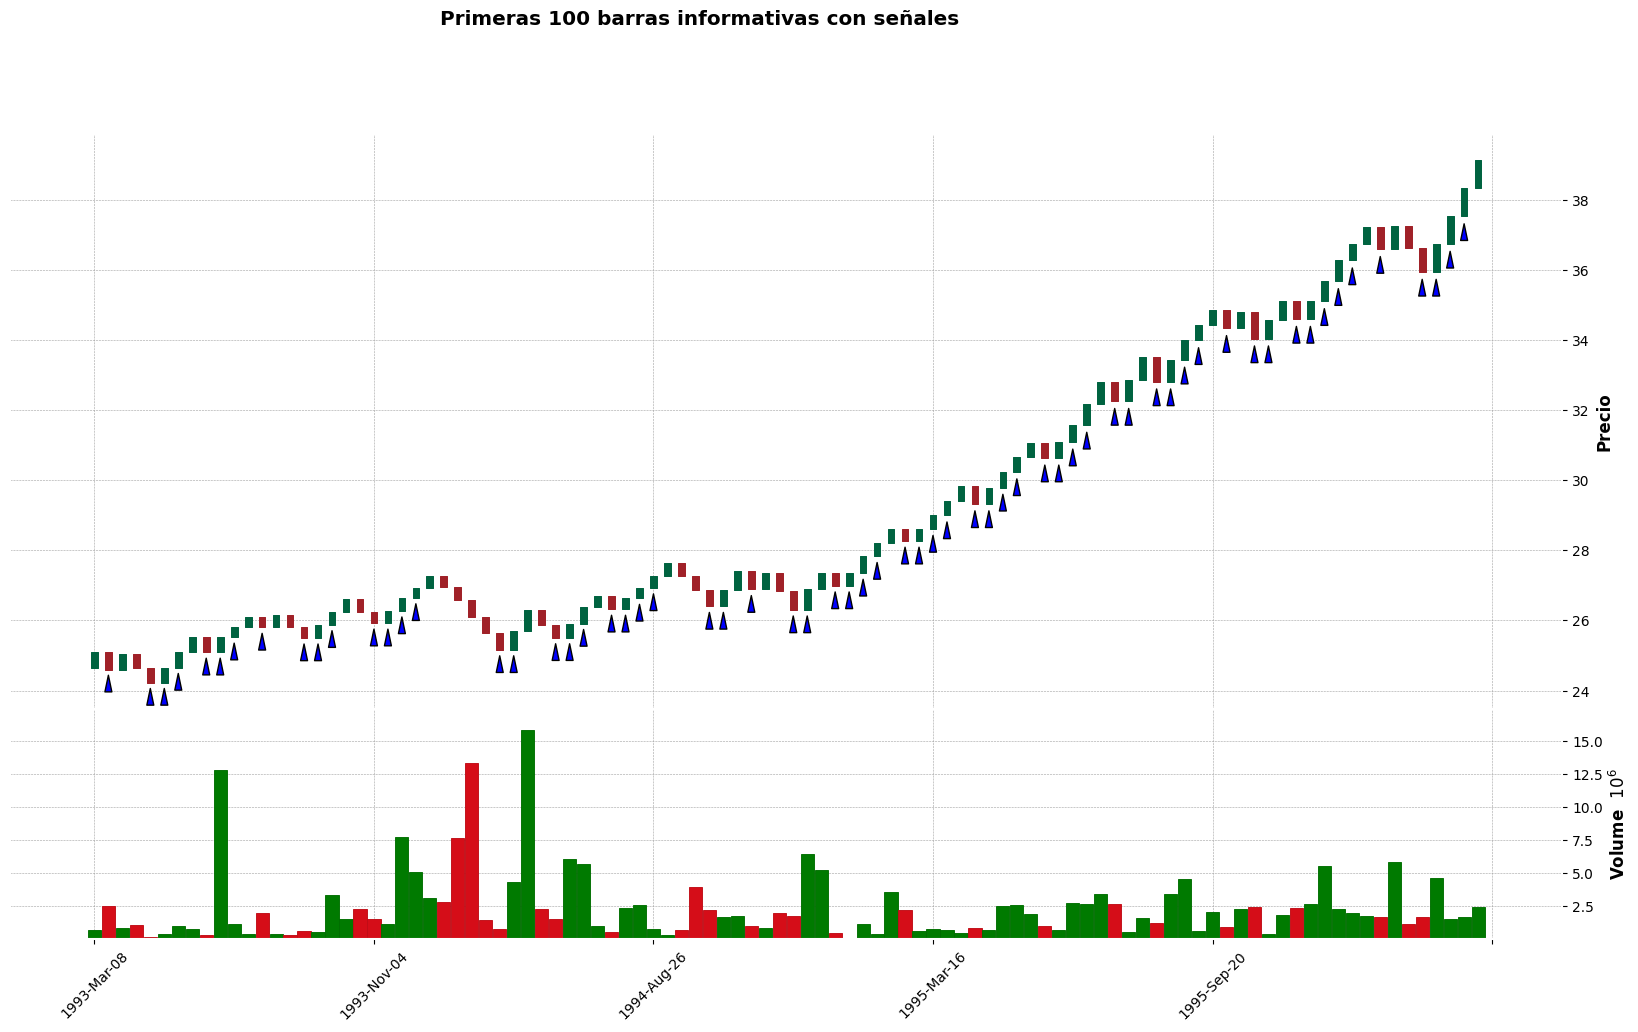

In [ ]:
# Prepara el DataFrame para el plot
df_barras_plot = df_barras.copy()

df_barras_plot['Open'] = df_barras_plot['Precio_Cierre'].shift(1)
df_barras_plot['High'] = df_barras_plot[['Open', 'Precio_Cierre']].max(axis=1)
df_barras_plot['Low'] = df_barras_plot[['Open', 'Precio_Cierre']].min(axis=1)
df_barras_plot = df_barras_plot.dropna().reset_index(drop=True).head(100)

df_barras_plot['Fecha_Cierre'] = pd.to_datetime(df_barras_plot['Fecha_Cierre'])
df_barras_plot = df_barras_plot.set_index('Fecha_Cierre')
df_barras_plot.rename(columns={'Precio_Cierre': 'Close'}, inplace=True)

# El volumen ya está acumulado en df_barras_plot['Volume']

columns_for_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

# Creamos la figura de mplfinance y guardamos axes
fig, ax = mpf.plot(
    df_barras_plot[columns_for_plot],
    type='candle',
    style='charles',
    title='Primeras 100 barras informativas con señales',
    ylabel='Precio',
    figratio=(15,8),
    figscale=2.0,
    volume=True,
    returnfig=True
)

# Extrae la lista de fechas (índice) como array
fechas = df_barras_plot.index.to_list()
close_max = df_barras_plot['Close'].max()
# Calcula el desplazamiento vertical para las flechas (ajústalo si lo ves muy arriba/abajo)
offset = close_max * 0.01

# Define la columna de señal (ajusta el nombre según tu DataFrame)
signal_idx = df_barras_plot[df_barras_plot['Objetivo'] == 1].index
signal_prices = df_barras_plot.loc[signal_idx, 'Low'] * 0.995  # Un poco debajo del mínimo

# Dibuja flechas para cada señal
for fecha, low in zip(signal_idx, signal_prices):
    xpos = fechas.index(fecha)
    ax[0].annotate(
        '',
        xy=(xpos, low),
        xytext=(xpos, low - offset),
        arrowprops=dict(facecolor='blue', shrink=0.1, width=1.5, headwidth=5),
        ha='center'
    )

# Asegúrate de mostrar el gráfico completo
plt.show()

## Construir variables independientes

In [ ]:
# VIX
# Definir Parámetros
ticker_vix = "^VIX"
inicio_vix = "1993-01-29"
final_vix = "2025-06-30"

In [ ]:
# Descargar datos diarios
vix = yf.download(tickers=ticker_vix, start=inicio_vix, end=final_vix, interval="1d", multi_level_index=False)
print(vix.head())
print(vix.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open  Volume
Date                                                      
1993-01-29 12.420000 13.160000 12.420000 12.490000       0
1993-02-01 12.330000 12.920000 12.180000 12.510000       0
1993-02-02 12.250000 12.890000 12.220000 12.470000       0
1993-02-03 12.120000 12.340000 11.790000 11.980000       0
1993-02-04 12.290000 12.840000 11.690000 11.860000       0
               Close      High       Low      Open  Volume
Date                                                      
2025-06-23 19.830000 22.510000 19.820000 21.150000       0
2025-06-24 17.480000 18.719999 17.330000 18.190001       0
2025-06-25 16.760000 17.510000 16.680000 17.280001       0
2025-06-26 16.590000 16.780001 16.110001 16.670000       0
2025-06-27 16.320000 17.290001 16.120001 16.309999       0


In [ ]:
# --- 1. Asegurar tipos y nombres ---
# Convierte Fecha_Inicio a datetime (si no lo está ya)
df_barras['Fecha_Cierre'] = pd.to_datetime(df_barras['Fecha_Cierre'])
# Asegura que el índice de vix sea datetime
vix.index = pd.to_datetime(vix.index)

# --- 2. Mapear el Open de VIX al df_barras ---
# Renombra la serie para claridad
serie_vix = vix['Open'].rename('VIX_Open')

# Usamos map() para asignar, vía índice de fechas
df_barras['VIX_Open'] = df_barras['Fecha_Cierre'].map(serie_vix)

# --- 3. Verificar resultado ---
print(df_barras[['Fecha_Cierre', 'Precio_Cierre', 'VIX_Open']].head())

  Fecha_Cierre  Precio_Cierre  VIX_Open
0   1993-02-26      24.640545 13.470000
1   1993-03-08      25.101799 15.000000
2   1993-04-02      24.600661 14.270000
3   1993-04-12      25.040446 12.330000
4   1993-04-22      24.636561 11.580000


VIX_Open: El valor de apertura del índice de volatilidad VIX en la última barra diaria incluida en cada evento. Es un indicador de incertidumbre percibida por el mercado y es práctico para el inversor minorista, ya que está disponible al inicio de la jornada.

In [ ]:
# Retorno de los últimos 10 días
# ------------------------------------------------------
df_barras['Retornos_10'] = df_barras['Precio_Cierre'].pct_change(periods=10)

# Retorno diario
# ------------------------------------------------------
df_barras['Retorno_diario'] = df_barras['Precio_Cierre'].pct_change(periods=1)

Retornos_10: El retorno acumulado en los últimos 10 eventos informativos. Refleja la dirección y magnitud de los movimientos recientes del mercado.

In [ ]:
# Eliminar columnas con NaN
df_barras.dropna(inplace=True)

In [ ]:
# Resetear el index
df_barras.reset_index(drop=True, inplace=True)

In [ ]:
df_barras.head()

,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL,Retorno_pct,Objetivo,VIX_Open,Retornos_10,Retorno_diario
0,1993-08-16,25.520010,12847800.000000,0.145628,25.811266,25.228754,0.017222,1,12.370000,0.035692,0.017222
1,1993-08-24,25.811266,1181800.000000,0.139487,26.090240,25.532291,0.011413,1,11.940000,0.028264,0.011413
2,1993-08-26,26.090240,362300.000000,0.144751,26.379743,25.800737,0.010808,0,11.850000,0.060550,0.010808
3,1993-09-08,25.800737,1981400.000000,0.150894,26.102526,25.498949,-0.011096,1,12.260000,0.030363,-0.011096
4,1993-09-13,26.143045,412600.000000,0.157914,26.458873,25.827218,0.013267,0,11.670000,0.061148,0.013267


## Dividir el dataframe entre Entrenamiento (90%) y Hold-out (10%)

In [ ]:
# ------------------------------
# División Train / Hold-Out 900/final
# ------------------------------

# Número total de barras
n_barras = len(df_barras)

# Primer 900 barras
df_train = df_barras.iloc[:900].reset_index(drop=True)

# Últimas → hold-out
df_holdout = df_barras.iloc[900:].reset_index(drop=True)

# Comprobación de tamaños
print(f"Total barras:     {n_barras}")
print(f"Entrenamiento:    {len(df_train)} barras ({len(df_train)/n_barras:.1%})")
print(f"Hold-out final:   {len(df_holdout)} barras ({len(df_holdout)/n_barras:.1%})")

Total barras:     995
Entrenamiento:    900 barras (90.5%)
Hold-out final:   95 barras (9.5%)


Train/Hold-out Split: El dataset se divide en un conjunto de entrenamiento (90.5%, 900 barras) y un conjunto de prueba (9.5%, 95 barras) que se mantiene intocable hasta el final.

## Dividir en Folds de Entrenamiento y Validación

In [ ]:
# Parámetros de tamaño de ventana
num_train = 500
num_val   = 40

# Lista que contendrá tuplas (índices_train, índices_val)
folds = []

# Recorrer en pasos del tamaño de la validación para solapamiento rolling
for start in range(0, len(df_train) - num_train - num_val + 1, num_val):
    # Definir rango de posiciones para train y validación
    train_pos = slice(start, start + num_train)
    val_pos   = slice(start + num_train, start + num_train + num_val)

    # Extraer los índices reales del DataFrame
    idx_train = df_train.index[train_pos]
    idx_val   = df_train.index[val_pos]

    folds.append((idx_train, idx_val))

# Ejemplo: imprimir el número de folds obtenidos
print(f"Total de folds: {len(folds)}")
for i, (tr, va) in enumerate(folds, 1):
    print(f"Fold {i}: train [{tr[0]} → {tr[-1]}], val [{va[0]} → {va[-1]}]")


Total de folds: 10
Fold 1: train [0 → 499], val [500 → 539]
Fold 2: train [40 → 539], val [540 → 579]
Fold 3: train [80 → 579], val [580 → 619]
Fold 4: train [120 → 619], val [620 → 659]
Fold 5: train [160 → 659], val [660 → 699]
Fold 6: train [200 → 699], val [700 → 739]
Fold 7: train [240 → 739], val [740 → 779]
Fold 8: train [280 → 779], val [780 → 819]
Fold 9: train [320 → 819], val [820 → 859]
Fold 10: train [360 → 859], val [860 → 899]


Validación cruzada por ventana rodante (Rolling Window): El conjunto de entrenamiento se subdivide en 10 folds (particiones). Cada fold usa 500 barras para entrenamiento y 40 para validación, y la ventana se desplaza 40 barras en cada iteración, simulando un entorno de trading real donde solo se usa información pasada.

## Funciones auxiliares

In [ ]:
# -- FUNCIONES ESTÁNDAR DE BACKTEST Y MÉTRICAS --
def ejecutar_backtest(df, signal_col='Signal', capital_inicial=100_000.0, riesgo_pct=0.02, spread=0.01, comision_por_accion=0.001):
    df = df.copy().reset_index(drop=True)
    df['EntryPrice'] = df['Precio_Cierre']
    df['ExitPrice']  = df['Precio_Cierre'].shift(-1)
    mask = df[signal_col] == 1
    df['Distance'] = np.nan
    df.loc[mask, 'Distance'] = np.abs(df.loc[mask, 'EntryPrice'] - df.loc[mask, 'SL'])
    df['Shares'] = 0.0
    valid = (df[signal_col]==1) & (df['Distance']>0)
    df.loc[valid, 'Shares'] = capital_inicial * riesgo_pct / df.loc[valid, 'Distance']

    # ---> capturar columnas ID (si existen)
    id_cols = [c for c in ['combo_idx'] if c in df.columns]

    df = df.iloc[:-1].copy()  # última fila no tiene salida
    df['GrossPnL'] = df['Shares'] * (df['ExitPrice'] - df['EntryPrice'])
    df['Cost']     = df['Shares'] * (spread + comision_por_accion)
    df['NetPnL']   = df['GrossPnL'] - df['Cost']
    df['Equity']   = capital_inicial + df['NetPnL'].cumsum()

    # ---> propagar IDs
    for c in id_cols:
        df[c] = df[c].astype(df[c].dtype)

    return df


def extraer_metricas(df_bt):
    equity = df_bt['Equity']
    if len(equity) < 2:
        return [np.nan]*7
    rets = df_bt['NetPnL'] / equity.iloc[0]
    years = (pd.to_datetime(df_bt['Fecha_Cierre'].iloc[-1]) - pd.to_datetime(df_bt['Fecha_Cierre'].iloc[0])).days / 365.25
    if years <= 0: years = 1/365.25
    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    events_per_year = len(rets) / years
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret>0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets)>0 else np.nan
    cagr     = (equity.iloc[-1] / equity.iloc[0]) ** (1/years) - 1
    running_max = equity.cummax()
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()
    hit_rate    = (df_bt['NetPnL'] > 0).mean()
    wins        = df_bt['NetPnL'][df_bt['NetPnL']>0].sum()
    loses       = -df_bt['NetPnL'][df_bt['NetPnL']<0].sum()
    profit_factor = wins / loses if loses > 0 else np.nan
    return sharpe, sortino, cagr, mdd, hit_rate, profit_factor, events_per_year

## Entrenamiento y evaluación HMM

In [ ]:
!pip install hmmlearn

In [ ]:
!pip install XlsxWriter

In [ ]:
from hmmlearn.hmm import GaussianHMM

# ===========================
# CONFIGURACIÓN
# ===========================
n_states       = 4
n_iter         = 200
random_state   = 42
features       = ['VIX_Open', 'Retornos_10']
epsilon_jitter = 1e-6
col_retorno_evento = 'Retorno_diario'
min_support = 50  # mínimo de eventos para considerar un estado al elegir el "peor"

# ===========================
# HELPERS ROBUSTOS
# ===========================
def to_positional_indexer(indexer, df: pd.DataFrame) -> np.ndarray:
    if isinstance(indexer, (pd.Series, pd.Index, list, np.ndarray)):
        arr = np.asarray(indexer)
        if arr.dtype == bool or (arr.dtype.kind == 'b'):
            if arr.size != len(df):
                raise ValueError("La máscara booleana no coincide con la longitud de df_train.")
            return np.flatnonzero(arr)
        if np.issubdtype(arr.dtype, np.integer):
            if isinstance(df.index, pd.RangeIndex) and df.index.start == 0 and df.index.step == 1:
                return arr.astype(int, copy=False)
            pos = df.index.get_indexer(arr)
            if (pos < 0).any():
                raise KeyError("Algunos índices del fold no existen en df_train.index (mapeo por etiquetas falló).")
            return pos
        pos = df.index.get_indexer(arr)
        if (pos < 0).any():
            raise KeyError("Algunos índices del fold no existen en df_train.index (mapeo por etiquetas falló).")
        return pos
    df_sel = df.loc[indexer]
    return df.index.get_indexer(df_sel.index)

def to_datetime_index_like(x):
    if isinstance(x, (pd.Series, pd.Index)):
        return pd.to_datetime(x)
    return pd.to_datetime(pd.Index(x))

def calcular_metricas_equity(equity, fechas):
    equity = np.asarray(equity, dtype=float)
    if isinstance(fechas, (pd.Series, pd.Index)):
        f_arr = pd.to_datetime(fechas).to_numpy()
    else:
        f_arr = pd.to_datetime(pd.Index(fechas)).to_numpy()

    if equity.size < 2 or f_arr.size < 2:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    order = np.argsort(f_arr)
    equity = equity[order]
    f_arr  = f_arr[order]

    delta_days = (f_arr[-1] - f_arr[0]) / np.timedelta64(1, 'D')
    years = max(delta_days / 365.25, 1/365.25)

    rets = pd.Series(equity).pct_change().dropna()
    if rets.size == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(len(rets) / years) if std_ret > 0 else np.nan

    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(len(rets) / years) if neg_rets.size > 0 else np.nan

    cagr = (equity[-1] / equity[0]) ** (1/years) - 1
    running_max = np.maximum.accumulate(equity)
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()
    calmar      = cagr / abs(mdd) if mdd < 0 else np.nan
    return cagr, sharpe, sortino, mdd, calmar

# ===========================
# ENTRENAR MODELOS POR FOLD (siempre POSICIONAL)
# ===========================
hmm_models = []
for i, (idx_train, idx_val) in enumerate(folds, start=1):
    pos_tr = to_positional_indexer(idx_train, df_train)
    pos_va = to_positional_indexer(idx_val,   df_train)

    X_tr = df_train.iloc[pos_tr][features].to_numpy(copy=True)
    X_va = df_train.iloc[pos_va][features].to_numpy(copy=True)

    X_tr += epsilon_jitter * np.random.randn(*X_tr.shape)
    X_va += epsilon_jitter * np.random.randn(*X_va.shape)

    try:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='full',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)
    except ValueError:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='diag',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)
    hmm_models.append(model)

# ===========================
# MÉTRICAS POR FOLD (retornos de evento + HitRate)
# + Captura del estado con peor HitRate y sus parámetros A/B (desde el HMM)
# ===========================
if col_retorno_evento not in df_train.columns:
    raise KeyError(f"No se encontró la columna '{col_retorno_evento}' en df_train.")

excel_writer_metrics = pd.ExcelWriter("hmm_metrics_por_fold.xlsx", engine='openpyxl')
tabla_resumen = []

# Donde acumularemos A/B por fold
param_peor_por_fold = []  # dicts con Fold, Peor_Estado, HitRate_Peor, N_eventos_Peor, A, B

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    pos_tr = to_positional_indexer(idx_tr, df_train)

    df_tr      = df_train.iloc[pos_tr].copy()
    fechas_tr  = df_tr['Fecha_Cierre']
    precios_tr = df_tr['Precio_Cierre']
    X_tr       = df_tr[features].to_numpy()
    train_sts  = model.predict(X_tr)

    # --- Buy & Hold del período ---
    equity_bh = precios_tr.to_numpy() / precios_tr.iloc[0]
    cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh = calcular_metricas_equity(equity_bh, fechas_tr)

    # --- Métricas por Estado (para poder elegir peor por HitRate) ---
    filas_metrics = []
    n_states_model = model.means_.shape[0]
    for estado in range(n_states_model):
        mask = (train_sts == estado)
        n_mask = int(mask.sum())
        if n_mask < 2:
            filas_metrics.append([estado, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, n_mask])
            continue

        df_e = df_tr.iloc[mask][['Fecha_Cierre', col_retorno_evento]].sort_values('Fecha_Cierre')
        rets_e = pd.to_numeric(df_e[col_retorno_evento], errors='coerce').dropna().to_numpy()

        if rets_e.size < 1:
            filas_metrics.append([estado, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, n_mask])
            continue

        equity_estado = np.cumprod(1.0 + rets_e)
        fechas_estado = df_e['Fecha_Cierre'].iloc[:equity_estado.size]

        cagr, sharpe, sortino, mdd, calmar = calcular_metricas_equity(equity_estado, fechas_estado)
        hitrate = float((rets_e > 0).mean())

        filas_metrics.append([estado, cagr, sharpe, sortino, mdd, calmar, hitrate, int(rets_e.size)])

    df_metrics = pd.DataFrame(
        filas_metrics,
        columns=['Estado', 'CAGR', 'Sharpe', 'Sortino', 'MDD', 'Calmar', 'HitRate', 'N_eventos']
    ).round({'CAGR':4,'Sharpe':4,'Sortino':4,'MDD':4,'Calmar':4,'HitRate':4})

    # --- Identificar el PEOR estado por fold (menor HitRate con soporte mínimo) ---
    df_estados_solo = df_metrics[pd.to_numeric(df_metrics['Estado'], errors='coerce').notna()].copy()
    candidatos = df_estados_solo[(~df_estados_solo['HitRate'].isna()) & (df_estados_solo['N_eventos'] >= min_support)]
    if len(candidatos) == 0:
        candidatos = df_estados_solo[~df_estados_solo['HitRate'].isna()]
    if len(candidatos) > 0:
        peor_row = candidatos.loc[candidatos['HitRate'].idxmin()]
        peor_estado = int(peor_row['Estado'])
        peor_hit    = float(peor_row['HitRate'])
        peor_n      = int(peor_row['N_eventos'])
    else:
        peor_estado, peor_hit, peor_n = np.nan, np.nan, 0

    # --- Guardar métricas a Excel (fold) ---
    df_bh = pd.DataFrame([['Buy & Hold', cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh, np.nan, len(df_tr)]],
                         columns=df_metrics.columns)
    df_metrics_all = pd.concat([df_metrics, df_bh], ignore_index=True)
    df_metrics_all.to_excel(excel_writer_metrics, sheet_name=f"Fold_{i}", index=False)
    print(f"\n===== MÉTRICAS FOLD {i} (por Estado, retornos de evento) =====")
    print(df_metrics_all)
    print(f"--> Peor estado (fold {i}): {peor_estado} | HitRate={peor_hit} | N={peor_n}")

    df_metrics_all['Fold'] = i
    tabla_resumen.append(df_metrics_all)

    # --- Calcular A y B desde los PARÁMETROS DEL HMM del peor estado ---
    # stds del HMM (cuadr raíz de covarianzas; si 'full', usamos diagonal)
    raw_covars = model.covars_
    if raw_covars.ndim == 3:
        covars = np.array([np.diag(c) for c in raw_covars])
    else:
        covars = raw_covars
    means = model.means_
    stds  = np.sqrt(covars)

    # índices de features
    ix_vix = features.index('VIX_Open')
    ix_ret = features.index('Retornos_10')

    if not np.isnan(peor_estado):
        mu_vix  = float(means[peor_estado, ix_vix])
        sd_vix  = float(stds [peor_estado,  ix_vix])
        mu_ret  = float(means[peor_estado, ix_ret])
        sd_ret  = float(stds [peor_estado,  ix_ret])

        A = mu_vix - sd_vix
        B = mu_ret + sd_ret
    else:
        A = np.nan
        B = np.nan

    # Guardar umbrales A/B del fold
    param_peor_por_fold.append({
        'Fold': i,
        'Peor_Estado': peor_estado,
        'HitRate_Peor': peor_hit,
        'N_eventos_Peor': peor_n,
        'A_VIX_Open': A,
        'B_Retornos_10': B
    })

    # Crear columnas constantes por fold en df_train para usar luego en el filtro:
    # Regla de filtrado propuesta: si VIX_Open > A y Retornos_10 < B --> filtrar
    colA = f'FiltroA_fold{i}'
    colB = f'FiltroB_fold{i}'
    if colA not in df_train.columns:
        df_train[colA] = np.nan
    if colB not in df_train.columns:
        df_train[colB] = np.nan

    pos_all = np.concatenate([to_positional_indexer(idx_tr, df_train),
                              to_positional_indexer(folds[i-1][1], df_train)])  # train + valid del mismo fold
    df_train.iloc[pos_all, df_train.columns.get_loc(colA)] = A
    df_train.iloc[pos_all, df_train.columns.get_loc(colB)] = B

# Resumen global de métricas
df_tabla_resumen = pd.concat(tabla_resumen, ignore_index=True)
df_tabla_resumen.to_excel(excel_writer_metrics, sheet_name='Resumen_Global', index=False)
excel_writer_metrics.close()
print("\nArchivo 'hmm_metrics_por_fold.xlsx' generado correctamente (con HitRate por Estado).")

# ===========================
# PARÁMETROS POR FOLD (alineados a 'features') — informativo
# ===========================
excel_writer_params = pd.ExcelWriter("hmm_parametros_por_fold.xlsx", engine='openpyxl')
tabla_parametros = []

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    pos_tr = to_positional_indexer(idx_tr, df_train)

    raw_covars = model.covars_
    if raw_covars.ndim == 3:
        covars = np.array([np.diag(c) for c in raw_covars])
    else:
        covars = raw_covars

    means = model.means_
    stds  = np.sqrt(covars)
    n_states_model = means.shape[0]

    X_tr        = df_train.iloc[pos_tr][features].to_numpy()
    train_sts   = model.predict(X_tr)
    proportions = np.bincount(train_sts, minlength=n_states_model) / len(train_sts)

    df_states = pd.DataFrame({
        'Fold':                 i,
        'Estado':               np.arange(n_states_model),
        f'Media_{features[0]}': means[:, 0],
        f'Std_{features[0]}':   stds[:,  0],
        f'Media_{features[1]}': means[:, 1],
        f'Std_{features[1]}':   stds[:,  1],
        'Proporción':           proportions
    })

    df_states.to_excel(excel_writer_params, sheet_name=f"Fold_{i}", index=False)
    print(f"\n===== PARÁMETROS FOLD {i} =====")
    print(df_states.round(4))

    tabla_parametros.append(df_states)

df_tabla_parametros = pd.concat(tabla_parametros, ignore_index=True)
df_tabla_parametros.to_excel(excel_writer_params, sheet_name='Resumen_Parametros', index=False)
excel_writer_params.close()
print("\nArchivo 'hmm_parametros_por_fold.xlsx' generado correctamente.")

# ===========================
# EXPORTAR UMBRALES A/B DEL PEOR ESTADO POR FOLD
# ===========================
df_peor_params = pd.DataFrame(param_peor_por_fold,
                              columns=['Fold','Peor_Estado','HitRate_Peor','N_eventos_Peor','A_VIX_Open','B_Retornos_10'])
df_peor_params.to_excel("hmm_peor_estado_params_por_fold.xlsx", index=False)
print("\nResumen 'parámetros (A/B) del peor estado por fold':")
print(df_peor_params)


===== MÉTRICAS FOLD 1 (por Estado, retornos de evento) =====
       Estado      CAGR    Sharpe   Sortino       MDD    Calmar  HitRate  \
0           0 -0.045300 -0.332200 -1.854100 -0.528300 -0.085700 0.373700   
1           1  0.061600  1.006100  5.428900 -0.077400  0.795800 0.632800   
2           2 -0.040100 -0.215100 -0.606000 -0.497400 -0.080600 0.409100   
3           3  0.119200  1.110100  4.603100 -0.097000  1.228600 0.622200   
4  Buy & Hold  0.072642  0.451621  0.860472 -0.533823  0.136079      NaN   

   N_eventos  
0         99  
1        177  
2         44  
3        180  
4        500  
--> Peor estado (fold 1): 0 | HitRate=0.3737 | N=99

===== MÉTRICAS FOLD 2 (por Estado, retornos de evento) =====
       Estado      CAGR    Sharpe   Sortino       MDD    Calmar  HitRate  \
0           0  0.063600  1.095700  6.451400 -0.061100  1.040500 0.649600   
1           1 -0.042700 -0.318600 -1.745500 -0.528300 -0.080800 0.377400   
2           2  0.123100  1.134500  4.627300 -0.09

Los HMM son modelos estadísticos para describir sistemas con estados no observables (ocultos) que influyen en las observaciones visibles. En finanzas, se usan para identificar "regímenes de mercado" (e.g., alta volatilidad, tendencias alcistas).

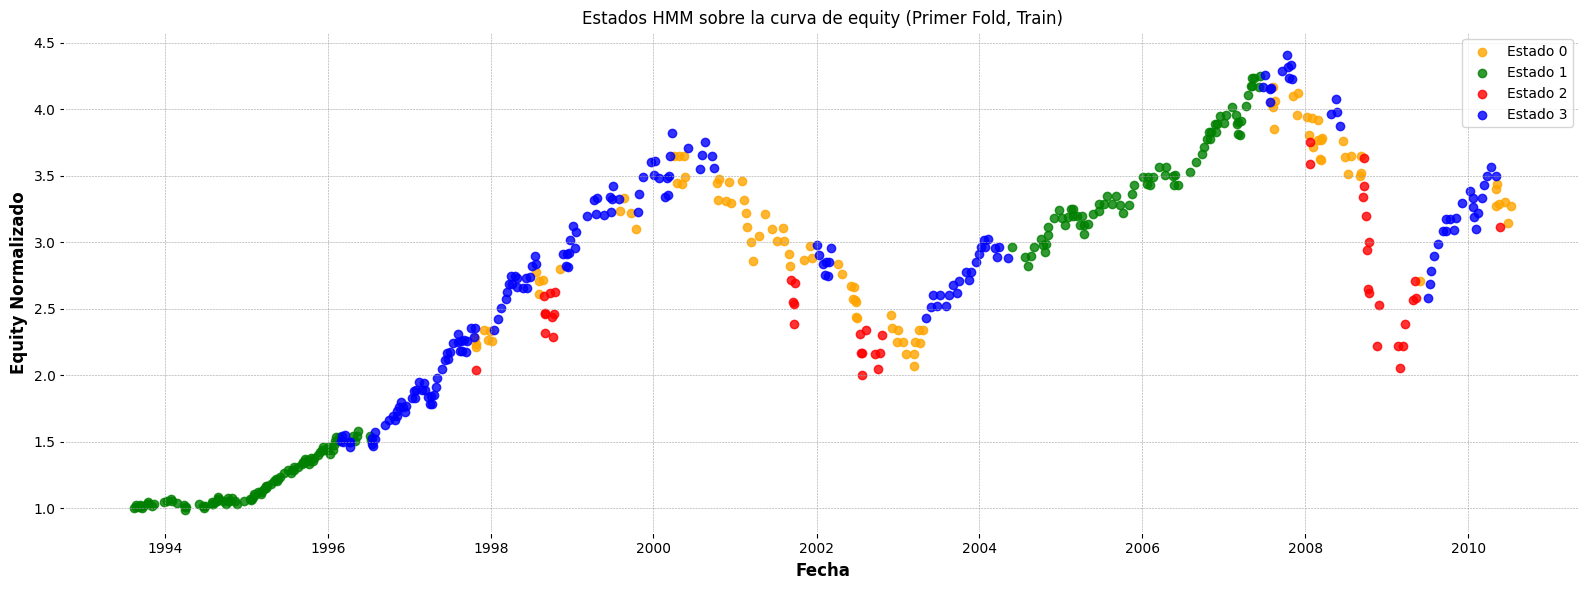

In [ ]:
# --- Selecciona el primer fold ---
i_fold = 0  # Primer fold
idx_tr, _ = folds[i_fold]
model = hmm_models[i_fold]

# --- Extrae precios, fechas y calcula equity ---
fechas_tr = pd.to_datetime(df_train.loc[idx_tr, 'Fecha_Cierre'])
precios_tr = df_train.loc[idx_tr, 'Precio_Cierre'].values
equity_tr = precios_tr / precios_tr[0]

# --- Predice los estados en train ---
X_tr = df_train.loc[idx_tr, features].values
estados_tr = model.predict(X_tr)

# --- Configuración de colores por estado ---
colores = ['orange', 'green', 'red', 'blue']

plt.figure(figsize=(16, 6))

for estado in np.unique(estados_tr):
    mask = (estados_tr == estado)
    plt.scatter(fechas_tr[mask], equity_tr[mask],
                label=f"Estado {estado}",
                color=colores[estado % len(colores)],
                s=36, alpha=0.8)

plt.title('Estados HMM sobre la curva de equity (Primer Fold, Train)')
plt.xlabel('Fecha')
plt.ylabel('Equity Normalizado')
plt.legend()
plt.tight_layout()
plt.show()

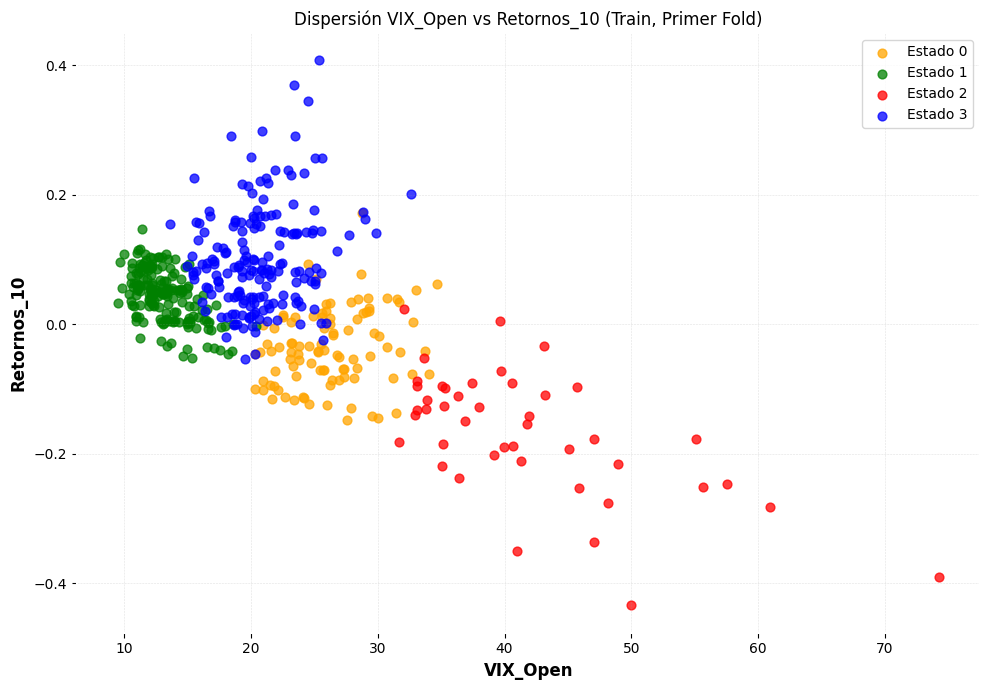

In [ ]:
# --- Selecciona el primer fold ---
i_fold = 0
idx_tr, _ = folds[i_fold]
model = hmm_models[i_fold]

# --- Extrae las variables y los estados ---
X_tr = df_train.loc[idx_tr, features].values
estados_tr = model.predict(X_tr)
vix_tr = X_tr[:, features.index('VIX_Open')]
ret10_tr = X_tr[:, features.index('Retornos_10')]

# --- Configuración de colores por estado ---
colores = ['orange', 'green', 'red', 'blue']

plt.figure(figsize=(10, 7))
for estado in np.unique(estados_tr):
    mask = (estados_tr == estado)
    plt.scatter(vix_tr[mask], ret10_tr[mask],
                label=f"Estado {estado}",
                color=colores[estado % len(colores)],
                s=40, alpha=0.75)

plt.xlabel('VIX_Open')
plt.ylabel('Retornos_10')
plt.title('Dispersión VIX_Open vs Retornos_10 (Train, Primer Fold)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

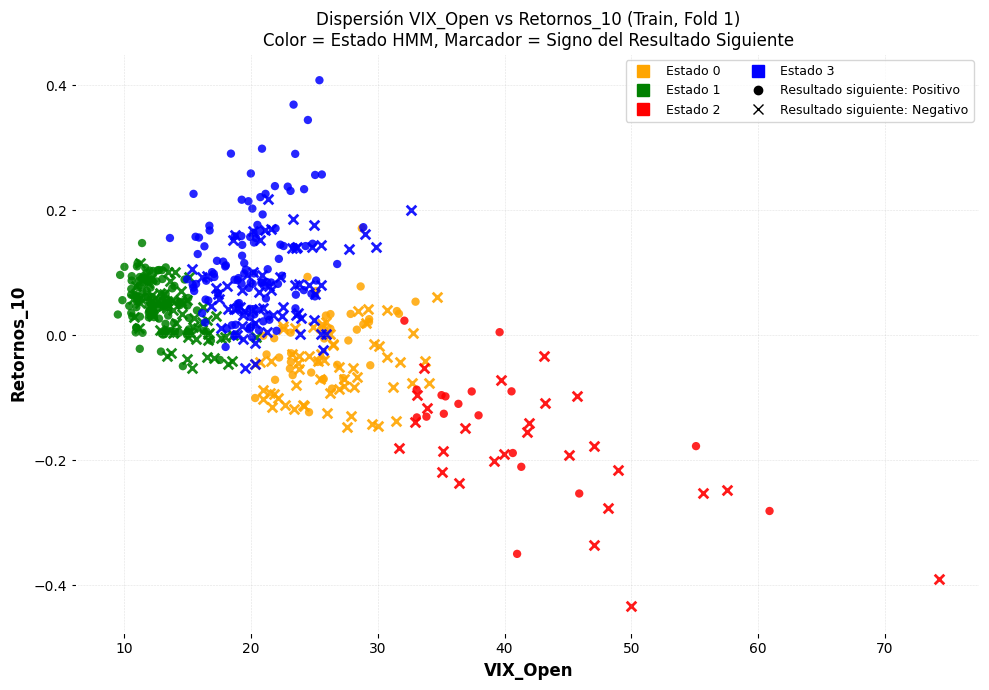


===== Diagnóstico por Estado (Fold 1) =====
   Fold  Estado  N_eventos  Positivos  Negativos  HitRate  Media_Resultado  \
0     1       0         99         37         62 0.373700        -0.005349   
1     1       1        177        112         65 0.632800         0.004925   
2     1       2         44         18         26 0.409100        -0.010502   
3     1       3        180        112         68 0.622200         0.009240   

   Mediana_Resultado  P25_Resultado  P75_Resultado  
0          -0.030626      -0.038060       0.041071  
1           0.013848      -0.015296       0.017814  
2          -0.049983      -0.063541       0.063494  
3           0.025860      -0.024381       0.034191  

Totales Fold 1 -> N=500, Positivos=279, HitRate_Global=0.5580

Archivos 'diagnostico_estados_fold1.xlsx' y '.csv' generados.


In [ ]:
# ===========================
# Dispersión por Estado HMM diferenciando signo del resultado siguiente
# ===========================

# --- Selecciona el primer fold (ajusta si deseas otro) ---
i_fold = 0
idx_tr, _ = folds[i_fold]
model = hmm_models[i_fold]

# --- Variables de entrada (usa las mismas que entrenaste) ---
features = ['VIX_Open', 'Retornos_10']
X_tr = df_train.loc[idx_tr, features].values
estados_tr = model.predict(X_tr)
vix_tr = X_tr[:, features.index('VIX_Open')]
ret10_tr = X_tr[:, features.index('Retornos_10')]

# --- Detectar/obtener la columna con el resultado del evento siguiente ---
# Regla: >0 => positivo, <0 => negativo
posibles_columnas_resultado = ['Retorno_diario']

col_resultado = None
for c in posibles_columnas_resultado:
    if c in df_train.columns:
        col_resultado = c
        break

if col_resultado is None:
    raise ValueError(
        "No se encontró ninguna columna de resultado siguiente. "
    )

resultado_siguiente = df_train.loc[idx_tr, col_resultado].values.astype(float)

# --- Definir etiquetas binarias por signo ---
#  1 => resultado positivo, 0 => resultado negativo
resultado_binario = (resultado_siguiente > 0).astype(int)

# --- Configuración de colores por estado (igual que tu ejemplo) ---
colores = ['orange', 'green', 'red', 'blue']

plt.figure(figsize=(10, 7))

# Para la leyenda, controlamos añadir cada etiqueta una sola vez
mostro_pos = False
mostro_neg = False
handles = []
labels = []

for estado in np.unique(estados_tr):
    mask_estado = (estados_tr == estado)

    # Positivos (●)
    mask_pos = mask_estado & (resultado_binario == 1)
    sc_pos = plt.scatter(
        vix_tr[mask_pos], ret10_tr[mask_pos],
        label=None,
        color=colores[estado % len(colores)],
        s=36, alpha=0.85, marker='o', edgecolor='none'
    )
    # Negativos (×)
    mask_neg = mask_estado & (resultado_binario == 0)
    sc_neg = plt.scatter(
        vix_tr[mask_neg], ret10_tr[mask_neg],
        label=None,
        color=colores[estado % len(colores)],
        s=48, alpha=0.9, marker='x'
    )

    # Etiqueta por estado (solo una vez, usando un handle “invisible” con el color del estado)
    h_estado = plt.Line2D([], [], color=colores[estado % len(colores)], marker='s',
                          linestyle='None', markersize=8, label=f"Estado {estado}")
    handles.append(h_estado)
    labels.append(f"Estado {estado}")

# Leyenda de tipo de resultado (común a todos los estados)
h_pos = plt.Line2D([], [], color='k', marker='o', linestyle='None', markersize=6, label='Resultado siguiente: Positivo')
h_neg = plt.Line2D([], [], color='k', marker='x', linestyle='None', markersize=7, label='Resultado siguiente: Negativo')

# Construimos una leyenda combinada (Estados + tipos de resultado)
handles.extend([h_pos, h_neg])
labels.extend(['Resultado siguiente: Positivo', 'Resultado siguiente: Negativo'])

plt.xlabel('VIX_Open')
plt.ylabel('Retornos_10')
plt.title('Dispersión VIX_Open vs Retornos_10 (Train, Fold 1)\nColor = Estado HMM, Marcador = Signo del Resultado Siguiente')
leg = plt.legend(handles, labels, ncol=2, frameon=True, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===========================
# TABLA DE DIAGNÓSTICO POR ESTADO
# ===========================
resumen_por_estado = []
for estado in np.unique(estados_tr):
    m = (estados_tr == estado)
    n = m.sum()
    if n == 0:
        continue
    pos = (resultado_siguiente[m] > 0).sum()
    neg = (resultado_siguiente[m] <= 0).sum()
    hit_rate = pos / n if n > 0 else np.nan
    media_res = np.nanmean(resultado_siguiente[m]) if n > 0 else np.nan
    mediana_res = np.nanmedian(resultado_siguiente[m]) if n > 0 else np.nan

    # Puedes añadir más: percentiles, desviación, etc.
    p25 = np.nanpercentile(resultado_siguiente[m], 25) if n > 0 else np.nan
    p75 = np.nanpercentile(resultado_siguiente[m], 75) if n > 0 else np.nan

    resumen_por_estado.append({
        'Fold': i_fold+1,
        'Estado': estado,
        'N_eventos': int(n),
        'Positivos': int(pos),
        'Negativos': int(neg),
        'HitRate': round(hit_rate, 4),
        'Media_Resultado': round(media_res, 6),
        'Mediana_Resultado': round(mediana_res, 6),
        'P25_Resultado': round(p25, 6),
        'P75_Resultado': round(p75, 6),
    })

df_resumen_estado = pd.DataFrame(resumen_por_estado).sort_values(['Estado']).reset_index(drop=True)

print("\n===== Diagnóstico por Estado (Fold 1) =====")
print(df_resumen_estado)

# Totales del fold
n_total = len(resultado_siguiente)
pos_total = (resultado_siguiente > 0).sum()
hit_total = pos_total / n_total if n_total > 0 else np.nan
print(f"\nTotales Fold 1 -> N={n_total}, Positivos={pos_total}, HitRate_Global={hit_total:.4f}")

# Guarda resultados a disco
df_resumen_estado.to_excel("diagnostico_estados_fold1.xlsx", index=False)
df_resumen_estado.to_csv("diagnostico_estados_fold1.csv", index=False)
print("\nArchivos 'diagnostico_estados_fold1.xlsx' y '.csv' generados.")

In [ ]:
# ===========================
# HITRATE t+1 POR ESTADO Y FOLD (bloque independiente)
# ===========================


if col_retorno_evento not in df_train.columns:
    raise KeyError(f"No se encontró la columna '{col_retorno_evento}' en df_train.")

excel_writer_hitrates = pd.ExcelWriter("hmm_hitrate_tplus1_por_fold.xlsx", engine='openpyxl')
resumen_global = []

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    # 1) Subconjunto del fold (POSICIONAL robusto)
    pos_tr = to_positional_indexer(idx_tr, df_train)
    df_tr  = df_train.iloc[pos_tr].copy()

    # 2) Estados en t
    X_tr      = df_tr[features].to_numpy()
    estados_t = model.predict(X_tr)

    # 3) Retorno del evento siguiente (t+1) dentro del mismo fold
    #    - shift(-1): alinea el retorno de la fila siguiente con la fila actual
    #    - la última fila del fold queda NaN y no cuenta
    next_ret = pd.to_numeric(df_tr[col_retorno_evento], errors='coerce').shift(-1).to_numpy()

    # 4) Válidos: aquellos con t+1 existente y retorno numérico
    valid = ~np.isnan(next_ret)

    # 5) Métricas por estado (condicionadas a estado observado en t)
    filas = []
    n_states_model = model.means_.shape[0]
    for estado in range(n_states_model):
        m = (estados_t == estado) & valid
        n_pairs = int(m.sum())

        if n_pairs == 0:
            filas.append({
                'Fold': i,
                'Estado': estado,
                'N_pairs': 0,
                'Positivos': 0,
                'HitRate_t+1': np.nan,
                'Mean_ret_t+1': np.nan,
                'Median_ret_t+1': np.nan,
                'P25_ret_t+1': np.nan,
                'P75_ret_t+1': np.nan
            })
            continue

        ret_next = next_ret[m]
        pos = int((ret_next > 0).sum())
        hit = pos / n_pairs

        filas.append({
            'Fold': i,
            'Estado': estado,
            'N_pairs': n_pairs,
            'Positivos': pos,
            'HitRate_t+1': round(hit, 4),
            'Mean_ret_t+1': float(np.nanmean(ret_next)),
            'Median_ret_t+1': float(np.nanmedian(ret_next)),
            'P25_ret_t+1': float(np.nanpercentile(ret_next, 25)),
            'P75_ret_t+1': float(np.nanpercentile(ret_next, 75)),
        })

    df_hitrate = pd.DataFrame(filas).sort_values(['Estado']).reset_index(drop=True)

    # 6) Guardar por hoja + imprimir
    hoja = f"Fold_{i}"
    df_hitrate.to_excel(excel_writer_hitrates, sheet_name=hoja, index=False)
    print(f"\n===== HITRATE t+1 POR ESTADO — FOLD {i} =====")
    print(df_hitrate)

    resumen_global.append(df_hitrate)

# 7) Resumen global
df_hitrate_global = pd.concat(resumen_global, ignore_index=True)
df_hitrate_global.to_excel(excel_writer_hitrates, sheet_name='Resumen_Global', index=False)
excel_writer_hitrates.close()
print("\nArchivo 'hmm_hitrate_tplus1_por_fold.xlsx' generado correctamente.")


===== HITRATE t+1 POR ESTADO — FOLD 1 =====
   Fold  Estado  N_pairs  Positivos  HitRate_t+1  Mean_ret_t+1  \
0     1       0       98         38     0.387800     -0.007520   
1     1       1      177        109     0.615800      0.004147   
2     1       2       44         25     0.568200      0.008168   
3     1       3      180        106     0.588900      0.006498   

   Median_ret_t+1  P25_ret_t+1  P75_ret_t+1  
0       -0.032021    -0.040773     0.039552  
1        0.013651    -0.016151     0.017724  
2        0.051978    -0.063070     0.065710  
3        0.022605    -0.026907     0.032701  

===== HITRATE t+1 POR ESTADO — FOLD 2 =====
   Fold  Estado  N_pairs  Positivos  HitRate_t+1  Mean_ret_t+1  \
0     2       0      137         87     0.635000      0.004958   
1     2       1      105         42     0.400000     -0.006479   
2     2       2      212        125     0.589600      0.006190   
3     2       3       45         25     0.555600      0.006802   

   Median_ret_t+1 

In [ ]:
# =============================================
# COMPARACIÓN HITRATE en t vs HITRATE en t+1
# =============================================

if col_retorno_evento not in df_train.columns:
    raise KeyError(f"No se encontró la columna '{col_retorno_evento}' en df_train.")

excel_writer_comp = pd.ExcelWriter("hmm_hitrate_t_vs_tplus1_por_fold.xlsx", engine='openpyxl')
resumen_global = []

for i, ((idx_tr, _), model) in enumerate(zip(folds, hmm_models), start=1):
    # 1) Subconjunto del fold (POSICIONAL robusto)
    pos_tr = to_positional_indexer(idx_tr, df_train)
    df_tr  = df_train.iloc[pos_tr].copy()

    # 2) Estados en t
    X_tr      = df_tr[features].to_numpy()
    estados_t = model.predict(X_tr)

    # 3) Retorno en t
    ret_t = pd.to_numeric(df_tr[col_retorno_evento], errors='coerce').to_numpy()

    # 4) Retorno en t+1
    ret_tplus1 = pd.to_numeric(df_tr[col_retorno_evento], errors='coerce').shift(-1).to_numpy()

    filas = []
    n_states_model = model.means_.shape[0]
    for estado in range(n_states_model):
        # --- Hitrate en t ---
        mask_t = (estados_t == estado) & ~np.isnan(ret_t)
        n_obs = int(mask_t.sum())
        hit_t = (ret_t[mask_t] > 0).mean() if n_obs > 0 else np.nan

        # --- Hitrate en t+1 ---
        mask_t1 = (estados_t == estado) & ~np.isnan(ret_tplus1)
        n_pairs = int(mask_t1.sum())
        hit_t1 = (ret_tplus1[mask_t1] > 0).mean() if n_pairs > 0 else np.nan

        filas.append({
            'Fold': i,
            'Estado': estado,
            'N_obs_t': n_obs,
            'HitRate_t': round(hit_t, 4) if not np.isnan(hit_t) else np.nan,
            'N_pairs_t+1': n_pairs,
            'HitRate_t+1': round(hit_t1, 4) if not np.isnan(hit_t1) else np.nan
        })

    df_comp = pd.DataFrame(filas).sort_values(['Estado']).reset_index(drop=True)

    # 5) Guardar hoja y mostrar
    hoja = f"Fold_{i}"
    df_comp.to_excel(excel_writer_comp, sheet_name=hoja, index=False)
    print(f"\n===== HITRATE COMPARATIVO — FOLD {i} =====")
    print(df_comp)

    resumen_global.append(df_comp)

# 6) Resumen global
df_comp_global = pd.concat(resumen_global, ignore_index=True)
df_comp_global.to_excel(excel_writer_comp, sheet_name='Resumen_Global', index=False)
excel_writer_comp.close()
print("\nArchivo 'hmm_hitrate_t_vs_tplus1_por_fold.xlsx' generado correctamente.")


===== HITRATE COMPARATIVO — FOLD 1 =====
   Fold  Estado  N_obs_t  HitRate_t  N_pairs_t+1  HitRate_t+1
0     1       0       99   0.373700           98     0.387800
1     1       1      177   0.632800          177     0.615800
2     1       2       44   0.409100           44     0.568200
3     1       3      180   0.622200          180     0.588900

===== HITRATE COMPARATIVO — FOLD 2 =====
   Fold  Estado  N_obs_t  HitRate_t  N_pairs_t+1  HitRate_t+1
0     2       0      137   0.649600          137     0.635000
1     2       1      106   0.377400          105     0.400000
2     2       2      212   0.622600          212     0.589600
3     2       3       45   0.400000           45     0.555600

===== HITRATE COMPARATIVO — FOLD 3 =====
   Fold  Estado  N_obs_t  HitRate_t  N_pairs_t+1  HitRate_t+1
0     3       0       85   0.329400           85     0.364700
1     3       1      180   0.694400          180     0.611100
2     3       2       74   0.459500           74     0.567600
3     

In [ ]:
# =============================================
# Agregar estados HMM por fold (train estándar + validación forward-only)
# Genera columnas: HMM_state_fold1, ..., HMM_state_fold10
# =============================================


# Valida que existan modelos y folds
assert len(hmm_models) == len(folds), "Cantidad de modelos HMM y folds no coincide."

# Prepara columnas vacías de salida
for i in range(1, len(folds)+1):
    col = f"HMM_state_fold{i}"
    if col not in df_train.columns:
        df_train[col] = np.nan  # inicializa como float con NaN

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    model = hmm_models[i-1]

    # --- Obtiene POSICIONES absolutas para train y validación (robusto a .loc/.iloc) ---
    pos_tr = to_positional_indexer(idx_tr, df_train)
    pos_va = to_positional_indexer(idx_va, df_train)

    # --- Conjuntos de datos ---
    X_tr = df_train.iloc[pos_tr][features].to_numpy()
    X_va = df_train.iloc[pos_va][features].to_numpy()

    # --- 1) Estados estándar en TRAIN ---
    states_tr = model.predict(X_tr)  # usa toda la secuencia de train

    # --- 2) Estados ONLINE (forward-only) en VALIDACIÓN ---
    # Para cada t, usamos SOLO el prefijo X_va[:t] y tomamos el último estado del Viterbi.
    states_va_online = np.empty(len(X_va), dtype=int)
    for t in range(1, len(X_va)+1):
        # Viterbi sobre el prefijo [0..t-1], sin mirar el futuro del bloque de validación
        st_prefix = model.predict(X_va[:t])
        states_va_online[t-1] = st_prefix[-1]

    # --- Escribe resultados en la columna del fold ---
    col = f"HMM_state_fold{i}"

    # Crea un buffer para toda la columna (si no existe todavía)
    if df_train[col].isna().all():
        col_vals = np.full(len(df_train), np.nan)
    else:
        col_vals = df_train[col].to_numpy(copy=True)

    # Inserta train y validación en sus posiciones absolutas
    col_vals[pos_tr] = states_tr
    col_vals[pos_va] = states_va_online

    # Guarda como categórica con categorías fijas (0..n_states-1)
    df_train[col] = pd.Categorical(col_vals, categories=list(range(n_states)))

# (Opcional) verifica tipos
print(df_train[[f"HMM_state_fold{i}" for i in range(1, len(folds)+1)]].dtypes)
print("Columnas HMM por fold generadas y asignadas como categóricas.")

HMM_state_fold1     category
HMM_state_fold2     category
HMM_state_fold3     category
HMM_state_fold4     category
HMM_state_fold5     category
HMM_state_fold6     category
HMM_state_fold7     category
HMM_state_fold8     category
HMM_state_fold9     category
HMM_state_fold10    category
dtype: object
Columnas HMM por fold generadas y asignadas como categóricas.


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha_Cierre      900 non-null    datetime64[ns]
 1   Precio_Cierre     900 non-null    float64       
 2   Volume            900 non-null    float64       
 3   ATR20             900 non-null    float64       
 4   TP                900 non-null    float64       
 5   SL                900 non-null    float64       
 6   Retorno_pct       900 non-null    float64       
 7   Objetivo          900 non-null    int64         
 8   VIX_Open          900 non-null    float64       
 9   Retornos_10       900 non-null    float64       
 10  Retorno_diario    900 non-null    float64       
 11  FiltroA_fold1     540 non-null    float64       
 12  FiltroB_fold1     540 non-null    float64       
 13  FiltroA_fold2     540 non-null    float64       
 14  FiltroB_fold2     540 non-

In [ ]:
# =============================================
# Verificación de coherencia de estados: Train vs Validación (forward-only)
# - Estadísticos por estado en train/valid
# - Diferencias y medidas de similitud (cosine) y distancia (Bhattacharyya)
# =============================================

from numpy.linalg import inv, det

assert len(hmm_models) == len(folds), "Cantidad de modelos y folds debe coincidir."
assert len(features) == 2, "Este verificador asume 2 features (ajusta si necesitas >2)."

def bhattacharyya_distance(mu1, cov1, mu2, cov2, reg=1e-6):
    """
    Distancia de Bhattacharyya entre N(mu1,cov1) y N(mu2,cov2).
    Regulariza covarianzas con reg*I para estabilidad numérica.
    """
    mu1 = np.asarray(mu1, dtype=float)
    mu2 = np.asarray(mu2, dtype=float)
    cov1 = np.asarray(cov1, dtype=float)
    cov2 = np.asarray(cov2, dtype=float)
    d = mu1.shape[0]
    I = np.eye(d)
    cov1 = cov1 + reg * I
    cov2 = cov2 + reg * I
    cov = 0.5 * (cov1 + cov2)

    # Término cuadrático
    diff = (mu2 - mu1).reshape(-1, 1)
    try:
        quad = 0.125 * float(diff.T @ inv(cov) @ diff)
    except Exception:
        # fallback si cov mal condicionada
        quad = np.nan

    # Término de determinantes
    try:
        det_cov  = max(det(cov),  reg**d)
        det_cov1 = max(det(cov1), reg**d)
        det_cov2 = max(det(cov2), reg**d)
        det_term = 0.5 * np.log(det_cov / np.sqrt(det_cov1 * det_cov2))
    except Exception:
        det_term = np.nan

    return quad + det_term

def cosine_similarity(a, b, eps=1e-12):
    a = np.asarray(a, dtype=float).ravel()
    b = np.asarray(b, dtype=float).ravel()
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na < eps or nb < eps:
        return np.nan
    return float(np.dot(a, b) / (na * nb))

def get_states_val_forward_only(model, X_va, precomputed_col=None, df_va=None, pos_va=None, i_fold=None):
    """
    Devuelve los estados en validación:
    - Si existe columna precomputada HMM_state_fold{i}, se usa esa (recomendada).
    - Si no, calcula forward-only: para cada t, usa predict(X_va[:t]) y toma el último estado.
    """
    if precomputed_col and df_va is not None:
        colname = precomputed_col
        vals = df_va[colname].to_numpy() if colname in df_va.columns else None
        if vals is not None and (~pd.isna(vals)).any():
            # Asegura dtype int donde haya datos
            out = np.array([int(x) if pd.notna(x) else -1 for x in vals], dtype=int)
            # Filtra a las posiciones de validación si te pasan df_train en lugar de df_va
            if pos_va is not None and len(out) == len(df_train):
                out = out[pos_va]
            return out

    # Si no tenemos columna, computamos forward-only
    states_va_online = np.empty(len(X_va), dtype=int)
    for t in range(1, len(X_va) + 1):
        st_prefix = model.predict(X_va[:t])
        states_va_online[t-1] = st_prefix[-1]
    return states_va_online

# ---------- Verificación ----------
excel_writer = pd.ExcelWriter("hmm_verificacion_estado_train_vs_valid.xlsx", engine="openpyxl")
global_rows = []

for i, (fold, model) in enumerate(zip(folds, hmm_models), start=1):
    idx_tr, idx_va = fold
    pos_tr = to_positional_indexer(idx_tr, df_train)
    pos_va = to_positional_indexer(idx_va, df_train)

    df_tr = df_train.iloc[pos_tr].copy()
    df_va = df_train.iloc[pos_va].copy()

    X_tr = df_tr[features].to_numpy()
    X_va = df_va[features].to_numpy()

    # Estados en train (Viterbi estándar sobre toda la secuencia train)
    states_tr = model.predict(X_tr)

    # Estados en validación (preferir columna precomputada si existe)
    precomputed_col = f"HMM_state_fold{i}" if f"HMM_state_fold{i}" in df_train.columns else None
    states_va = get_states_val_forward_only(
        model, X_va, precomputed_col=precomputed_col, df_va=df_va, pos_va=pos_va, i_fold=i
    )

    rows = []
    n_states_model = model.means_.shape[0]
    for s in range(n_states_model):
        m_tr = (states_tr == s)
        m_va = (states_va == s)

        n_tr = int(m_tr.sum())
        n_va = int(m_va.sum())
        prop_tr = n_tr / len(df_tr) if len(df_tr) else np.nan
        prop_va = n_va / len(df_va) if len(df_va) else np.nan

        # Empíricos (si no hay datos, usar NaN)
        if n_tr > 0:
            mu_tr = df_tr.loc[m_tr, features].mean().to_numpy()
            std_tr = df_tr.loc[m_tr, features].std(ddof=0).to_numpy()
            cov_tr = np.cov(df_tr.loc[m_tr, features].to_numpy().T, ddof=0)  # (2x2)
        else:
            mu_tr = np.array([np.nan]*len(features))
            std_tr = np.array([np.nan]*len(features))
            cov_tr = np.full((len(features), len(features)), np.nan)

        if n_va > 0:
            mu_va = df_va.loc[m_va, features].mean().to_numpy()
            std_va = df_va.loc[m_va, features].std(ddof=0).to_numpy()
            cov_va = np.cov(df_va.loc[m_va, features].to_numpy().T, ddof=0)
        else:
            mu_va = np.array([np.nan]*len(features))
            std_va = np.array([np.nan]*len(features))
            cov_va = np.full((len(features), len(features)), np.nan)

        # Diferencias y medidas
        diff_mu = mu_va - mu_tr
        cos_sim = cosine_similarity(mu_tr, mu_va) if n_tr > 0 and n_va > 0 else np.nan
        try:
            bhat = bhattacharyya_distance(mu_tr, cov_tr, mu_va, cov_va) if n_tr > 1 and n_va > 1 else np.nan
        except Exception:
            bhat = np.nan

        row = {
            "Fold": i,
            "Estado": s,
            "N_train": n_tr,
            "Prop_train": round(prop_tr, 4) if not np.isnan(prop_tr) else np.nan,
            "Mean_train_" + features[0]: mu_tr[0],
            "Std_train_"  + features[0]: std_tr[0],
            "Mean_train_" + features[1]: mu_tr[1],
            "Std_train_"  + features[1]: std_tr[1],

            "N_valid": n_va,
            "Prop_valid": round(prop_va, 4) if not np.isnan(prop_va) else np.nan,
            "Mean_valid_" + features[0]: mu_va[0],
            "Std_valid_"  + features[0]: std_va[0],
            "Mean_valid_" + features[1]: mu_va[1],
            "Std_valid_"  + features[1]: std_va[1],

            "Diff_mean_" + features[0]: diff_mu[0],
            "Diff_mean_" + features[1]: diff_mu[1],

            "Cosine_sim_means": cos_sim,
            "Bhattacharyya_dist": bhat,
        }
        rows.append(row)
        global_rows.append(row)

    df_verif = pd.DataFrame(rows)
    # Ordenar columnas de forma legible
    ordered_cols = [
        "Fold", "Estado",
        "N_train", "Prop_train",
        "Mean_train_" + features[0], "Std_train_" + features[0],
        "Mean_train_" + features[1], "Std_train_" + features[1],
        "N_valid", "Prop_valid",
        "Mean_valid_" + features[0], "Std_valid_" + features[0],
        "Mean_valid_" + features[1], "Std_valid_" + features[1],
        "Diff_mean_" + features[0], "Diff_mean_" + features[1],
        "Cosine_sim_means", "Bhattacharyya_dist"
    ]
    df_verif = df_verif[ordered_cols]

    # Guardar hoja del fold
    df_verif.to_excel(excel_writer, sheet_name=f"Fold_{i}", index=False)
    print(f"\n===== VERIFICACIÓN TRAIN vs VALID — FOLD {i} =====")
    print(df_verif.round(6))

# Resumen global
df_global = pd.DataFrame(global_rows)
df_global = df_global[ordered_cols]
df_global.to_excel(excel_writer, sheet_name="Resumen_Global", index=False)
excel_writer.close()
print("\nArchivo 'hmm_verificacion_estado_train_vs_valid.xlsx' generado correctamente.")


===== VERIFICACIÓN TRAIN vs VALID — FOLD 1 =====
   Fold  Estado  N_train  Prop_train  Mean_train_VIX_Open  Std_train_VIX_Open  \
0     1       0       99    0.198000            26.218182            3.446832   
1     1       1      177    0.354000            13.171186            2.022277   
2     1       2       44    0.088000            41.627046            8.727361   
3     1       3      180    0.360000            20.670500            3.148458   

   Mean_train_Retornos_10  Std_train_Retornos_10  N_valid  Prop_valid  \
0               -0.035477               0.058941        6    0.150000   
1                0.044292               0.039539        4    0.100000   
2               -0.168684               0.096028        0    0.000000   
3                0.101474               0.079691       30    0.750000   

   Mean_valid_VIX_Open  Std_valid_VIX_Open  Mean_valid_Retornos_10  \
0            24.140000            2.064090               -0.024210   
1            19.310000            4.71

# 4. Modelado y Backtest

In [ ]:
# ==============================
# Pipeline con entrenamiento manual + métrica económica personalizada
# ==============================
import xgboost as xgb

# ---------- Interruptores ----------
USE_FILTER = False          # <- activar/desactivar filtro A/B reciente
USE_ALL_FEATURES = False    # <- True: static_feats + HMM; False: solo static_feats

# ---------- Parámetros del modelo y trading ----------
xgb_params = {
    'objective':        'binary:logistic',
    'learning_rate':    0.1,
    'max_depth':        4,
    'min_child_weight': 2,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'gamma':            0.1,
    'reg_alpha':        0.1,
    'reg_lambda':       1.5,
    'eval_metric':      'logloss',   # métrica base interna (no usada para ES)
    'seed':             42,
}
num_boost_round       = 300
early_stopping_rounds = 30
maximize_metric       = True         # nuestra métrica económica se maximiza
threshold             = 0.5

# ---------- Trading / backtest ----------
capital_inicial      = 100_000.0
riesgo_pct           = 0.02
spread               = 0.01
comision_por_accion  = 0.001

# ---------- Features estáticas ----------
static_feats = ['VIX_Open','Retornos_10']

# ---------- Salidas en df principal ----------
df_train["Señal"] = np.nan
df_train["Probabilidad_Señal"] = np.nan

metrics      = []
df_global_bt = pd.DataFrame()

# ---------- Helpers ----------
def sel(df, idx):
    """Selector robusto compatible con folds posicionales/etiquetas."""
    if 'to_positional_indexer' in globals():
        try:
            pos = to_positional_indexer(idx, df)
            return df.iloc[pos]
        except Exception:
            return df.loc[idx]
    else:
        return df.loc[idx]

def ensure_all_dummy_cols(dfX, prefix, n_states):
    """Garantiza columnas dummy 0..n_states-1 y orden consistente."""
    for s in range(n_states):
        col = f"{prefix}_{s}"
        if col not in dfX.columns:
            dfX[col] = 0
    dummy_cols = [f"{prefix}_{s}" for s in range(n_states)]
    other_cols = [c for c in dfX.columns if c not in dummy_cols]
    return dfX[other_cols + dummy_cols]

# ---------- Métrica económica personalizada (Sortino-like@0.5) ----------
def econ_sortino_like_at_05_score(y_pred, y_true):
    """
    - Operamos si y_pred >= 0.5
    - Payoff simétrico por trade: +1 (acierta) / -1 (falla)
    - Métrica: mean(payoff) / std(negativos)  (backup: std global si no hay suficientes negativos)
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    signal = (y_pred >= 0.5).astype(np.float64)
    payoff = np.where(signal > 0, np.where(y_true > 0.5, 1.0, -1.0), np.nan)
    trades = payoff[~np.isnan(payoff)]

    if trades.size == 0:
        return 0.0

    mean_ = trades.mean()
    neg   = trades[trades < 0]
    if neg.size > 1:
        denom = neg.std(ddof=0)
    else:
        sd = trades.std(ddof=0)
        denom = sd if sd > 0 else 1.0

    return float(mean_ / (denom + 1e-12))

# ---------- Entrenamiento manual con early stopping por métrica económica ----------
def train_with_custom_metric(params, dtrain, dvalid, y_valid,
                             num_boost_round=200, early_stopping_rounds=20,
                             maximize=True, verbose=False):
    """
    Entrenamiento 'a mano':
      - booster.update(...) por ronda
      - predicción en valid -> métrica económica
      - tracking del mejor modelo + early stopping
    Devuelve: booster_best, best_iteration, best_score
    """
    booster = xgb.Booster(params=params, cache=[dtrain])
    best_score = -np.inf if maximize else np.inf
    best_iter  = -1
    best_model = None
    rounds_since_best = 0

    for r in range(num_boost_round):
        booster.update(dtrain, r)
        y_pred = booster.predict(dvalid)
        score = econ_sortino_like_at_05_score(y_pred, y_valid)

        improved = (score > best_score) if maximize else (score < best_score)
        if improved:
            best_score = score
            best_iter  = r
            best_model = booster.copy()  # snapshot del booster
            rounds_since_best = 0
        else:
            rounds_since_best += 1

        if verbose and (r % 10 == 0 or improved):
            print(f"[round {r}] econ_sortino@0.5={score:.6f} | best={best_score:.6f} (iter {best_iter})")

        if rounds_since_best >= early_stopping_rounds:
            if verbose:
                print(f"Early stopping en ronda {r} (best_iter={best_iter}, best_score={best_score:.6f})")
            break

    if best_model is None:
        best_model = booster
        best_iter  = r
        best_score = econ_sortino_like_at_05_score(booster.predict(dvalid), y_valid)

    return best_model, best_iter, best_score

# ==============================
# Bucle principal por fold
# ==============================
for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    hmm_col  = f'HMM_state_fold{i}'   # estados categóricos del fold (0..n_states-1)
    colA     = f'FiltroA_fold{i}'     # umbral A reciente (constante en el fold)
    colB     = f'FiltroB_fold{i}'     # umbral B reciente (constante en el fold)
    prefix   = f'HMM_s{i}'

    # ======== Selección de features ========
    if USE_ALL_FEATURES:
        feats = static_feats + [hmm_col]
    else:
        feats = static_feats[:]

    # =========================
    # Preparar TRAIN
    # =========================
    df_tr = sel(df_train, idx_tr)[feats + ['Objetivo']].copy()

    if USE_ALL_FEATURES:
        if hmm_col not in df_tr.columns:
            raise KeyError(f"Falta {hmm_col} en TRAIN para fold {i}. Genera primero los estados HMM.")
        df_tr[hmm_col] = pd.Categorical(df_tr[hmm_col], categories=list(range(n_states)))
        df_tr = pd.get_dummies(df_tr, columns=[hmm_col], prefix=prefix)
        df_tr = ensure_all_dummy_cols(df_tr, prefix, n_states)

    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo'].astype(float)

    # =========================
    # Preparar VALIDACIÓN
    # =========================
    cols_val = feats + ['Objetivo','Precio_Cierre','SL','Fecha_Cierre']
    if USE_FILTER:
        cols_val += [colA, colB]
    df_val = sel(df_train, idx_va)[cols_val].copy()

    if USE_ALL_FEATURES:
        if hmm_col not in df_val.columns:
            raise KeyError(f"Falta {hmm_col} en VALID para fold {i}.")
        df_val[hmm_col] = pd.Categorical(df_val[hmm_col], categories=list(range(n_states)))
        df_val = pd.get_dummies(df_val, columns=[hmm_col], prefix=prefix)
        df_val = ensure_all_dummy_cols(df_val, prefix, n_states)

    # Alinear columnas con TRAIN
    for col in X_tr.columns:
        if col not in df_val.columns:
            df_val[col] = 0
    X_va = df_val[X_tr.columns]
    y_va = df_val['Objetivo'].astype(float)

    # =========================
    # DMatrix y entrenamiento manual
    # =========================
    dtrain = xgb.DMatrix(X_tr.values, label=y_tr.values, feature_names=X_tr.columns.tolist())
    dvalid = xgb.DMatrix(X_va.values, label=y_va.values, feature_names=X_va.columns.tolist())

    booster, best_iteration, best_score = train_with_custom_metric(
        params=xgb_params,
        dtrain=dtrain,
        dvalid=dvalid,
        y_valid=y_va.values,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        maximize=maximize_metric,
        verbose=False
    )

    # =========================
    # Predicción y (opcional) filtro A/B
    # =========================
    y_prob = booster.predict(dvalid)
    y_pred_raw = (y_prob >= threshold).astype(int)

    if USE_FILTER:
        missing_cols_val = [c for c in [colA, colB] if c not in df_val.columns]
        if missing_cols_val:
            raise KeyError(f"Faltan columnas en VALID para fold {i}: {missing_cols_val}. "
                           f"Asegúrate de haber creado {colA}/{colB} previamente.")
        A_vals = df_val[colA].astype(float)
        B_vals = df_val[colB].astype(float)
        mask_valid_ab = A_vals.notna() & B_vals.notna()
        mask_ab = mask_valid_ab & (df_val['VIX_Open'] > A_vals) & (df_val['Retornos_10'] < B_vals)
        y_pred = np.where(mask_ab & (y_pred_raw == 1), 0, y_pred_raw).astype(int)
        df_val['Filtro_AB'] = mask_ab.astype(int)
        n_filtrados = int((mask_ab & (y_pred_raw == 1)).sum())
        print(f"[Fold {i}] Señales brutas: {int(y_pred_raw.sum())} | Filtradas A/B: {n_filtrados} | Señales finales: {int(y_pred.sum())}")
    else:
        y_pred = y_pred_raw.copy()
        df_val['Filtro_AB'] = 0
        print(f"[Fold {i}] (Filtro A/B DESACTIVADO) Señales: {int(y_pred.sum())}")

    # Auditoría
    df_val['Signal_raw'] = y_pred_raw
    df_val['Signal']     = y_pred
    df_val['Prob']       = y_prob

    # Asignar al df principal
    idx_va_index = sel(df_train, idx_va).index
    df_train.loc[idx_va_index, "Señal"] = y_pred
    df_train.loc[idx_va_index, "Probabilidad_Señal"] = y_prob

    # =========================
    # Backtest (usa tu función existente ejecutar_backtest)
    # =========================
    df_bt = ejecutar_backtest(df_val, signal_col='Signal',
                              capital_inicial=capital_inicial,
                              riesgo_pct=riesgo_pct,
                              spread=spread,
                              comision_por_accion=comision_por_accion)

    # =========================
    # Métricas del fold
    # =========================
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0:
        anios = 1/365.25

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt[df_bt['Shares'] > 0]
    num_trades = len(df_trades)
    if num_trades > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    metrics.append({
        'fold':            i,
        'TotalRet':        total_ret,
        'CAGR':            cagr,
        'Sharpe':          sharpe,
        'Sortino':         sortino,
        'MDD':             mdd,
        'Calmar':          calmar,
        'NumTrades':       num_trades,
        'HitRate':         hit_rate,
        'ProfitFactor':    profit_factor,
        'TUW':             tuw,
        'best_iteration':  best_iteration,
        'best_score_econ': best_score
    })

    df_global_bt = pd.concat([df_global_bt, df_bt], axis=0)

# ---------- Métricas por fold ----------
df_metrics = pd.DataFrame(metrics).set_index('fold')
print("=== Métricas por Fold ===")
print(df_metrics[['TotalRet','CAGR','Sharpe','Sortino','MDD','Calmar','NumTrades','HitRate','ProfitFactor','TUW','best_iteration','best_score_econ']])
df_metrics.to_excel('metricas_xgboost_por_fold.xlsx')

# ---------- Métricas globales ----------
dfg = df_global_bt.sort_values('Fecha_Cierre').copy()
dfg['Equity_global'] = capital_inicial + dfg['NetPnL'].cumsum()

# Exposición promedio
dfg['Exposicion'] = dfg['Shares'] * dfg['EntryPrice']
exposicion_prom_g = dfg['Exposicion'].mean()
exposicion_prom_pct = exposicion_prom_g / capital_inicial

equity_g    = dfg['Equity_global']
start_g     = pd.to_datetime(dfg['Fecha_Cierre'].iloc[0])
end_g       = pd.to_datetime(dfg['Fecha_Cierre'].iloc[-1])
years_g     = (end_g - start_g).days / 365.25 or (1/365.25)
total_ret_g = equity_g.iloc[-1] / equity_g.iloc[0] - 1
rets_g            = equity_g.pct_change().dropna()
events_per_year_g = len(rets_g) / years_g
mean_ret_g        = rets_g.mean()
std_ret_g         = rets_g.std(ddof=0)
sharpe_g          = (mean_ret_g / std_ret_g) * np.sqrt(events_per_year_g) if std_ret_g>0 else np.nan
neg_rets_g        = rets_g[rets_g < 0]
sortino_g         = (mean_ret_g / neg_rets_g.std(ddof=0)) * np.sqrt(events_per_year_g) if len(neg_rets_g)>0 else np.nan
cagr_g        = (equity_g.iloc[-1] / equity_g.iloc[0])**(1/years_g) - 1
running_max_g = equity_g.cummax()
drawdowns_g   = equity_g / running_max_g - 1
mdd_g         = drawdowns_g.min()
calmar_g      = cagr_g / abs(mdd_g) if mdd_g<0 else np.nan
df_trades_g      = dfg[dfg['Shares'] > 0]
hit_rate_g       = (df_trades_g['NetPnL'] > 0).mean() if len(df_trades_g)>0 else np.nan
wins_g           = df_trades_g['NetPnL'][df_trades_g['NetPnL']>0].sum() if len(df_trades_g)>0 else 0.0
loses_g          = -df_trades_g['NetPnL'][df_trades_g['NetPnL']<0].sum() if len(df_trades_g)>0 else 0.0
profit_factor_g  = wins_g / loses_g if loses_g>0 else np.nan
tuw_g            = (equity_g < running_max_g).mean()

# Eficiencia del capital
eficiencia_capital = cagr_g / exposicion_prom_pct if exposicion_prom_pct > 0 else np.nan

print("\n=== Métricas Globales ===")
print(f"Total Return global      : {total_ret_g:.2%}")
print(f"CAGR global              : {cagr_g:.2%}")
print(f"Sharpe global            : {sharpe_g:.2f}")
print(f"Sortino global           : {sortino_g:.2f}")
print(f"MDD global               : {mdd_g:.2%}")
print(f"Calmar global            : {calmar_g:.2f}")
print(f"Hit-Rate global          : {hit_rate_g:.2%}")
print(f"Profit Factor global     : {profit_factor_g:.2f}")
print(f"Time Under Water global  : {tuw_g:.2%}")
print(f"\n--- Exposición Promedio del Capital ---")
print(f"Exposición promedio      : ${exposicion_prom_g:,.2f} ({exposicion_prom_pct:.2%} del capital inicial)")
print(f"Eficiencia del capital   : {eficiencia_capital:.2%}")

resultados_globales = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [profit_factor_g],
    'TUW_global': [tuw_g],
    'Exposicion_promedio': [exposicion_prom_g],
    'Exposicion_promedio_pct': [exposicion_prom_pct],
    'Eficiencia_capital': [eficiencia_capital]
})
resultados_globales.to_excel('metricas_xgboost_global.xlsx', index=False)

[Fold 1] (Filtro A/B DESACTIVADO) Señales: 40
[Fold 2] (Filtro A/B DESACTIVADO) Señales: 25
[Fold 3] (Filtro A/B DESACTIVADO) Señales: 38
[Fold 4] (Filtro A/B DESACTIVADO) Señales: 30
[Fold 5] (Filtro A/B DESACTIVADO) Señales: 26
[Fold 6] (Filtro A/B DESACTIVADO) Señales: 40
[Fold 7] (Filtro A/B DESACTIVADO) Señales: 37
[Fold 8] (Filtro A/B DESACTIVADO) Señales: 31
[Fold 9] (Filtro A/B DESACTIVADO) Señales: 30
[Fold 10] (Filtro A/B DESACTIVADO) Señales: 37
=== Métricas por Fold ===
      TotalRet      CAGR   Sharpe     Sortino       MDD    Calmar  NumTrades  \
fold                                                                           
1     0.115142  0.111050 1.084424   32.624527 -0.065150  1.704525         39   
2     0.164452  0.126172 1.516393  215.218477 -0.036236  3.481920         24   
3     0.271401  0.211563 2.283882   13.364082 -0.043430  4.871336         37   
4     0.089353  0.072268 0.909777   16.224713 -0.075703  0.954627         29   
5     0.198453  0.123689 1.874106

Se utiliza XGBoost (Extreme Gradient Boosting), un algoritmo potente y robusto para problemas de clasificación. Se elige por su equilibrio entre expresividad y simplicidad, considerando la cantidad moderada de datos y el número reducido de variables.

Se definen hiperparámetros "modestos" (e.g., learning_rate=0.1, n_estimators=150, max_depth=4) para evitar el sobreajuste (overfitting), que es cuando el modelo aprende el ruido de los datos pasados y falla en predecir datos nuevos.

Umbral de Probabilidad: Se fija en 0,5. Si la probabilidad de un movimiento alcista es > 50%, se genera una señal de compra; de lo contrario, no se opera.

Parámetros de Backtest: Se simula con un capital inicial de $100000, riesgo fijo del 2% por operación, y se consideran costos operativos (spread de 0,01 y comisión de 0,001 por acción).

**Buy and Hold**

In [ ]:
# --- Función auxiliar para métricas ---
def calcular_metricas(equity_curve, fechas, capital_inicial, include_sortino):
    """
    equity_curve: array-like de equity a lo largo del tiempo
    fechas: pd.Series de datetime correspondiente a cada punto de equity_curve
    capital_inicial: float
    include_sortino: bool, si True devuelve también sortino
    Retorna:
      if include_sortino:
         (cagr, sharpe, sortino, mdd)
      else:
         (cagr, sharpe, mdd)
    """
    # Asegurar numpy array
    equity = np.array(equity_curve)
    # Horizon en años calendario
    fechas = pd.to_datetime(fechas)
    start, end = fechas.iloc[0], fechas.iloc[-1]
    years = (end - start).days / 365.25
    if years <= 0:
        years = 1/365.25  # al menos un día

    # Retornos periódicos
    rets = pd.Series(equity).pct_change().dropna()
    events_per_year = len(rets) / years

    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan

    # Sortino si se pide
    if include_sortino:
        neg_rets = rets[rets < 0]
        sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan
    else:
        sortino = None

    # CAGR anualizado
    cagr = (equity[-1] / equity[0]) ** (1/years) - 1

    # Drawdown y MDD (negativo)
    running_max = np.maximum.accumulate(equity)
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()

    if include_sortino:
        return cagr, sharpe, sortino, mdd
    else:
        return cagr, sharpe, mdd

# --- Parámetros Buy & Hold ---
capital_inicial = 100_000

# --- 1) Buy & Hold por fold con todas las métricas ---
resultados_bh = []

for i, (_, idx_test) in enumerate(folds, start=1):
    fechas_fold = df_barras.loc[idx_test, "Fecha_Cierre"]
    start, end  = fechas_fold.iloc[0], fechas_fold.iloc[-1]
    precios     = df.loc[start:end, "Close"]

    if len(precios) < 2:
        resultados_bh.append({
            "fold":         i,
            "TotalRet":     0.0,
            "CAGR":         0.0,
            "Sharpe":       0.0,
            "Sortino":      0.0,
            "MDD":          0.0,
            "Calmar":       0.0,
            "HitRate":      0.0,
            "ProfitFactor": 0.0,
            "TUW":          0.0
        })
        continue

    # Equity curve
    equity_bh = capital_inicial * (precios.values / precios.iloc[0])

    # Métricas (incluyendo Sortino y MDD negativo)
    cagr_bh, sharpe_bh, sortino_bh, mdd_bh = calcular_metricas(
        equity_curve=equity_bh,
        fechas=pd.Series(precios.index),
        capital_inicial=capital_inicial,
        include_sortino=True
    )

    # Calmar Ratio
    calmar_bh = cagr_bh / abs(mdd_bh) if mdd_bh < 0 else np.nan

    # HitRate, ProfitFactor, TUW
    rets = pd.Series(equity_bh).pct_change().dropna()
    hit_rate_bh  = (rets > 0).mean()
    wins_bh      = rets[rets > 0].sum()
    loses_bh     = -rets[rets < 0].sum()
    pf_bh        = wins_bh / loses_bh if loses_bh > 0 else np.nan
    tuw_bh       = (pd.Series(equity_bh) < pd.Series(equity_bh).cummax()).mean()

    resultados_bh.append({
        "fold":         i,
        "TotalRet":     equity_bh[-1]/equity_bh[0] - 1,
        "CAGR":         cagr_bh,
        "Sharpe":       sharpe_bh,
        "Sortino":      sortino_bh,
        "MDD":          mdd_bh,
        "Calmar":       calmar_bh,
        "HitRate":      hit_rate_bh,
        "ProfitFactor": pf_bh,
        "TUW":          tuw_bh
    })

df_bh = pd.DataFrame(resultados_bh).set_index("fold")
pd.set_option('display.float_format', '{:.4f}'.format)

print("=== Buy & Hold: métricas por fold ===")
print(df_bh)

# Guardar métricas por fold en Excel
df_bh.to_excel('metricas_buyhold_por_fold.xlsx')

# --- Resumen agregado ---
mean_bh = df_bh.mean()
mdd_min = df_bh["MDD"].min()

# Guardar resumen agregado en Excel
resumen_bh = pd.DataFrame(mean_bh).T
resumen_bh['MDD_mas_negativo'] = mdd_min
resumen_bh.to_excel('metricas_buyhold_resumen.xlsx', index=False)

print("\n=== Buy & Hold: resumen agregado ===")
print(f"  TotalRet promedio   : {mean_bh['TotalRet']:.2%}")
print(f"  CAGR promedio       : {mean_bh['CAGR']:.2%}")
print(f"  Sharpe promedio     : {mean_bh['Sharpe']:.2f}")
print(f"  Sortino promedio    : {mean_bh['Sortino']:.2f}")
print(f"  MDD más negativo    : {mdd_min:.2%}")
print(f"  Calmar promedio     : {mean_bh['Calmar']:.2f}")
print(f"  HitRate promedio    : {mean_bh['HitRate']:.2%}")
print(f"  ProfitFactor medio  : {mean_bh['ProfitFactor']:.2f}")
print(f"  TUW promedio        : {mean_bh['TUW']:.2%}")

# --- 2) Buy & Hold global (con Sortino y todas las métricas) ---
all_dates    = pd.concat([ df_barras.loc[idx, "Fecha_Cierre"] for _, idx in folds ])
global_start = all_dates.min()
global_end   = all_dates.max()

precios_glob = df.loc[global_start:global_end, "Close"]

if len(precios_glob) < 2:
    cagr_g = sharpe_g = sortino_g = mdd_g = 0.0
    total_ret_g = hit_rate_g = pf_g = tuw_g = calmar_g = np.nan
else:
    equity_glob = capital_inicial * (precios_glob.values / precios_glob.iloc[0])
    fechas_glob = pd.Series(precios_glob.index)

    cagr_g, sharpe_g, sortino_g, mdd_g = calcular_metricas(
        equity_curve=equity_glob,
        fechas=fechas_glob,
        capital_inicial=capital_inicial,
        include_sortino=True
    )
    total_ret_g = equity_glob[-1]/equity_glob[0] - 1
    calmar_g    = cagr_g / abs(mdd_g) if mdd_g < 0 else np.nan

    rets_g     = pd.Series(equity_glob).pct_change().dropna()
    hit_rate_g = (rets_g > 0).mean()
    wins_g     = rets_g[rets_g > 0].sum()
    loses_g    = -rets_g[rets_g < 0].sum()
    pf_g       = wins_g / loses_g if loses_g > 0 else np.nan
    tuw_g      = (pd.Series(equity_glob) < pd.Series(equity_glob).cummax()).mean()

print("\n=== Buy & Hold: métricas globales ===")
print(f"  TotalRet       : {total_ret_g:.2%}")
print(f"  CAGR           : {cagr_g:.4f}")
print(f"  Sharpe         : {sharpe_g:.2f}")
print(f"  Sortino        : {sortino_g:.2f}")
print(f"  MDD            : {mdd_g:.2f}")   # negativo
print(f"  Calmar         : {calmar_g:.2f}")
print(f"  HitRate        : {hit_rate_g:.2%}")
print(f"  ProfitFactor   : {pf_g:.2f}")
print(f"  TUW            : {tuw_g:.2%}")

# Guardar resultados globales en Excel
resultados_bh_global = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [pf_g],
    'TUW_global': [tuw_g]
})
resultados_bh_global.to_excel('metricas_buyhold_global.xlsx', index=False)

=== Buy & Hold: métricas por fold ===
      TotalRet    CAGR  Sharpe  Sortino     MDD  Calmar  HitRate  \
fold                                                               
1       0.1308  0.1254  0.8845   1.1393 -0.1142  1.0990   0.5492   
2       0.1896  0.1438  0.7563   0.9880 -0.0969  1.4842   0.5494   
3       0.3396  0.2582  2.0853   2.9636 -0.0570  4.5323   0.5719   
4       0.1402  0.1101  0.9689   1.3787 -0.0727  1.5133   0.5538   
5       0.1450  0.0885  0.6553   0.8580 -0.1302  0.6799   0.5236   
6       0.2016  0.2092  2.6167   3.2347 -0.0388  5.3877   0.5738   
7       0.1166  0.0923  0.6379   0.8084 -0.1935  0.4771   0.5510   
8      -0.1331 -0.1549 -0.4571  -0.4329 -0.2911 -0.5322   0.5607   
9       0.5552  0.4952  2.2565   2.9181 -0.0944  5.2451   0.5921   
10     -0.0530 -0.0407 -0.1162  -0.1547 -0.2301 -0.1767   0.5196   

      ProfitFactor    TUW  
fold                       
1           1.1657 0.7811  
2           1.1485 0.8585  
3           1.4103 0.7383  
4    

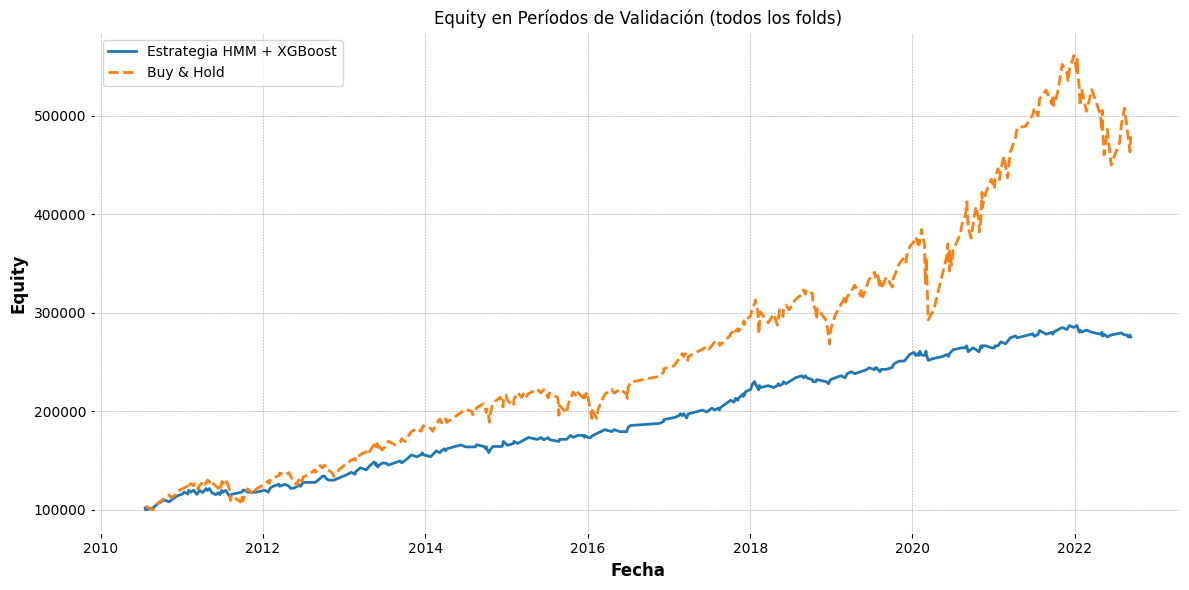

In [ ]:
# Ordenar por fecha y calcular equity acumulada de la estrategia
df_plot = df_global_bt.sort_values('Fecha_Cierre').copy()
df_plot['Equity_strategy'] = capital_inicial + df_plot['NetPnL'].cumsum()

# Calcular equity Buy & Hold sobre ese mismo período
prices = df_plot['Precio_Cierre']
rets   = prices.pct_change().dropna()
equity_bh = capital_inicial * (1 + rets).cumprod()
dates_bh  = df_plot['Fecha_Cierre'].iloc[1:]  # alinea con rets

# Graficar comparativo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_plot['Fecha_Cierre'], df_plot['Equity_strategy'],
        label='Estrategia HMM + XGBoost', linewidth=2)
ax.plot(dates_bh, equity_bh,
        label='Buy & Hold', linestyle='--', linewidth=2)

ax.set_title('Equity en Períodos de Validación (todos los folds)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Equity')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_metrics_bh = df_bh[['CAGR','Sharpe','Sortino','Calmar','HitRate']].copy()

# --- 2) Ahora compara fold a fold ---
metrics = ['CAGR','Sharpe', 'Sortino', 'Calmar', 'HitRate']
comp = pd.DataFrame(index=metrics, columns=['Wins', 'TotalFolds', 'Pct_Estrategia>BH'])

total_folds = len(df_metrics)

for m in metrics:
    wins = (df_metrics[m] > df_bh[m]).sum()
    comp.loc[m, 'Wins']              = wins
    comp.loc[m, 'TotalFolds']        = total_folds
    comp.loc[m, 'Pct_Estrategia>BH'] = wins / total_folds * 100

# Formatear el porcentaje como número (para Excel), pero también como string si lo prefieres
comp['Pct_Estrategia>BH'] = comp['Pct_Estrategia>BH'].astype(float)
comp_formatted = comp.copy()
comp_formatted['Pct_Estrategia>BH'] = comp_formatted['Pct_Estrategia>BH'].map("{:.1f}%".format)

print("\nComparación fold a fold de Estrategia vs Buy & Hold:")
print(comp_formatted)

# Guardar tabla en Excel
comp.to_excel('comparacion_estrategia_vs_buyhold.xlsx')


Comparación fold a fold de Estrategia vs Buy & Hold:
        Wins TotalFolds Pct_Estrategia>BH
CAGR       5         10             50.0%
Sharpe     8         10             80.0%
Sortino   10         10            100.0%
Calmar     8         10             80.0%
HitRate   10         10            100.0%


**Crear una columna con el resultado real de la señal**

In [ ]:
# Asume que df_train['Señal'] ya está lleno.
# Resultado_Señal: 1 si la operación fue exitosa (Precio_Cierre siguiente > actual), 0 si no, np.nan si no hubo señal
df_train["Resultado_Señal"] = np.where(
    (df_train["Señal"] == 1) & (df_train["Precio_Cierre"].shift(-1) > df_train["Precio_Cierre"]),
    1,
    np.where((df_train["Señal"] == 1) & (df_train["Precio_Cierre"].shift(-1) <= df_train["Precio_Cierre"]), 0, np.nan)
)

**Analizar la relación probabilidad vs resultado**

                   count   mean    std    min    25%    50%    75%    max
Resultado_Señal                                                          
0.0000          123.0000 0.5851 0.0490 0.5101 0.5514 0.5654 0.6215 0.7503
1.0000          210.0000 0.5739 0.0485 0.5039 0.5430 0.5598 0.5914 0.7503


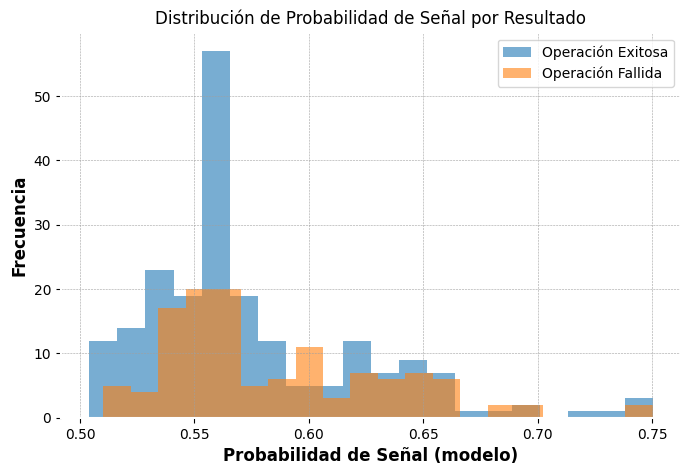

AUC (probabilidad de señal vs resultado): 0.427


In [ ]:
# Extrae sólo las filas con señales activas y resultado disponible
df_senal = df_train[df_train['Señal'] == 1].copy()
df_senal = df_senal[df_senal['Resultado_Señal'].notna()]

# Tabla: promedios de probabilidad según éxito
print(df_senal.groupby('Resultado_Señal')['Probabilidad_Señal'].describe())

# Gráfica: histogramas de probabilidad por resultado
plt.figure(figsize=(8,5))
plt.hist(df_senal.loc[df_senal['Resultado_Señal']==1, 'Probabilidad_Señal'], bins=20, alpha=0.6, label='Operación Exitosa')
plt.hist(df_senal.loc[df_senal['Resultado_Señal']==0, 'Probabilidad_Señal'], bins=20, alpha=0.6, label='Operación Fallida')
plt.xlabel('Probabilidad de Señal (modelo)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidad de Señal por Resultado')
plt.legend()
plt.show()

# (Opcional) Calcular AUC para discriminar resultados usando la probabilidad:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(df_senal['Resultado_Señal'], df_senal['Probabilidad_Señal'])
print(f"AUC (probabilidad de señal vs resultado): {auc:.3f}")

        prob_bin  Promedio_Probabilidad  Tasa_Éxito  Cantidad_Senales
0  (-0.001, 0.1]                    NaN         NaN                 0
1     (0.1, 0.2]                    NaN         NaN                 0
2     (0.2, 0.3]                    NaN         NaN                 0
3     (0.3, 0.4]                    NaN         NaN                 0
4     (0.4, 0.5]                    NaN         NaN                 0
5     (0.5, 0.6]                 0.5529      0.6543               243
6     (0.6, 0.7]                 0.6381      0.5542                83
7     (0.7, 0.8]                 0.7410      0.7143                 7
8     (0.8, 0.9]                    NaN         NaN                 0
9     (0.9, 1.0]                    NaN         NaN                 0


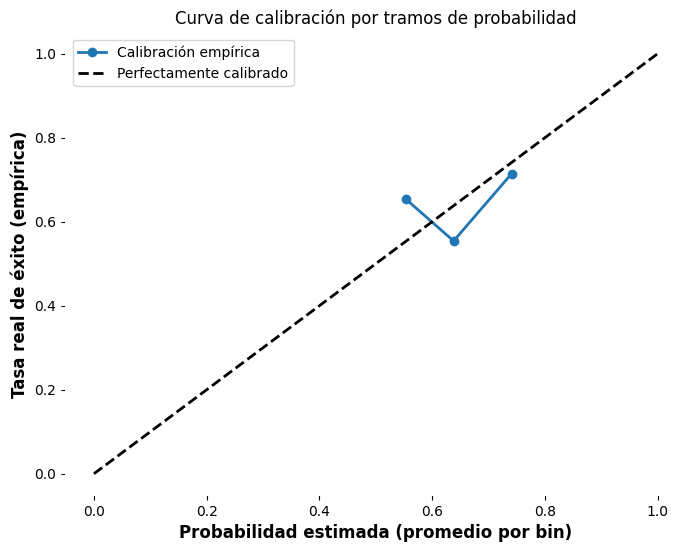

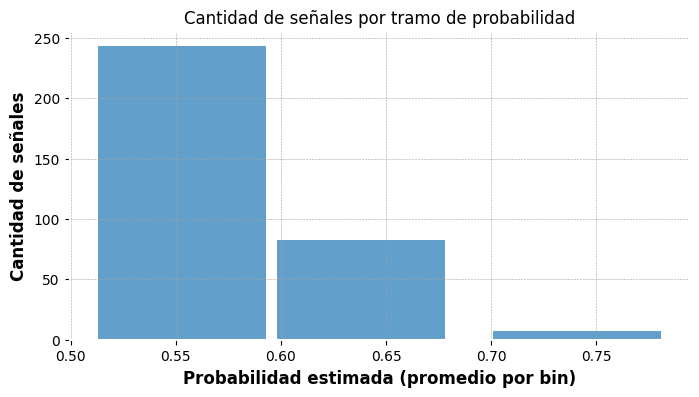

In [ ]:
# Parámetros: cantidad de bins (puedes ajustar)
n_bins = 10

# Crea los bins
df_senal['prob_bin'] = pd.cut(df_senal['Probabilidad_Señal'], bins=np.linspace(0, 1, n_bins+1), include_lowest=True)

# Calcula métrica por bin
calibration = df_senal.groupby('prob_bin').agg(
    Promedio_Probabilidad=('Probabilidad_Señal', 'mean'),
    Tasa_Éxito=('Resultado_Señal', 'mean'),
    Cantidad_Senales=('Resultado_Señal', 'count')
).reset_index()

print(calibration)

# Gráfica: calibración
plt.figure(figsize=(8,6))
plt.plot(calibration['Promedio_Probabilidad'], calibration['Tasa_Éxito'], 'o-', label='Calibración empírica')
plt.plot([0,1], [0,1], 'k--', label='Perfectamente calibrado')
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Tasa real de éxito (empírica)')
plt.title('Curva de calibración por tramos de probabilidad')
plt.legend()
plt.grid()
plt.show()

# (Opcional) Histograma de la cantidad de señales por bin
plt.figure(figsize=(8,4))
plt.bar(calibration['Promedio_Probabilidad'], calibration['Cantidad_Senales'], width=0.08, alpha=0.7)
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Cantidad de señales')
plt.title('Cantidad de señales por tramo de probabilidad')
plt.show()

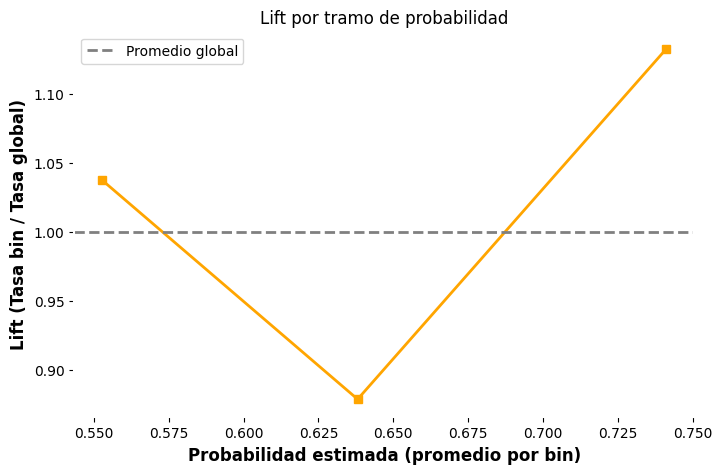

In [ ]:
tasa_global = df_senal['Resultado_Señal'].mean()
calibration['Lift'] = calibration['Tasa_Éxito'] / tasa_global

plt.figure(figsize=(8,5))
plt.plot(calibration['Promedio_Probabilidad'], calibration['Lift'], 's-', color='orange')
plt.axhline(1, color='grey', linestyle='--', label='Promedio global')
plt.xlabel('Probabilidad estimada (promedio por bin)')
plt.ylabel('Lift (Tasa bin / Tasa global)')
plt.title('Lift por tramo de probabilidad')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Usar 'Objetivo' como tasa de acierto potencial si se hubiera operado en todos los eventos descartados
eventos_señalizados = df_train[df_train['Señal'] == 1]
eventos_descartados = df_train[df_train['Señal'] == 0]

# Usar la variable 'Objetivo' como "acierto" potencial
tasa_acierto_señalizados   = eventos_señalizados['Objetivo'].mean()
tasa_acierto_descartados   = eventos_descartados['Objetivo'].mean()
cantidad_señalizados       = len(eventos_señalizados)
cantidad_descartados       = len(eventos_descartados)

print(f"Cantidad de eventos señalizados: {cantidad_señalizados}")
print(f"Cantidad de eventos descartados: {cantidad_descartados}")
print(f"Tasa de acierto (señalizados):   {tasa_acierto_señalizados:.2%}")
print(f"Tasa de acierto (descartados):   {tasa_acierto_descartados:.2%}")

Cantidad de eventos señalizados: 334
Cantidad de eventos descartados: 66
Tasa de acierto (señalizados):   62.87%
Tasa de acierto (descartados):   36.36%


**Señales Aleatorias 1000 Veces sobre Validación**

Resultados promedio de señales aleatorias (1000 simulaciones):
CAGR            0.0606
Sharpe          0.8141
Sortino         3.6847
MDD            -0.1120
Calmar          0.5716
HitRate         0.5866
ProfitFactor    1.3699
TUW             0.7920
dtype: float64

P-values (probabilidad de que la estrategia aleatoria iguale o supere a tu modelo):
CAGR:         0.000
Sharpe:       0.000
Sortino:      0.280
MDD:          0.003
Calmar:       0.001
HitRate:      0.000
ProfitFactor: 0.000
TUW:          0.001


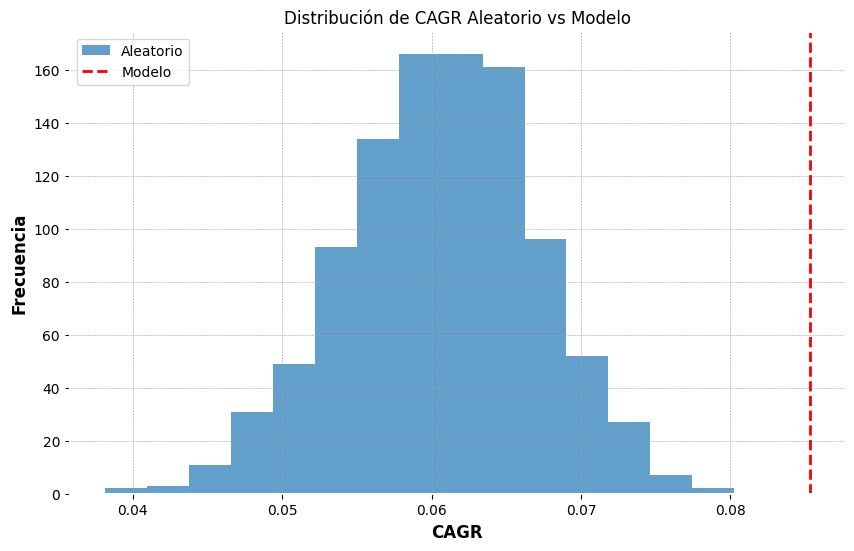

In [ ]:
# Asegúrate de tener estos parámetros definidos igual que en tu modelo real
capital_inicial      = 100_000.0
riesgo_pct           = 0.02
spread               = 0.01
comision_por_accion  = 0.001

# Limitar la muestra solo a las filas de validación (últimas 400 filas)
idx_val = df_train.index[-400:]

# Número de señales a simular (igual que las del modelo real en validación)
n_signals = int((df_train.loc[idx_val, 'Señal'] == 1).sum())

# Extraer una copia del DataFrame de validación
df_val = df_train.loc[idx_val].copy()

# Almacenar los resultados
metrics_list = ['CAGR','Sharpe','Sortino','MDD','Calmar','HitRate','ProfitFactor','TUW']
random_metrics = {k: [] for k in metrics_list}

n_simulaciones = 1000

for sim in range(n_simulaciones):
    np.random.seed(sim + 42)  # Distinto seed por simulación
    # Asignar señales aleatorias SOLO en la ventana de validación
    signal = np.zeros(len(df_val))
    random_idx = np.random.choice(df_val.index, size=n_signals, replace=False)
    signal[df_val.index.get_indexer(random_idx)] = 1
    df_val['Signal'] = signal

    # Backtest
    df_bt_random = ejecutar_backtest(
        df_val,
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
    )
    equity = df_bt_random['Equity']
    fechas = pd.to_datetime(df_bt_random['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0: anios = 1/365.25

    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt_random[df_bt_random['Shares'] > 0]
    if len(df_trades) > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt_random['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    # Guardar resultados
    random_metrics['CAGR'].append(cagr)
    random_metrics['Sharpe'].append(sharpe)
    random_metrics['Sortino'].append(sortino)
    random_metrics['MDD'].append(mdd)
    random_metrics['Calmar'].append(calmar)
    random_metrics['HitRate'].append(hit_rate)
    random_metrics['ProfitFactor'].append(profit_factor)
    random_metrics['TUW'].append(tuw)

# Convertir a DataFrame
df_rand_results = pd.DataFrame(random_metrics)

# Valores reales de tu modelo (en validación)

cagr_real = 0.0853
sharpe_real = 1.38
sortino_real = 4.00
mdd_real = -0.0652
calmar_real = 1.31
hit_rate_real = 0.6369
profit_factor_real = 1.7
tuw_real = 0.6949

# Calcular p-values (proporción de veces que el aleatorio >= modelo)
def pvalue(dist, valor_real, higher_better=True):
    if higher_better:
        return np.mean(np.array(dist) >= valor_real)
    else:
        return np.mean(np.array(dist) <= valor_real)

pvalue_mdd = np.mean(np.array(df_rand_results['MDD']) >= mdd_real)

print("Resultados promedio de señales aleatorias (1000 simulaciones):")
print(df_rand_results.mean())

print("\nP-values (probabilidad de que la estrategia aleatoria iguale o supere a tu modelo):")
print(f"CAGR:         {pvalue(df_rand_results['CAGR'], cagr_real, higher_better=True):.3f}")
print(f"Sharpe:       {pvalue(df_rand_results['Sharpe'], sharpe_real, higher_better=True):.3f}")
print(f"Sortino:      {pvalue(df_rand_results['Sortino'], sortino_real, higher_better=True):.3f}")
print(f"MDD:          {pvalue_mdd:.3f}")
print(f"Calmar:       {pvalue(df_rand_results['Calmar'], calmar_real, higher_better=True):.3f}")
print(f"HitRate:      {pvalue(df_rand_results['HitRate'], hit_rate_real, higher_better=True):.3f}")
print(f"ProfitFactor: {pvalue(df_rand_results['ProfitFactor'], profit_factor_real, higher_better=True):.3f}")
print(f"TUW:          {pvalue(df_rand_results['TUW'], tuw_real, higher_better=False):.3f}")

# (Opcional) Graficar las distribuciones de resultados aleatorios vs. tu sistema real
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_rand_results['CAGR'], bins=15, alpha=0.7, label='Aleatorio')
plt.axvline(cagr_real, color='r', linestyle='--', label='Modelo')
plt.xlabel('CAGR')
plt.ylabel('Frecuencia')
plt.title('Distribución de CAGR Aleatorio vs Modelo')
plt.legend()
plt.show()

**Verificación del 2% del Capital Inicial Fijo**

In [ ]:
# dfg debe tener las columnas: 'Fecha_Cierre', 'Equity_global', 'Shares', 'EntryPrice'
# Calcula la exposición para cada operación
dfg['Exposicion'] = dfg['Shares'] * dfg['EntryPrice']

# Calcula el límite de equity disponible en cada momento (2x el equity global)
dfg['Limite_Equity'] = 2 * dfg['Equity_global']

# Busca los eventos donde se supera el límite
exceso = dfg[dfg['Exposicion'] > dfg['Limite_Equity']]

if not exceso.empty:
    print("¡Alerta! Se superó el equity máximo permitido en las siguientes operaciones:")
    print(exceso[['Fecha_Cierre', 'Exposicion', 'Limite_Equity']])
else:
    print("La estrategia NUNCA supera el equity máximo permitido (2x equity global) en ninguna operación.")

La estrategia NUNCA supera el equity máximo permitido (2x equity global) en ninguna operación.


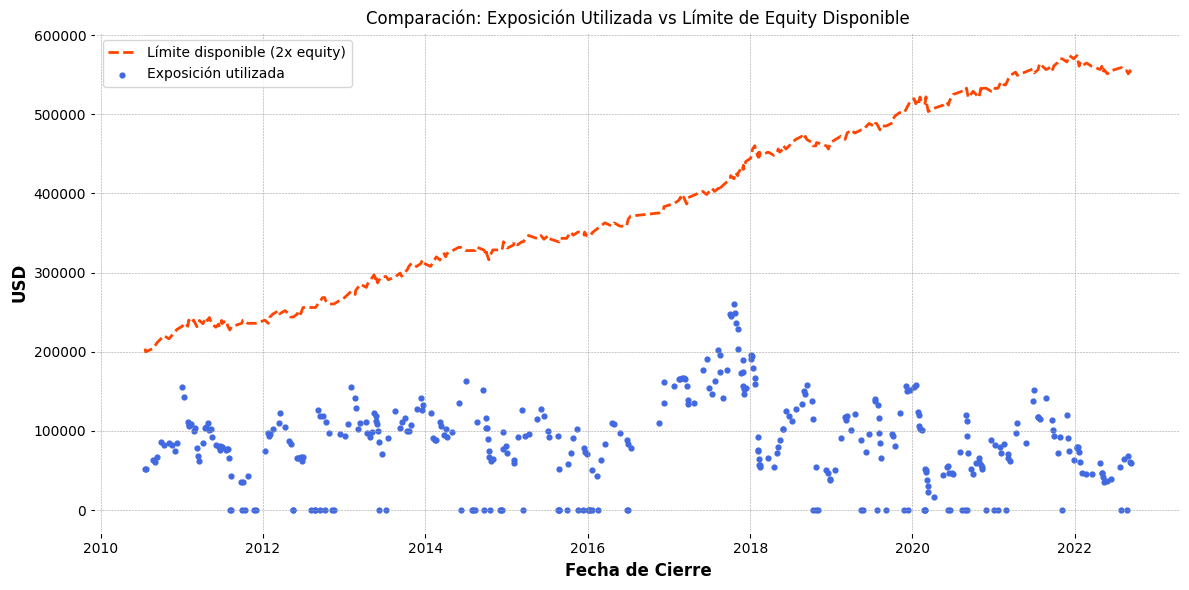

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dfg['Fecha_Cierre'], dfg['Limite_Equity'], label='Límite disponible (2x equity)', color='orangered', linestyle='--')
plt.scatter(dfg['Fecha_Cierre'], dfg['Exposicion'], label='Exposición utilizada', color='royalblue', s=12)

plt.xlabel('Fecha de Cierre')
plt.ylabel('USD')
plt.title('Comparación: Exposición Utilizada vs Límite de Equity Disponible')
plt.legend()
plt.tight_layout()
plt.show()

## Probabilistic Sharpe Ratio

In [ ]:
from scipy.stats import norm

def probabilistic_sharpe_ratio(SR_observed, SR_benchmark, returns, periods_per_year=None):
    """
    Calcula el PSR: probabilidad de que el Sharpe real supere a SR_benchmark
    Basado en Bailey & López de Prado (2012), Eq. 18 y 19.

    - SR_observed: Sharpe Ratio de la estrategia evaluada
    - SR_benchmark: Sharpe Ratio de referencia (ej: Buy & Hold, o 0)
    - returns: Serie de retornos periódicos (pueden ser diarios, o de evento)
    - periods_per_year: eventos por año (para anualizar, opcional)
    """
    n = len(returns)
    mean = np.mean(returns)
    std  = np.std(returns, ddof=0)
    skew = ((returns - mean)**3).mean() / (std**3) if std > 0 else 0
    kurt = ((returns - mean)**4).mean() / (std**4) if std > 0 else 3

    # Si periods_per_year no está especificado, lo estimo por la frecuencia
    if periods_per_year is None:
        periods_per_year = 252 if n > 250 else 12 if n < 50 else n/(returns.index[-1] - returns.index[0]).days * 365.25

    # Bailey-López de Prado Eq.19
    numerator = SR_observed - SR_benchmark
    denominator = np.sqrt(
        (1 - skew * SR_observed + 0.25 * (kurt - 1) * SR_observed**2) / (n - 1)
    )
    psr = norm.cdf(numerator / denominator)
    return psr

# --- CALCULO PSR GLOBAL DE TU ESTRATEGIA VS BUY & HOLD ---

# Tu serie de retornos globales de la estrategia (ya la tienes como rets_g)
rets_global = rets_g

# Tu Sharpe global
sharpe_strat = sharpe_g

# Sharpe global del Buy & Hold (ya lo tienes en sharpe_g de ese bloque, o asignalólo explícitamente)
sharpe_bh = sharpe_g  # <-- Ajusta si lo tienes con otro nombre

# Calcular PSR (probabilidad de que el Sharpe real de tu estrategia supere el BH)
psr = probabilistic_sharpe_ratio(
    SR_observed = sharpe_strat,
    SR_benchmark = sharpe_bh,
    returns = rets_global
)

print(f"Probabilistic Sharpe Ratio (PSR) vs BH: {psr:.4f}")

# Opcional: PSR vs. cero
psr_vs_0 = probabilistic_sharpe_ratio(
    SR_observed = sharpe_strat,
    SR_benchmark = 0.0,
    returns = rets_global
)
print(f"Probabilistic Sharpe Ratio (PSR) vs 0: {psr_vs_0:.4f}")

Probabilistic Sharpe Ratio (PSR) vs BH: 0.5000
Probabilistic Sharpe Ratio (PSR) vs 0: 1.0000


In [ ]:
# Generar la curva de equity diaria interpolada

# --- Supón que dfg tiene las columnas: 'Fecha_Cierre', 'Equity_global'
dfg = dfg.sort_values("Fecha_Cierre").copy()
dfg['Fecha_Cierre'] = pd.to_datetime(dfg['Fecha_Cierre'])
dfg = dfg.set_index('Fecha_Cierre')

# --- Fechas diarias del benchmark (por ejemplo, de precios_glob)
fechas_diarias = pd.date_range(start=dfg.index.min(), end=dfg.index.max(), freq='B')  # 'B' = business day

# --- Interpolamos el equity para cada día hábil
equity_diaria = dfg['Equity_global'].reindex(fechas_diarias, method='ffill')

# --- Si hay días previos sin trade, puede que queden NaN al principio: rellena con el capital inicial
equity_diaria = equity_diaria.fillna(capital_inicial)

In [ ]:
# Calcula los retornos diarios y las métricas

rets_diarios = equity_diaria.pct_change().dropna()
years_glob = (fechas_diarias[-1] - fechas_diarias[0]).days / 365.25
events_per_year_glob = len(rets_diarios) / years_glob

mean_ret_glob = rets_diarios.mean()
std_ret_glob = rets_diarios.std(ddof=0)
sharpe_glob = (mean_ret_glob / std_ret_glob) * np.sqrt(events_per_year_glob) if std_ret_glob > 0 else np.nan

neg_rets_glob = rets_diarios[rets_diarios < 0]
sortino_glob = (mean_ret_glob / neg_rets_glob.std(ddof=0)) * np.sqrt(events_per_year_glob) if len(neg_rets_glob) > 0 else np.nan

running_max_glob = equity_diaria.cummax()
drawdowns_glob = equity_diaria / running_max_glob - 1
mdd_glob = drawdowns_glob.min()
cagr_glob = (equity_diaria.iloc[-1] / equity_diaria.iloc[0]) ** (1 / years_glob) - 1
calmar_glob = cagr_glob / abs(mdd_glob) if mdd_glob < 0 else np.nan

print(f"\n=== Métricas Globales (curva diaria interpolada) ===")
print(f"Total Return       : {equity_diaria.iloc[-1] / equity_diaria.iloc[0] - 1:.2%}")
print(f"CAGR               : {cagr_glob:.2%}")
print(f"Sharpe             : {sharpe_glob:.2f}")
print(f"Sortino            : {sortino_glob:.2f}")
print(f"MDD                : {mdd_glob:.2%}")
print(f"Calmar             : {calmar_glob:.2f}")


=== Métricas Globales (curva diaria interpolada) ===
Total Return       : 170.22%
CAGR               : 8.53%
Sharpe             : 1.35
Sortino            : 1.40
MDD                : -6.52%
Calmar             : 1.31


In [ ]:
# Calcular el PSR ahora sí, 100% comparable

def probabilistic_sharpe_ratio(sharpe_model, sharpe_benchmark, n):
    # n: número de retornos (eventos diarios)
    # Fórmula de Bailey & López de Prado
    psr = norm.cdf((sharpe_model - sharpe_benchmark) * np.sqrt(n - 1) / np.sqrt(1 - sharpe_model**2 / 4))
    return psr

n_diarios = len(rets_diarios)
psr_bh = probabilistic_sharpe_ratio(sharpe_model=sharpe_glob, sharpe_benchmark=sharpe_bh, n=n_diarios)
psr_0  = probabilistic_sharpe_ratio(sharpe_model=sharpe_glob, sharpe_benchmark=0.0, n=n_diarios)
print(f"PSR vs BH diario: {psr_bh:.4f}")
print(f"PSR vs 0:         {psr_0:.4f}")

PSR vs BH diario: 1.0000
PSR vs 0:         1.0000


## Nuevo Dimensionamiento de Posición

In [ ]:
# ==============================
# Pipeline con entrenamiento manual + métrica económica personalizada
# con dimensionado por riesgo (ratchet) y cap de exposición
# ==============================
import xgboost as xgb

# ---------- Interruptores ----------
USE_FILTER = False          # <- activar/desactivar filtro A/B reciente
USE_ALL_FEATURES = False    # <- True: static_feats + HMM; False: solo static_feats

# ---------- Parámetros del modelo ----------
xgb_params = {
    'objective':        'binary:logistic',
    'learning_rate':    0.1,
    'max_depth':        4,
    'min_child_weight': 2,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'gamma':            0.1,
    'reg_alpha':        0.1,
    'reg_lambda':       1.5,
    'eval_metric':      'logloss',   # métrica base interna (no usada para ES)
    'seed':             42,
}
num_boost_round       = 300
early_stopping_rounds = 30
maximize_metric       = True         # nuestra métrica económica se maximiza
threshold             = 0.5

# ---------- Trading / backtest ----------
capital_inicial      = 100_000.0
riesgo_pct           = 0.02          # 2% sobre high-water equity
spread               = 0.01
comision_por_accion  = 0.001

# Cap y discretización de la posición
MAX_LEVERAGE = 2.0     # Exposición máxima = 2x equity dinámico
ROUND_SHARES = False   # Si quieres redondear acciones a lotes
LOT_SIZE     = 1

# ---------- Features ----------
static_feats = ['VIX_Open','Retornos_10']
n_states = 4  # coherente con los HMM usados

# ---------- Salidas en df principal ----------
df_train["Señal"] = np.nan
df_train["Probabilidad_Señal"] = np.nan

metrics      = []
df_global_bt = pd.DataFrame()

# ---------- Helpers ----------
def sel(df, idx):
    """Selector robusto compatible con folds posicionales/etiquetas."""
    if 'to_positional_indexer' in globals():
        try:
            pos = to_positional_indexer(idx, df)
            return df.iloc[pos]
        except Exception:
            return df.loc[idx]
    else:
        return df.loc[idx]

def ensure_all_dummy_cols(dfX, prefix, n_states):
    """Garantiza columnas dummy 0..n_states-1 y orden consistente."""
    for s in range(n_states):
        col = f"{prefix}_{s}"
        if col not in dfX.columns:
            dfX[col] = 0
    dummy_cols = [f"{prefix}_{s}" for s in range(n_states)]
    other_cols = [c for c in dfX.columns if c not in dummy_cols]
    return dfX[other_cols + dummy_cols]

# ---------- Métrica económica personalizada (Sortino-like@0.5) ----------
def econ_sortino_like_at_05_score(y_pred, y_true):
    """
    - Operamos si y_pred >= 0.5
    - Payoff simétrico por trade: +1 (acierta) / -1 (falla)
    - Métrica: mean(payoff) / std(negativos)  (fallback: std global si no hay suficientes negativos)
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    signal = (y_pred >= 0.5).astype(np.float64)
    payoff = np.where(signal > 0, np.where(y_true > 0.5, 1.0, -1.0), np.nan)
    trades = payoff[~np.isnan(payoff)]

    if trades.size == 0:
        return 0.0

    mean_ = trades.mean()
    neg   = trades[trades < 0]
    if neg.size > 1:
        denom = neg.std(ddof=0)
    else:
        sd = trades.std(ddof=0)
        denom = sd if sd > 0 else 1.0

    return float(mean_ / (denom + 1e-12))

# ---------- Entrenamiento manual con early stopping por métrica económica ----------
def train_with_custom_metric(params, dtrain, dvalid, y_valid,
                             num_boost_round=200, early_stopping_rounds=20,
                             maximize=True, verbose=False):
    """
    Entrenamiento 'a mano':
      - booster.update(...) por ronda
      - predicción en valid -> métrica económica
      - tracking del mejor modelo + early stopping
    Devuelve: booster_best, best_iteration, best_score
    """
    booster = xgb.Booster(params=params, cache=[dtrain])
    best_score = -np.inf if maximize else np.inf
    best_iter  = -1
    best_model = None
    rounds_since_best = 0

    for r in range(num_boost_round):
        booster.update(dtrain, r)
        y_pred = booster.predict(dvalid)
        score = econ_sortino_like_at_05_score(y_pred, y_valid)

        improved = (score > best_score) if maximize else (score < best_score)
        if improved:
            best_score = score
            best_iter  = r
            best_model = booster.copy()  # snapshot del booster
            rounds_since_best = 0
        else:
            rounds_since_best += 1

        if verbose and (r % 10 == 0 or improved):
            print(f"[round {r}] econ_sortino@0.5={score:.6f} | best={best_score:.6f} (iter {best_iter})")

        if rounds_since_best >= early_stopping_rounds:
            if verbose:
                print(f"Early stopping en ronda {r} (best_iter={best_iter}, best_score={best_score:.6f})")
            break

    if best_model is None:
        best_model = booster
        best_iter  = r
        best_score = econ_sortino_like_at_05_score(booster.predict(dvalid), y_valid)

    return best_model, best_iter, best_score

# ---------- Backtest con ratchet + cap de exposición ----------
def ejecutar_backtest_ratchet(
    df,
    signal_col='Signal',
    capital_inicial=100_000.0,
    riesgo_pct=0.02,
    spread=0.01,
    comision_por_accion=0.001,
    max_leverage=2.0,
    round_shares=False,
    lot_size=1
):
    df = df.copy().reset_index(drop=True)
    df['EntryPrice'] = df['Precio_Cierre']
    df['ExitPrice']  = df['Precio_Cierre'].shift(-1)

    eps = 1e-12
    high_water_equity = float(capital_inicial)
    equity            = float(capital_inicial)
    out = []

    for _, row in df.iterrows():
        entry = float(row['EntryPrice'])
        exitp = float(row['ExitPrice']) if pd.notna(row['ExitPrice']) else np.nan
        sl    = float(row['SL']) if 'SL' in row and pd.notna(row['SL']) else np.nan

        opened = (row[signal_col] == 1) and (not np.isnan(exitp))
        shares = 0.0
        net_pnl = 0.0
        cap_applied = 0
        cap_factor  = 1.0
        exposicion  = 0.0
        limite_eq   = max_leverage * equity

        if opened:
            # Dimensionado por riesgo (sobre high-water mark)
            riesgo_abs = high_water_equity * float(riesgo_pct)
            riesgo_por_accion = abs(entry - sl) if pd.notna(sl) else 0.0
            if riesgo_por_accion <= eps:
                riesgo_por_accion = eps

            shares_risk = riesgo_abs / riesgo_por_accion
            exposicion_obj = shares_risk * entry

            # Cap de exposición: Exposicion <= max_leverage * equity
            if exposicion_obj > limite_eq + eps:
                cap_factor = (limite_eq / exposicion_obj) if exposicion_obj > 0 else 0.0
                shares = max(0.0, shares_risk * cap_factor)
                cap_applied = 1
            else:
                shares = max(0.0, shares_risk)

            if round_shares:
                shares = np.floor(shares / lot_size) * lot_size
                shares = max(0.0, shares)

            exposicion = shares * entry
            gross_pnl  = shares * (exitp - entry)
            cost       = shares * (float(spread) + float(comision_por_accion))
            net_pnl    = gross_pnl - cost

        equity += net_pnl
        if equity > high_water_equity:
            high_water_equity = equity

        out.append({
            'Fecha_Cierre':   row['Fecha_Cierre'],
            'EntryPrice':     entry,
            'ExitPrice':      exitp,
            'SL':             sl,
            'Shares':         shares,
            'NetPnL':         net_pnl,
            'Equity':         equity,
            'Exposicion':     exposicion,
            'Limite_Equity':  limite_eq,
            'CapApplied':     cap_applied,
            'CapFactor':      cap_factor
        })

    bt = pd.DataFrame(out)

    # Verificación post-cap (seguridad)
    exceso = bt[bt['Exposicion'] > bt['Limite_Equity'] + 1e-8]
    if not exceso.empty:
        print("¡Alerta! Exceso de exposición detectado (post-cap). Ejemplos:")
        print(exceso[['Fecha_Cierre','Exposicion','Limite_Equity','Shares','EntryPrice']].head(10))

    return bt

# ==============================
# Bucle principal por fold
# ==============================
for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    hmm_col  = f'HMM_state_fold{i}'   # estados categóricos del fold (0..n_states-1)
    colA     = f'FiltroA_fold{i}'     # umbral A reciente (constante en el fold)
    colB     = f'FiltroB_fold{i}'     # umbral B reciente (constante en el fold)
    prefix   = f'HMM_s{i}'

    # ======== Selección de features ========
    if USE_ALL_FEATURES:
        feats = static_feats + [hmm_col]
    else:
        feats = static_feats[:]

    # =========================
    # Preparar TRAIN
    # =========================
    df_tr = sel(df_train, idx_tr)[feats + ['Objetivo']].copy()

    if USE_ALL_FEATURES:
        if hmm_col not in df_tr.columns:
            raise KeyError(f"Falta {hmm_col} en TRAIN para fold {i}. Genera primero los estados HMM.")
        df_tr[hmm_col] = pd.Categorical(df_tr[hmm_col], categories=list(range(n_states)))
        df_tr = pd.get_dummies(df_tr, columns=[hmm_col], prefix=prefix)
        df_tr = ensure_all_dummy_cols(df_tr, prefix, n_states)

    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo'].astype(float)

    # =========================
    # Preparar VALIDACIÓN
    # =========================
    cols_val = feats + ['Objetivo','Precio_Cierre','SL','Fecha_Cierre']
    if USE_FILTER:
        cols_val += [colA, colB]
    df_val = sel(df_train, idx_va)[cols_val].copy()

    if USE_ALL_FEATURES:
        if hmm_col not in df_val.columns:
            raise KeyError(f"Falta {hmm_col} en VALID para fold {i}.")
        df_val[hmm_col] = pd.Categorical(df_val[hmm_col], categories=list(range(n_states)))
        df_val = pd.get_dummies(df_val, columns=[hmm_col], prefix=prefix)
        df_val = ensure_all_dummy_cols(df_val, prefix, n_states)

    # Alinear columnas con TRAIN
    for col in X_tr.columns:
        if col not in df_val.columns:
            df_val[col] = 0
    X_va = df_val[X_tr.columns]
    y_va = df_val['Objetivo'].astype(float)

    # =========================
    # DMatrix y entrenamiento manual
    # =========================
    dtrain = xgb.DMatrix(X_tr.values, label=y_tr.values, feature_names=X_tr.columns.tolist())
    dvalid = xgb.DMatrix(X_va.values, label=y_va.values, feature_names=X_va.columns.tolist())

    booster, best_iteration, best_score = train_with_custom_metric(
        params=xgb_params,
        dtrain=dtrain,
        dvalid=dvalid,
        y_valid=y_va.values,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        maximize=maximize_metric,
        verbose=False
    )

    # =========================
    # Predicción y (opcional) filtro A/B
    # =========================
    y_prob = booster.predict(dvalid)
    y_pred_raw = (y_prob >= threshold).astype(int)

    if USE_FILTER:
        missing_cols_val = [c for c in [colA, colB] if c not in df_val.columns]
        if missing_cols_val:
            raise KeyError(f"Faltan columnas en VALID para fold {i}: {missing_cols_val}. "
                           f"Asegúrate de haber creado {colA}/{colB} previamente.")
        A_vals = df_val[colA].astype(float)
        B_vals = df_val[colB].astype(float)
        mask_valid_ab = A_vals.notna() & B_vals.notna()
        mask_ab = mask_valid_ab & (df_val['VIX_Open'] > A_vals) & (df_val['Retornos_10'] < B_vals)
        y_pred = np.where(mask_ab & (y_pred_raw == 1), 0, y_pred_raw).astype(int)
        df_val['Filtro_AB'] = mask_ab.astype(int)
        n_filtrados = int((mask_ab & (y_pred_raw == 1)).sum())
        print(f"[Fold {i}] Señales brutas: {int(y_pred_raw.sum())} | Filtradas A/B: {n_filtrados} | Señales finales: {int(y_pred.sum())}")
    else:
        y_pred = y_pred_raw.copy()
        df_val['Filtro_AB'] = 0
        print(f"[Fold {i}] (Filtro A/B DESACTIVADO) Señales: {int(y_pred.sum())}")

    # Auditoría
    df_val['Signal_raw'] = y_pred_raw
    df_val['Signal']     = y_pred
    df_val['Prob']       = y_prob

    # Asignar al df principal
    idx_va_index = sel(df_train, idx_va).index
    df_train.loc[idx_va_index, "Señal"] = y_pred
    df_train.loc[idx_va_index, "Probabilidad_Señal"] = y_prob

    # =========================
    # Backtest con dimensionado (ratchet) + cap de exposición
    # =========================
    df_bt = ejecutar_backtest_ratchet(
        df_val,
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion,
        max_leverage=MAX_LEVERAGE,
        round_shares=ROUND_SHARES,
        lot_size=LOT_SIZE
    )

    # ====== Consistencia: nº operaciones ======
    # Sólo pueden ejecutarse operaciones donde exista ExitPrice (shift -1 no NaN)
    posibles_ops = int(((df_val['Signal'] == 1) & df_val['Precio_Cierre'].shift(-1).notna()).sum())
    trades_bt    = int((df_bt['Shares'] > 0).sum())
    if posibles_ops != trades_bt:
        print(f"[Fold {i}] Aviso: señales ejecutables={posibles_ops} vs trades backtest={trades_bt}. "
              f"(La diferencia suele deberse al último evento del fold sin salida o a cap extremo.)")

    # =========================
    # Métricas del fold
    # =========================
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0:
        anios = 1/365.25

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt[df_bt['Shares'] > 0]
    num_trades = len(df_trades)
    if num_trades > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    metrics.append({
        'fold':            i,
        'TotalRet':        total_ret,
        'CAGR':            cagr,
        'Sharpe':          sharpe,
        'Sortino':         sortino,
        'MDD':             mdd,
        'Calmar':          calmar,
        'NumTrades':       num_trades,
        'HitRate':         hit_rate,
        'ProfitFactor':    profit_factor,
        'TUW':             tuw,
        'best_iteration':  best_iteration,
        'best_score_econ': best_score
    })

    # Verificación por fold: no exceder el límite (post-cap)
    exceso_fold = df_bt[df_bt['Exposicion'] > df_bt['Limite_Equity'] + 1e-8]
    if not exceso_fold.empty:
        print(f"[Fold {i}] ¡Alerta! Exceso de exposición (post-cap). Ejemplos:")
        print(exceso_fold[['Fecha_Cierre','Exposicion','Limite_Equity','Shares','EntryPrice']].head(10))

    df_global_bt = pd.concat([df_global_bt, df_bt], axis=0)

# ---------- Métricas por fold ----------
df_metrics = pd.DataFrame(metrics).set_index('fold')
print("=== Métricas por Fold ===")
print(df_metrics[['TotalRet','CAGR','Sharpe','Sortino','MDD','Calmar','NumTrades','HitRate','ProfitFactor','TUW','best_iteration','best_score_econ']])
df_metrics.to_excel('metricas_xgboost_por_fold.xlsx')

# ---------- Métricas globales ----------
dfg = df_global_bt.sort_values('Fecha_Cierre').copy()
dfg['Equity_global'] = capital_inicial + dfg['NetPnL'].cumsum()

# Chequeo global (post-cap)
exceso_global = dfg[dfg['Exposicion'] > dfg['Limite_Equity'] + 1e-8]
if not exceso_global.empty:
    print("¡Alerta GLOBAL! Exceso de exposición (post-cap). Ejemplos:")
    print(exceso_global[['Fecha_Cierre','Exposicion','Limite_Equity','Shares','EntryPrice']].head(10))
else:
    print("Verificación global OK: nunca se supera el límite de exposición (post-cap).")

# Exposición promedio
exposicion_prom_g = dfg['Exposicion'].mean()
exposicion_prom_pct = exposicion_prom_g / capital_inicial

equity_g    = dfg['Equity_global']
start_g     = pd.to_datetime(dfg['Fecha_Cierre'].iloc[0])
end_g       = pd.to_datetime(dfg['Fecha_Cierre'].iloc[-1])
years_g     = (end_g - start_g).days / 365.25 or (1/365.25)
total_ret_g = equity_g.iloc[-1] / equity_g.iloc[0] - 1
rets_g            = equity_g.pct_change().dropna()
events_per_year_g = len(rets_g) / years_g
mean_ret_g        = rets_g.mean()
std_ret_g         = rets_g.std(ddof=0)
sharpe_g          = (mean_ret_g / std_ret_g) * np.sqrt(events_per_year_g) if std_ret_g>0 else np.nan
neg_rets_g        = rets_g[rets_g < 0]
sortino_g         = (mean_ret_g / neg_rets_g.std(ddof=0)) * np.sqrt(events_per_year_g) if len(neg_rets_g)>0 else np.nan
cagr_g        = (equity_g.iloc[-1] / equity_g.iloc[0])**(1/years_g) - 1
running_max_g = equity_g.cummax()
drawdowns_g   = equity_g / running_max_g - 1
mdd_g         = drawdowns_g.min()
calmar_g      = cagr_g / abs(mdd_g) if mdd_g<0 else np.nan
df_trades_g      = dfg[dfg['Shares'] > 0]
hit_rate_g       = (df_trades_g['NetPnL'] > 0).mean() if len(df_trades_g)>0 else np.nan
wins_g           = df_trades_g['NetPnL'][df_trades_g['NetPnL']>0].sum() if len(df_trades_g)>0 else 0.0
loses_g          = -df_trades_g['NetPnL'][df_trades_g['NetPnL']<0].sum() if len(df_trades_g)>0 else 0.0
profit_factor_g  = wins_g / loses_g if loses_g>0 else np.nan
tuw_g            = (equity_g < running_max_g).mean()

# Eficiencia del capital
eficiencia_capital = cagr_g / exposicion_prom_pct if exposicion_prom_pct > 0 else np.nan

print("\n=== Métricas Globales ===")
print(f"Total Return global      : {total_ret_g:.2%}")
print(f"CAGR global              : {cagr_g:.2%}")
print(f"Sharpe global            : {sharpe_g:.2f}")
print(f"Sortino global           : {sortino_g:.2f}")
print(f"MDD global               : {mdd_g:.2%}")
print(f"Calmar global            : {calmar_g:.2f}")
print(f"Hit-Rate global          : {hit_rate_g:.2%}")
print(f"Profit Factor global     : {profit_factor_g:.2f}")
print(f"Time Under Water global  : {tuw_g:.2%}")
print(f"\n--- Exposición Promedio del Capital ---")
print(f"Exposición promedio      : ${exposicion_prom_g:,.2f} ({exposicion_prom_pct:.2%} del capital inicial)")
print(f"Eficiencia del capital   : {eficiencia_capital:.2%}")

resultados_globales = pd.DataFrame({
    'TotalRet_global': [total_ret_g],
    'CAGR_global': [cagr_g],
    'Sharpe_global': [sharpe_g],
    'Sortino_global': [sortino_g],
    'MDD_global': [mdd_g],
    'Calmar_global': [calmar_g],
    'HitRate_global': [hit_rate_g],
    'ProfitFactor_global': [profit_factor_g],
    'TUW_global': [tuw_g],
    'Exposicion_promedio': [exposicion_prom_g],
    'Exposicion_promedio_pct': [exposicion_prom_pct],
    'Eficiencia_capital': [eficiencia_capital]
})
resultados_globales.to_excel('metricas_xgboost_global.xlsx', index=False)

[Fold 1] (Filtro A/B DESACTIVADO) Señales: 40
[Fold 2] (Filtro A/B DESACTIVADO) Señales: 25
[Fold 3] (Filtro A/B DESACTIVADO) Señales: 38
[Fold 4] (Filtro A/B DESACTIVADO) Señales: 30
[Fold 5] (Filtro A/B DESACTIVADO) Señales: 26
[Fold 6] (Filtro A/B DESACTIVADO) Señales: 40
[Fold 7] (Filtro A/B DESACTIVADO) Señales: 37
[Fold 8] (Filtro A/B DESACTIVADO) Señales: 31
[Fold 9] (Filtro A/B DESACTIVADO) Señales: 30
[Fold 10] (Filtro A/B DESACTIVADO) Señales: 37
=== Métricas por Fold ===
      TotalRet    CAGR  Sharpe  Sortino     MDD  Calmar  NumTrades  HitRate  \
fold                                                                          
1       0.1187  0.1139  0.9365  14.4756 -0.0793  1.4367         39   0.5897   
2       0.1753  0.1332  1.4387  20.9421 -0.0407  3.2731         24   0.6667   
3       0.3156  0.2404  2.1556  12.0915 -0.0514  4.6739         37   0.7027   
4       0.0940  0.0741  0.8696  10.1519 -0.0804  0.9212         29   0.5862   
5       0.2227  0.1342  1.9017  21.0960

# 5. Importancia de las características

**Economic Permutational Importance**

In [ ]:
# --- PERMUTATIONAL IMPORTANCE ECONÓMICA (solo VIX_Open y Retornos_10) ---
from xgboost import XGBClassifier

# Hiperparámetros coherentes con tu pipeline
params_pi = dict(xgb_params)                 # parte de los mismos hiperparámetros
params_pi.setdefault('n_estimators', num_boost_round)
params_pi.pop('eval_metric', None)           # lo maneja internamente XGBClassifier

N_REPEATS  = 10
SEED_BASE  = 42
metrics_list = ['Sharpe','Sortino','CAGR','MDD','HitRate']
perm_importances = {}

# Las únicas features del modelo
features = ['VIX_Open', 'Retornos_10']

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    # --- Entrenamiento en TRAIN ---
    X_tr = df_train.loc[idx_tr, features].copy()
    y_tr = df_train.loc[idx_tr, 'Objetivo'].astype(float).copy()

    model = XGBClassifier(**params_pi, random_state=SEED_BASE + i)
    model.fit(X_tr, y_tr)

    # --- Base en VALID ---
    cols_val = features + ['Precio_Cierre','SL','Fecha_Cierre']
    df_val_base = df_train.loc[idx_va, cols_val].copy()

    X_va = df_val_base[features].copy()
    y_prob = model.predict_proba(X_va)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    df_bt_base = ejecutar_backtest(
        df_val_base.assign(Signal=y_pred),
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
    )
    base_metrics = extraer_metricas(df_bt_base)  # (Sharpe, Sortino, CAGR, MDD, HitRate, ...)

    # Inicializar estructura de resultados por feature
    for feat in features:
        if feat not in perm_importances:
            perm_importances[feat] = {m: [] for m in metrics_list}

    # --- Permutaciones por feature ---
    for feat in features:
        drops_acum = {m: [] for m in metrics_list}

        for r in range(N_REPEATS):
            rng = np.random.default_rng(SEED_BASE + 1000*i + r)

            # Copias limpias para evitar fugas entre repeticiones
            X_perm = X_va.copy()
            X_perm[feat] = rng.permutation(X_perm[feat].values)

            y_prob_p = model.predict_proba(X_perm)[:, 1]
            y_pred_p = (y_prob_p >= threshold).astype(int)

            df_bt_perm = ejecutar_backtest(
                df_val_base.assign(Signal=y_pred_p),
                signal_col='Signal',
                capital_inicial=capital_inicial,
                riesgo_pct=riesgo_pct,
                spread=spread,
                comision_por_accion=comision_por_accion
            )
            perm_metrics = extraer_metricas(df_bt_perm)

            # Registrar caídas (base - permutado) para las 5 métricas
            for j, m in enumerate(metrics_list):
                drops_acum[m].append(base_metrics[j] - perm_metrics[j])

        # Promedio de caídas por métrica para este feature en este fold
        for m in metrics_list:
            perm_importances[feat][m].append(np.nanmean(drops_acum[m]))

# --- Agregar resultados a DataFrame (promedio final por feature) ---
features_list = list(perm_importances.keys())
df_imp = pd.DataFrame({
    m: [np.nanmean(perm_importances[f][m]) for f in features_list]
    for m in metrics_list
}, index=features_list)

# Orden opcional por importancia media (p.ej., Sharpe)
df_imp = df_imp.sort_values('Sharpe', ascending=False)

print("Importancia permutacional (media caída en cada métrica):")
print(df_imp)

# --- Guardar resultados en Excel ---
df_imp.to_excel("perm_importances.xlsx", index=True)
print("Archivo 'perm_importances.xlsx' guardado correctamente.")

Importancia permutacional (media caída en cada métrica):
             Sharpe  Sortino   CAGR     MDD  HitRate
Retornos_10  0.1803 117.4846 0.0220 -0.0015   0.0274
VIX_Open     0.1779 -23.7384 0.0184  0.0002   0.0215
Archivo 'perm_importances.xlsx' guardado correctamente.


Economic Permutational Importance: Mide el impacto de cada variable sobre métricas económicas finales (como Sharpe, CAGR), no solo sobre la precisión predictiva. Muestra que VIX_Open y Retornos_10 son críticos para el desempeño económico.

**Feature Importance**

Importancia promedio XGBoost:
       Feature  Importance
0     VIX_Open      0.5137
1  Retornos_10      0.4863


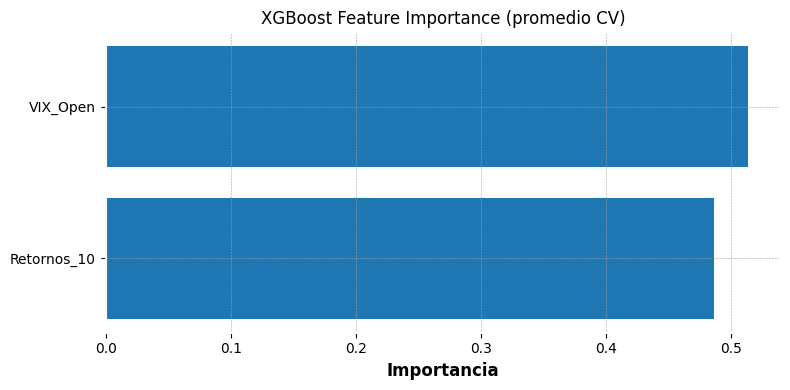

In [ ]:
# ============================
# Feature Importance (solo VIX_Open y Retornos_10)
# ============================

from xgboost import XGBClassifier

# Asegura hiperparámetros consistentes con tu pipeline
params_fi = dict(xgb_params)
params_fi.setdefault('n_estimators', num_boost_round)

features = ['VIX_Open', 'Retornos_10']
importances_fold = []
feature_names = features  # fijo y consistente en todos los folds

for i, (idx_tr, idx_va) in enumerate(folds, start=1):
    df_tr = df_train.loc[idx_tr, features + ['Objetivo']].copy()
    X_tr = df_tr[features]
    y_tr = df_tr['Objetivo'].astype(float)

    model = XGBClassifier(**params_fi, random_state=42 + i)
    model.fit(X_tr, y_tr)

    importances_fold.append(model.feature_importances_)

# Promedio por feature
importances_fold = np.vstack(importances_fold)  # shape: (n_folds, n_features)
importances_mean = importances_fold.mean(axis=0)

df_feat_imp = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances_mean})
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
)

print("Importancia promedio XGBoost:")
print(df_feat_imp)

# Gráfico
plt.figure(figsize=(8, 4))
plt.barh(df_feat_imp["Feature"], df_feat_imp["Importance"])
plt.title("XGBoost Feature Importance (promedio CV)")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Feature Importance (XGBoost): Una métrica más tradicional que mide la contribución a la reducción del error. También mostró que VIX_Open y Retornos_10 son las más relevantes.

**SHAP Values**

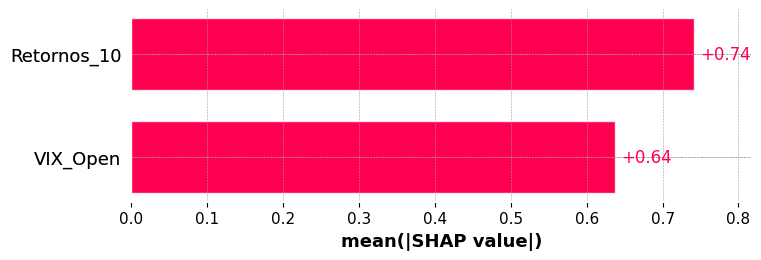

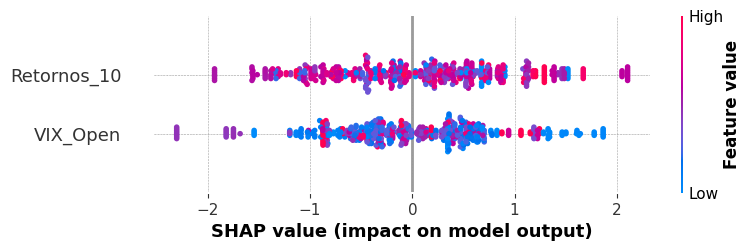

In [ ]:
# ============================
# SHAP values (solo VIX_Open y Retornos_10)
# ============================

import shap

# Último fold
idx_tr, idx_va = folds[-1]
features = ['VIX_Open', 'Retornos_10']

df_tr = df_train.loc[idx_tr, features + ['Objetivo']].copy()
X_tr = df_tr[features]
y_tr = df_tr['Objetivo'].astype(float)

params_shap = dict(xgb_params)
params_shap.setdefault('n_estimators', num_boost_round)

model = XGBClassifier(**params_shap, random_state=999)
model.fit(X_tr, y_tr)

# Explainer SHAP (API moderna); si tu entorno es antiguo, puedes usar TreeExplainer
explainer = shap.Explainer(model, X_tr)
sv = explainer(X_tr)  # sv.values: (n_samples, n_features)

# Summary bar
shap.plots.bar(sv, show=True)        # Importancia media absoluta

# Beeswarm (distribución por observación)
shap.plots.beeswarm(sv, show=True)

SHAP Values (SHapley Additive exPlanations): Herramienta que descompone la predicción de cada instancia en contribuciones de cada variable, ofreciendo interpretabilidad local y global. Confirma la influencia de Retornos_10 y VIX_Open.

# 6. Metamodelo

Un segundo nivel de decisión para filtrar las señales del modelo principal, usando proxies de variables económicas y fundamentales (como ETFs que representan mercados emergentes, bonos del Tesoro, oro, materias primas, bienes raíces y el dólar).

## Ingeniería de características

In [ ]:
tickers = ['EEM', 'TLT', 'GLD', 'DBC', 'USO', 'VNQ', 'UUP']

# --- Descargar precios ---
data_dict = {}
for ticker in tickers:
    print(f"Descargando {ticker}...")
    data = yf.download(ticker, start=df_train['Fecha_Cierre'].min(), end=df_train['Fecha_Cierre'].max(), progress=False)
    # Nos quedamos solo con Close
    data = data[['Close']].rename(columns={'Close': f'Close_{ticker}'})
    data.index = pd.to_datetime(data.index)
    data_dict[ticker] = data

df_prices = pd.concat(data_dict.values(), axis=1)
df_prices = df_prices.reindex(pd.to_datetime(df_train['Fecha_Cierre'])).ffill()

# --- Agregar precios y retornos a df_train ---
for ticker in tickers:
    # Agregar precios
    col_price = f'Close_{ticker}'
    df_train[col_price] = df_prices[col_price].values
    # Calcular retorno porcentual de 10 eventos previos
    df_train[f'Retornos_10_{ticker}'] = df_train[col_price].pct_change(periods=10)
    # Alternativamente, retorno logarítmico (descomentar si prefieres log)
    # df_train[f'Retornos_10_{ticker}'] = (np.log(df_train[col_price]) - np.log(df_train[col_price].shift(10)))

print("Muestra de df_train con precios y retornos de otros activos:")
display(df_train[[f'Close_{t}' for t in tickers] + [f'Retornos_10_{t}' for t in tickers]].tail())

Descargando EEM...
Descargando TLT...
Descargando GLD...
Descargando DBC...
Descargando USO...
Descargando VNQ...
Descargando UUP...
Muestra de df_train con precios y retornos de otros activos:


,Close_EEM,Close_TLT,Close_GLD,Close_DBC,Close_USO,Close_VNQ,Close_UUP,Retornos_10_EEM,Retornos_10_TLT,Retornos_10_GLD,Retornos_10_DBC,Retornos_10_USO,Retornos_10_VNQ,Retornos_10_UUP
895,36.6949,100.7856,161.6400,23.5559,74.6800,85.7543,26.0063,-0.0519,-0.0636,-0.0870,-0.0282,0.0004,-0.1051,0.0732
896,36.8897,100.8035,161.8600,24.3024,78.6900,83.4728,25.9796,-0.0525,-0.0330,-0.0678,-0.0333,0.0040,-0.0598,0.0516
897,35.5351,96.3638,158.3300,22.6565,71.4200,81.6670,26.3451,-0.1036,-0.0868,-0.0994,-0.1137,-0.1097,-0.1018,0.0773
898,36.1846,97.0990,159.8200,22.8364,71.1000,84.3977,26.0242,-0.0391,-0.0398,-0.0889,-0.1028,-0.1343,-0.0348,0.0534
899,36.1846,97.0990,159.8200,22.8364,71.1000,84.3977,26.0242,-0.0017,-0.0728,-0.0608,-0.0817,-0.1026,0.0226,0.0406


In [ ]:
for ticker in tickers:
    # Primer dato disponible en precios
    col_price = f'Close_{ticker}'
    first_price_idx = df_train[col_price].first_valid_index()
    first_price_date = df_train.loc[first_price_idx, 'Fecha_Cierre']
    print(f"Primer Close_{ticker}: idx={first_price_idx}, Fecha={first_price_date}")

    # Primer dato disponible en retornos
    col_ret = f'Retornos_10_{ticker}'
    first_ret_idx = df_train[col_ret].first_valid_index()
    first_ret_date = df_train.loc[first_ret_idx, 'Fecha_Cierre']
    print(f"Primer Retornos_10_{ticker}: idx={first_ret_idx}, Fecha={first_ret_date}\n")

Primer Close_EEM: idx=307, Fecha=2003-04-22 00:00:00
Primer Retornos_10_EEM: idx=317, Fecha=2003-10-03 00:00:00

Primer Close_TLT: idx=291, Fecha=2002-08-09 00:00:00
Primer Retornos_10_TLT: idx=301, Fecha=2003-02-06 00:00:00

Primer Close_GLD: idx=342, Fecha=2004-12-02 00:00:00
Primer Retornos_10_GLD: idx=352, Fecha=2005-04-07 00:00:00

Primer Close_DBC: idx=372, Fecha=2006-02-16 00:00:00
Primer Retornos_10_DBC: idx=382, Fecha=2006-09-26 00:00:00

Primer Close_USO: idx=374, Fecha=2006-04-11 00:00:00
Primer Retornos_10_USO: idx=384, Fecha=2006-10-16 00:00:00

Primer Close_VNQ: idx=336, Fecha=2004-10-04 00:00:00
Primer Retornos_10_VNQ: idx=346, Fecha=2005-02-02 00:00:00

Primer Close_UUP: idx=397, Fecha=2007-03-05 00:00:00
Primer Retornos_10_UUP: idx=407, Fecha=2007-06-07 00:00:00



In [ ]:
# Inicializa Objetivo_Señal con NaN
df_train["Objetivo_Señal"] = np.nan

# Vectorizado: donde Señal == 1, evaluamos el objetivo
mask_signal = df_train["Señal"] == 1
precio_cierre = df_train["Precio_Cierre"]
precio_cierre_sig = precio_cierre.shift(-1)

# Etiqueta como 1 si el precio siguiente es mayor, sino 0, solo para señales==1
df_train.loc[mask_signal, "Objetivo_Señal"] = (precio_cierre_sig > precio_cierre)[mask_signal].astype(int)

# Opcional: para ver el resultado
print(df_train[["Señal", "Precio_Cierre", "Objetivo_Señal"]].tail(10))

     Señal  Precio_Cierre  Objetivo_Señal
890 1.0000       391.7403          0.0000
891 1.0000       362.4909          1.0000
892 1.0000       381.0167          1.0000
893 0.0000       395.2033             NaN
894 1.0000       409.1445          0.0000
895 0.0000       396.4895             NaN
896 1.0000       384.6252          0.0000
897 1.0000       373.2995          1.0000
898 1.0000       385.9951          0.0000
899 1.0000       373.1245          0.0000


In [ ]:
# Contar los valores de la columna "Objetivo_Señal"
print(df_train["Objetivo_Señal"].value_counts())
# Calcular proporción sobre los valores válidos de "Objetivo_Señal"
print(df_train["Objetivo_Señal"].value_counts(normalize=True))

Objetivo_Señal
1.0000    210
0.0000    124
Name: count, dtype: int64
Objetivo_Señal
1.0000   0.6287
0.0000   0.3713
Name: proportion, dtype: float64


## Entrenamiento y Backtest

In [ ]:
from datetime import datetime
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report

# ------------------------------
# 0) Funciones auxiliares económicas (idénticas a las que vienes usando)
# ------------------------------
def backtest_seniales_simples(df_s):
    """
    Backtest simple por evento (como tu metamodelo original):
      GrossPnL = Shares * (Exit - Entry)
      Cost     = Shares * (spread + comision)
      NetPnL   = GrossPnL - Cost
    Requiere columnas: Precio_Cierre, SL, Fecha_Cierre
    """
    df_bt = df_s.copy()
    df_bt['EntryPrice'] = df_bt['Precio_Cierre']
    df_bt['ExitPrice']  = df_bt['Precio_Cierre'].shift(-1)
    df_bt['Distance']   = (df_bt['EntryPrice'] - df_bt['SL']).abs()
    df_bt['Shares']     = np.where(
        df_bt['Distance'] > 0,
        capital_inicial * riesgo_pct / df_bt['Distance'],
        0.0
    )
    df_bt = df_bt.iloc[:-1].copy()  # última fila no tiene salida
    df_bt['GrossPnL'] = df_bt['Shares'] * (df_bt['ExitPrice'] - df_bt['EntryPrice'])
    df_bt['Cost']     = df_bt['Shares'] * (spread + comision_por_accion)
    df_bt['NetPnL']   = df_bt['GrossPnL'] - df_bt['Cost']
    df_bt['Equity']   = capital_inicial + df_bt['NetPnL'].cumsum()
    return df_bt

def calcular_metricas_economicas(df_bt):
    """
    Retorna: (total_ret, cagr, sharpe, sortino, mdd, calmar, hit_rate, profit_factor, tuw)
    """
    if len(df_bt) < 2:
        return (np.nan,)*9

    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios  = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0:
        anios = 1/365.25

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1

    running_max = equity.cummax()
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()
    calmar      = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw         = (equity < running_max).mean()

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    df_trades = df_bt[df_bt['Shares'] > 0]
    if len(df_trades) > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    return total_ret, cagr, sharpe, sortino, mdd, calmar, hit_rate, profit_factor, tuw

# ------------------------------
# 1) Features del Meta-Modelo (sin Close_*)
# ------------------------------
tickers = ['EEM', 'TLT', 'GLD', 'DBC', 'USO', 'VNQ', 'UUP']
features_meta = ['Retornos_10'] + [f'Retornos_10_{t}' for t in tickers]

# ------------------------------
# 2) Dataset de señales del Meta-Modelo
# ------------------------------
df_signals = df_train[(df_train['Señal'] == 1) & (df_train['Objetivo_Señal'].notna())].copy()
# Limpieza mínima: no NaNs en features y columnas necesarias para backtest
df_signals = df_signals.dropna(
    subset=features_meta + ['Precio_Cierre','SL','Fecha_Cierre','Objetivo_Señal']
).reset_index(drop=True)

print(f"Total de señales detectadas (post limpieza): {len(df_signals)}")

# ------------------------------
# 3) Rolling OOS con UMBRAL FIJO = 0.5
# ------------------------------
N_TRAIN      = 150
FIXED_THR    = 0.5
RNG_SEED     = 42

preds  = []
probs  = []
true   = []
idxs   = []

meta_model = LGBMClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RNG_SEED,
    verbosity=-1
)

for i in range(N_TRAIN, len(df_signals)):
    # Entrenamiento incremental hasta i-1
    X_train = df_signals.loc[:i-1, features_meta]
    y_train = df_signals.loc[:i-1, "Objetivo_Señal"].astype(int)

    meta_model.fit(X_train, y_train)

    # Predicción OOS en i con umbral fijo
    X_test  = df_signals.loc[i:i, features_meta]
    y_test  = df_signals.loc[i:i, "Objetivo_Señal"].astype(int).values[0]
    prob    = float(meta_model.predict_proba(X_test)[:, 1][0])
    pred    = int(prob >= FIXED_THR)

    probs.append(prob)
    preds.append(pred)
    true.append(int(y_test))
    idxs.append(df_signals.index[i])

# ------------------------------
# 4) Métricas de clasificación OOS
# ------------------------------
print("=== Métricas Meta-modelo (OOS rolling, umbral fijo 0.5) ===")
print(classification_report(true, preds, digits=3))
print(f"Accuracy:   {accuracy_score(true, preds):.3f}")
print(f"Recall:     {recall_score(true, preds):.3f}")
print(f"Precision:  {precision_score(true, preds):.3f}")
print(f"F1-score:   {f1_score(true, preds):.3f}")
print(f"AUC:        {roc_auc_score(true, probs):.3f}")

# ------------------------------
# 5) Construcción de Meta_Señal en df_train
# ------------------------------
df_train['Meta_Señal'] = 0
signal_positions = df_signals.index.values
for k, pos in enumerate(signal_positions):
    if k < N_TRAIN:
        df_train.loc[pos, 'Meta_Señal'] = 1
    else:
        df_train.loc[pos, 'Meta_Señal'] = preds[k - N_TRAIN]

# ------------------------------
# 6) Backtest económico de las señales filtradas
# ------------------------------
df_meta_signals = df_train[df_train['Meta_Señal'] == 1].copy()
df_bt_meta = backtest_seniales_simples(df_meta_signals)

total_ret, cagr, sharpe, sortino, mdd, calmar, hit_rate, profit_factor, tuw = calcular_metricas_economicas(df_bt_meta)

print("\n=== Métricas económicas Meta-Modelo (umbral fijo 0.5) ===")
print(f"Total operaciones    : {int((df_bt_meta['Shares']>0).sum())}")
print(f"Total Return         : {total_ret:.2%}")
print(f"CAGR                 : {cagr:.2%}")
print(f"Sharpe Ratio         : {sharpe:.2f}")
print(f"Sortino Ratio        : {sortino:.2f}")
print(f"Maximum Drawdown     : {mdd:.2%}")
print(f"Calmar Ratio         : {calmar:.2f}")
print(f"Hit-Rate             : {hit_rate:.2%}")
print(f"Profit Factor        : {profit_factor:.2f}")
print(f"Time Under Water     : {tuw:.2%}")

Total de señales detectadas (post limpieza): 334
=== Métricas Meta-modelo (OOS rolling, umbral fijo 0.5) ===
              precision    recall  f1-score   support

           0      0.432     0.279     0.339        68
           1      0.650     0.784     0.711       116

    accuracy                          0.598       184
   macro avg      0.541     0.532     0.525       184
weighted avg      0.569     0.598     0.574       184

Accuracy:   0.598
Recall:     0.784
Precision:  0.650
F1-score:   0.711
AUC:        0.495

=== Métricas económicas Meta-Modelo (umbral fijo 0.5) ===
Total operaciones    : 289
Total Return         : 74.98%
CAGR                 : 5.33%
Sharpe Ratio         : 0.64
Sortino Ratio        : 2.12
Maximum Drawdown     : -19.36%
Calmar Ratio         : 0.28
Hit-Rate             : 56.75%
Profit Factor        : 1.30
Time Under Water     : 80.28%


Implementación: Se usó LightGBM como clasificador, entrenado para predecir si una señal del modelo principal será ganadora o perdedora.

Resultados: El metamodelo logró filtrar señales, pero las métricas económicas globales fueron inferiores a las del modelo principal sin filtrar. Esto sugiere que, en su configuración actual, no mejoró la rentabilidad ajustada por riesgo, aunque la importancia de sus características (como EEM y TLT) fue relevante.

In [ ]:
# ------------------------------
# 7) Importancia Permutacional Económica (misma lógica, umbral fijo)
# ------------------------------
def permutation_importance_rolling_economica_fixed(
    df_signals,
    features_meta,
    N_TRAIN=150,
    fixed_threshold=0.5,
    n_repeats=3,
    random_seed=42,
    ruta_salida_excel="importancia_permutacional_meta.xlsx"
):
    """
    Importancia permutacional ECONÓMICA del metamodelo con umbral FIJO.
      - Rolling OOS (mismo que arriba)
      - Permutación por feature sólo a partir de N_TRAIN
      - Métricas económicas de caída: Sharpe, Sortino, CAGR, MDD, HitRate.
    """

    rng = np.random.default_rng(random_seed)

    # --- Helper: ejecutar rolling OOS con umbral fijo y retornar métricas económicas ---
    def _run_rolling_and_metrics_fixed(df_src):
        model = LGBMClassifier(
            n_estimators=300, max_depth=3, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            random_state=random_seed, verbosity=-1
        )
        df_mm = df_src.copy()
        df_mm['Meta_Señal'] = 0

        base_len = len(df_mm)
        if base_len <= N_TRAIN:
            df_mm.loc[:base_len-1, 'Meta_Señal'] = 1
        else:
            for i in range(N_TRAIN, base_len):
                X_tr = df_mm.loc[:i-1, features_meta]
                y_tr = df_mm.loc[:i-1, 'Objetivo_Señal'].astype(int)
                model.fit(X_tr, y_tr)

                X_ts = df_mm.loc[i:i, features_meta]
                prob = float(model.predict_proba(X_ts)[:, 1][0])
                pred = int(prob >= fixed_threshold)
                df_mm.loc[df_mm.index[i], 'Meta_Señal'] = pred

            df_mm.loc[df_mm.index[:N_TRAIN], 'Meta_Señal'] = 1

        df_exec = df_mm[df_mm['Meta_Señal'] == 1].copy()
        if len(df_exec) < 2:
            return pd.DataFrame(), {m: np.nan for m in ['Sharpe','Sortino','CAGR','MDD','HitRate']}

        df_bt = backtest_seniales_simples(df_exec)
        _, cagr, sharpe, sortino, mdd, _, hit_rate, _, _ = calcular_metricas_economicas(df_bt)
        return df_bt, {
            'Sharpe': sharpe,
            'Sortino': sortino,
            'CAGR': cagr,
            'MDD': mdd,
            'HitRate': hit_rate
        }

    # --- BASE ---
    df_base = df_signals.dropna(subset=features_meta + ['Precio_Cierre','SL','Fecha_Cierre','Objetivo_Señal']).reset_index(drop=True)
    _, base_metrics = _run_rolling_and_metrics_fixed(df_base)

    metrics_list = ['Sharpe','Sortino','CAGR','MDD','HitRate']
    importancias = {f: {m: [] for m in metrics_list} for f in features_meta}
    detalle = []

    # --- PERMUTACIÓN ---
    for f in features_meta:
        print(f"Permutando: {f}")
        for rep in range(n_repeats):
            df_perm = df_base.copy()
            seg = df_perm.loc[N_TRAIN:, f].to_numpy()
            rng.shuffle(seg)
            df_perm.loc[N_TRAIN:, f] = seg

            _, perm_metrics = _run_rolling_and_metrics_fixed(df_perm)

            for m in metrics_list:
                drop = (base_metrics[m] - perm_metrics[m]) if pd.notna(base_metrics[m]) and pd.notna(perm_metrics[m]) else np.nan
                importancias[f][m].append(drop)
                detalle.append({'Feature': f, 'Repeat': rep, 'Metric': m, 'Drop': drop})

    # --- RESUMEN ---
    resumen_rows = []
    for f in features_meta:
        row = {'Feature': f}
        for m in metrics_list:
            vals = np.array(importancias[f][m], dtype=float)
            row[f'{m}_Drop_Mean'] = np.nanmean(vals)
            row[f'{m}_Drop_Std']  = np.nanstd(vals)
        resumen_rows.append(row)

    df_resumen = pd.DataFrame(resumen_rows).sort_values('Sortino_Drop_Mean', ascending=False).reset_index(drop=True)
    df_detalle = pd.DataFrame(detalle).sort_values(['Feature','Metric','Repeat']).reset_index(drop=True)

    print("\nImportancia Permutacional Económica (caída media por métrica, umbral fijo):")
    print(df_resumen)

    # --- METADATA + Excel ---
    df_meta = pd.DataFrame({
        "Parametro": ["N_TRAIN", "fixed_threshold", "n_repeats", "timestamp",
                      "Sharpe_base", "Sortino_base", "CAGR_base", "MDD_base", "HitRate_base"],
        "Valor": [N_TRAIN, fixed_threshold, n_repeats, datetime.now().isoformat(),
                  base_metrics['Sharpe'], base_metrics['Sortino'], base_metrics['CAGR'], base_metrics['MDD'], base_metrics['HitRate']]
    })

    with pd.ExcelWriter("importancia_permutacional_meta.xlsx", engine="xlsxwriter") as writer:
        df_resumen.to_excel(writer, index=False, sheet_name="Resumen")
        df_detalle.to_excel(writer, index=False, sheet_name="Detalle")
        df_meta.to_excel(writer, index=False, sheet_name="Metadata")

    print("\nArchivo Excel generado: importancia_permutacional_meta.xlsx")
    return df_resumen

In [ ]:
# ------------------------------
# 8) Ejecutar Permutación Económica (umbral fijo)
# ------------------------------
df_imp_meta = permutation_importance_rolling_economica_fixed(
    df_signals=df_signals,
    features_meta=features_meta,
    N_TRAIN=N_TRAIN,
    fixed_threshold=FIXED_THR,
    n_repeats=3,
    random_seed=RNG_SEED,
    ruta_salida_excel="importancia_permutacional_meta.xlsx"
)

Permutando: Retornos_10
Permutando: Retornos_10_EEM
Permutando: Retornos_10_TLT
Permutando: Retornos_10_GLD
Permutando: Retornos_10_DBC
Permutando: Retornos_10_USO
Permutando: Retornos_10_VNQ
Permutando: Retornos_10_UUP

Importancia Permutacional Económica (caída media por métrica, umbral fijo):
           Feature  Sharpe_Drop_Mean  Sharpe_Drop_Std  Sortino_Drop_Mean  \
0      Retornos_10            0.0333           0.0073             0.0785   
1  Retornos_10_VNQ            0.0299           0.0203             0.0402   
2  Retornos_10_TLT            0.0219           0.0125             0.0339   
3  Retornos_10_USO            0.0264           0.0433             0.0302   
4  Retornos_10_GLD            0.0052           0.0073            -0.0177   
5  Retornos_10_UUP           -0.0196           0.0296            -0.0365   
6  Retornos_10_DBC           -0.0045           0.0063            -0.0434   
7  Retornos_10_EEM            0.0119           0.0165            -0.0985   

   Sortino_Drop_St


Importancia estándar LightGBM (último modelo):
           Feature  Importance
3  Retornos_10_GLD         133
2  Retornos_10_TLT         107
0      Retornos_10          95
7  Retornos_10_UUP          94
6  Retornos_10_VNQ          92
1  Retornos_10_EEM          90
5  Retornos_10_USO          86
4  Retornos_10_DBC          69


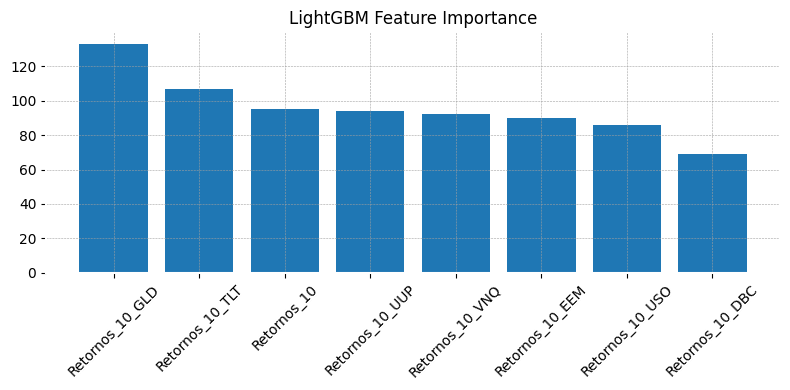

In [ ]:
# Feature Importance estándar del último modelo del rolling

meta_model = LGBMClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42, verbosity=-1
)
meta_model.fit(df_signals.loc[:N_TRAIN-1, features_meta], df_signals.loc[:N_TRAIN-1, "Objetivo_Señal"])
importances = meta_model.feature_importances_

df_feat_imp = pd.DataFrame({
    'Feature': features_meta,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nImportancia estándar LightGBM (último modelo):")
print(df_feat_imp)

plt.figure(figsize=(8,4))
plt.bar(df_feat_imp['Feature'], df_feat_imp['Importance'])
plt.xticks(rotation=45)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

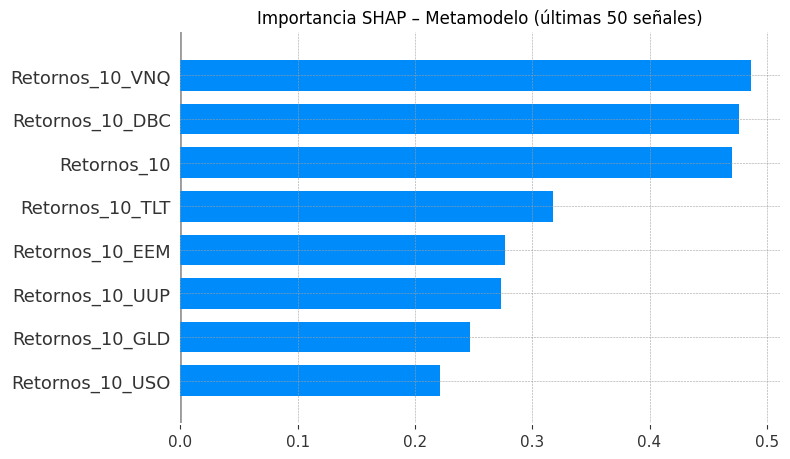

In [ ]:
import shap

# Explicabilidad SHAP sobre el último modelo y las últimas 50 señales
explainer = shap.TreeExplainer(meta_model)
shap_values = explainer.shap_values(df_signals.loc[N_TRAIN-50:N_TRAIN, features_meta])

# Crear el gráfico y capturar el objeto Axes
plt.figure()
ax = shap.summary_plot(
    shap_values,
    df_signals.loc[N_TRAIN-50:N_TRAIN, features_meta],
    plot_type="bar",
    show=False
)

# Eliminar el texto de descripción (generalmente es el xlabel)
plt.xlabel("")  # Quita la leyenda larga
plt.title("Importancia SHAP – Metamodelo (últimas 50 señales)")
plt.tight_layout()
plt.show()

# 7. Misceláneos

**Visualización temporal de señales**

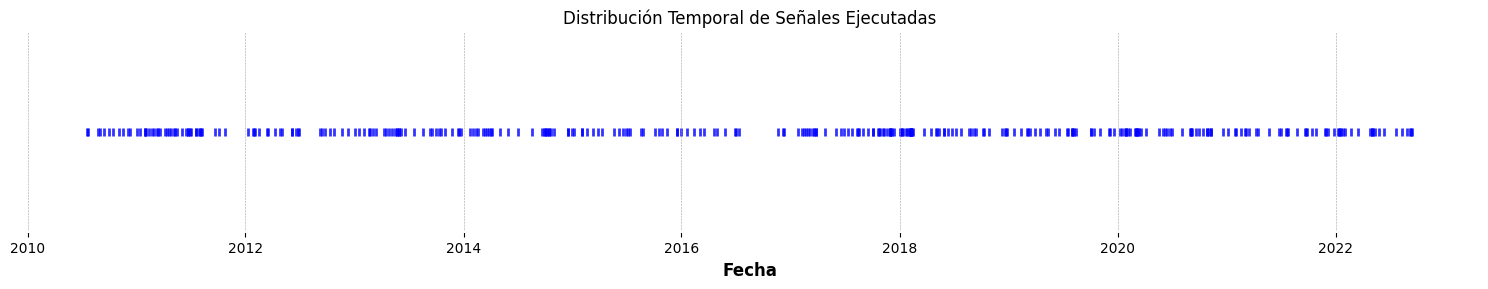

In [ ]:
# Asegúrate de que 'Fecha_Cierre' es datetime
df_train['Fecha_Cierre'] = pd.to_datetime(df_train['Fecha_Cierre'])

# Extrae sólo las señales ejecutadas
df_signals = df_train[df_train['Señal'] == 1].copy()

plt.figure(figsize=(15, 3))
plt.scatter(df_signals['Fecha_Cierre'], [1]*len(df_signals), marker='|', color='b', alpha=0.8)
plt.title('Distribución Temporal de Señales Ejecutadas')
plt.yticks([])
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

**Distribución de distancias entre señales**

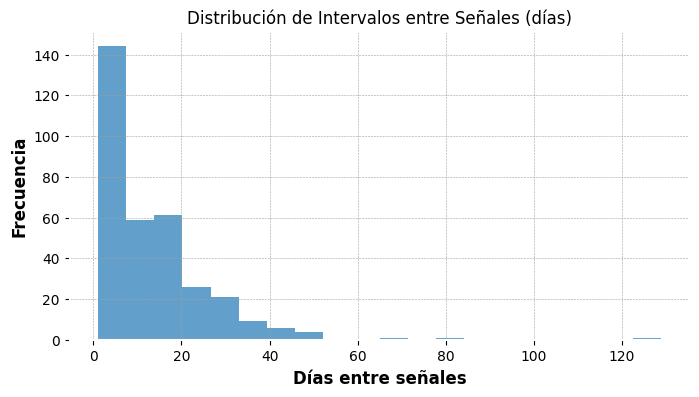

Media días entre señales: 13.3  |  Mediana: 10.0


In [ ]:
signal_dates = df_signals['Fecha_Cierre'].sort_values()
signal_lags = signal_dates.diff().dt.days.dropna()

plt.figure(figsize=(8,4))
plt.hist(signal_lags, bins=20, alpha=0.7)
plt.title('Distribución de Intervalos entre Señales (días)')
plt.xlabel('Días entre señales')
plt.ylabel('Frecuencia')
plt.show()

print(f"Media días entre señales: {signal_lags.mean():.1f}  |  Mediana: {signal_lags.median():.1f}")

**Análisis de rachas (streaks) de señales ganadoras y perdedoras**

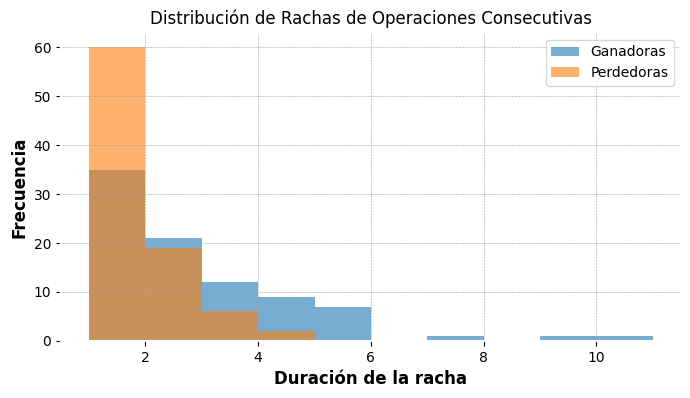

Racha ganadora más larga: 10
Racha perdedora más larga: 4


In [ ]:
# Crea una serie de +1 (ganancia), -1 (pérdida), 0 (break-even)
df_signals['Resultado'] = np.where(
    df_signals['Objetivo_Señal'] == 1, 1, -1
)

# Calcula las rachas (streaks) usando run length encoding
def streaks(arr):
    # Devuelve: lista de (valor, longitud)
    from itertools import groupby
    return [(k, sum(1 for _ in g)) for k,g in groupby(arr)]

streak_list = streaks(df_signals['Resultado'].values)
streak_df = pd.DataFrame(streak_list, columns=['Resultado', 'Duración'])

# Histogramas
plt.figure(figsize=(8,4))
plt.hist(streak_df.loc[streak_df['Resultado']==1, 'Duración'], bins=range(1,12), alpha=0.6, label='Ganadoras')
plt.hist(streak_df.loc[streak_df['Resultado']==-1, 'Duración'], bins=range(1,12), alpha=0.6, label='Perdedoras')
plt.title('Distribución de Rachas de Operaciones Consecutivas')
plt.xlabel('Duración de la racha')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Info sobre rachas máximas
max_winning_streak = streak_df.loc[streak_df['Resultado']==1, 'Duración'].max()
max_losing_streak = streak_df.loc[streak_df['Resultado']==-1, 'Duración'].max()
print(f"Racha ganadora más larga: {max_winning_streak}")
print(f"Racha perdedora más larga: {max_losing_streak}")

In [ ]:
# Frecuencias de rachas de cada tipo
summary = streak_df.groupby(['Resultado', 'Duración']).size().unstack(fill_value=0)
print("Tabla resumen de frecuencia de rachas:")
print(summary)

Tabla resumen de frecuencia de rachas:
Duración   1   2   3   4   5   7   9   10
Resultado                                
-1         60  19   6   2   0   0   0   0
 1         35  21  12   9   7   1   1   1


**Probabilidad empírica de ganar condicionada a la longitud de la racha previa**

In [ ]:
from collections import defaultdict

resultados = df_signals['Resultado'].values  # asume 1=win, -1=loss

# Mapear: longitud de racha previa (ganadora) --> ¿qué pasó después?
racha_map = defaultdict(list)

streak = 0
for i in range(len(resultados)-1):  # último no tiene "siguiente"
    if resultados[i] == 1:
        streak += 1
    else:
        streak = 0
    # solo analizamos lo que ocurre después de cada racha de wins
    racha_map[streak].append(resultados[i+1])

# Calcula probabilidad de win/loss tras cada longitud de racha
for k in sorted(racha_map.keys()):
    siguientes = racha_map[k]
    if len(siguientes) >= 10:  # para estadística decente
        prob_win = np.mean(np.array(siguientes) == 1)
        prob_loss = np.mean(np.array(siguientes) == -1)
        print(f"Tras {k} wins seguidos: N={len(siguientes)} | P(Win sig): {prob_win:.2f} | P(Loss sig): {prob_loss:.2f}")

Tras 0 wins seguidos: N=123 | P(Win sig): 0.70 | P(Loss sig): 0.30
Tras 1 wins seguidos: N=87 | P(Win sig): 0.60 | P(Loss sig): 0.40
Tras 2 wins seguidos: N=52 | P(Win sig): 0.60 | P(Loss sig): 0.40
Tras 3 wins seguidos: N=31 | P(Win sig): 0.61 | P(Loss sig): 0.39
Tras 4 wins seguidos: N=19 | P(Win sig): 0.53 | P(Loss sig): 0.47
Tras 5 wins seguidos: N=10 | P(Win sig): 0.30 | P(Loss sig): 0.70


In [ ]:
from collections import defaultdict

# Supón que tu dataframe es df_signals y la columna Resultado ya está definida:
# 1 = Ganancia, -1 = Pérdida
resultados = df_signals['Resultado'].values  # vector de 1 (ganada) y -1 (perdida)

# Diccionario: racha de pérdidas previa --> resultado de la siguiente operación
racha_loss_map = defaultdict(list)

streak = 0
for i in range(len(resultados) - 1):  # hasta el penúltimo
    if resultados[i] == -1:
        streak += 1
    else:
        streak = 0
    # Solo nos interesa después de rachas de pérdidas (streak >= 1)
    racha_loss_map[streak].append(resultados[i + 1])

# Imprime probabilidad condicional de ganancia o pérdida tras cada racha de pérdidas
print("Probabilidad condicional de ganar/perder tras racha de pérdidas:")
for k in sorted(racha_loss_map.keys()):
    siguientes = racha_loss_map[k]
    if k >= 1 and len(siguientes) >= 10:  # Solo muestra si hay muestra razonable
        prob_win = np.mean(np.array(siguientes) == 1)
        prob_loss = np.mean(np.array(siguientes) == -1)
        print(f"Tras {k} pérdidas seguidas (N={len(siguientes)}): "
              f"P(Win sig) = {prob_win:.2f} | P(Loss sig) = {prob_loss:.2f}")

Probabilidad condicional de ganar/perder tras racha de pérdidas:
Tras 1 pérdidas seguidas (N=87): P(Win sig) = 0.69 | P(Loss sig) = 0.31
Tras 2 pérdidas seguidas (N=26): P(Win sig) = 0.69 | P(Loss sig) = 0.31


# 8. Evaluación en Hold-out

## Preparación del conjunto de hold-out y ventana combinada

In [ ]:
# 1) Asegurar tipos/columnas necesarias (coherentes con entrenamiento)
cols_necesarias = ['Fecha_Cierre','Precio_Cierre','VIX_Open','Retornos_10','SL','Objetivo']
faltantes = [c for c in cols_necesarias if c not in df_barras.columns]
if faltantes:
    raise ValueError(f"Faltan columnas en df_barras para hold-out: {faltantes}")

# 2) Tomar los últimos 500 registros del train
n_tr_hist = 500
df_train_tail = df_train.tail(n_tr_hist).copy().reset_index(drop=True)

# 3) Unir con hold-out
df_combo = pd.concat([df_train_tail, df_holdout], ignore_index=True)

print(f"Tamaño df_train_tail: {len(df_train_tail)}")
print(f"Tamaño df_holdout   : {len(df_holdout)}")
print(f"Tamaño df_combo     : {len(df_combo)}")

# 4) Inicializar columnas para predicciones en hold-out combo (al estilo de entrenamiento)
df_combo["Señal"] = np.nan
df_combo["Probabilidad_Señal"] = np.nan

Tamaño df_train_tail: 500
Tamaño df_holdout   : 95
Tamaño df_combo     : 595


## Definición de folds para el rolling en hold-out

In [ ]:
# 2) Definición de folds para el rolling en hold-out (con ÚNICO fold parcial final)
num_train = 500
num_val   = 40

folds_hold = []
N = len(df_combo)
start = 0

# 1) Folds completos (500/40), avanzando de 40 en 40
while start + num_train + num_val <= N:
    tr_start = start
    tr_end   = start + num_train - 1
    va_start = tr_end + 1
    va_end   = va_start + num_val - 1

    idx_tr = df_combo.index[tr_start:tr_end + 1]
    idx_va = df_combo.index[va_start:va_end + 1]
    folds_hold.append((idx_tr, idx_va))

    start += num_val

# 2) Fold parcial final (si queda remanente > 0)
if start + num_train < N:
    tr_start = start
    tr_end   = start + num_train - 1
    va_start = tr_end + 1
    va_end   = N - 1  # todo lo que queda

    if va_start <= va_end:  # hay al menos 1 muestra en validación
        idx_tr = df_combo.index[tr_start:tr_end + 1]
        idx_va = df_combo.index[va_start:va_end + 1]
        folds_hold.append((idx_tr, idx_va))

print(f"Total folds (hold-out, con parcial final): {len(folds_hold)}")
for i, (tr, va) in enumerate(folds_hold, 1):
    print(f"Fold {i}: train [{tr[0]}→{tr[-1]}] (n={len(tr)}), val [{va[0]}→{va[-1]}] (n={len(va)})")

Total folds (hold-out, con parcial final): 3
Fold 1: train [0→499] (n=500), val [500→539] (n=40)
Fold 2: train [40→539] (n=500), val [540→579] (n=40)
Fold 3: train [80→579] (n=500), val [580→594] (n=15)


## Condición HMM por fold (en hold-out), replicando criterio

In [ ]:
# =============================================
# HMM en HOLD-OUT: entrenamiento por fold y estados forward-only en validación
# Requiere: df_combo, folds_hold (definidos como en tu bloque)
# =============================================

from hmmlearn.hmm import GaussianHMM

# --- Config coherente con entrenamiento ---
n_states       = 4
n_iter         = 200
random_state   = 42
features       = ['VIX_Open', 'Retornos_10']
epsilon_jitter = 1e-6

# --- Helper: estados forward-only en validación (sin mirar el futuro del bloque) ---
def states_forward_only(model, X_va: np.ndarray) -> np.ndarray:
    """
    Para cada t, corre Viterbi en el prefijo X_va[:t] y toma el último estado.
    """
    out = np.empty(len(X_va), dtype=int)
    for t in range(1, len(X_va) + 1):
        out[t-1] = model.predict(X_va[:t])[-1]
    return out

# --- Prepara columnas de salida en df_combo ---
for i in range(1, len(folds_hold) + 1):
    col = f"HMM_state_hold_fold{i}"
    if col not in df_combo.columns:
        df_combo[col] = np.nan

hmm_models_hold = []

# --- Entrenamiento por fold (hold-out) ---
for i, (idx_tr, idx_va) in enumerate(folds_hold, start=1):
    # Conjuntos (ya son indexadores posicionales/RangeIndex de df_combo)
    X_tr = df_combo.loc[idx_tr, features].to_numpy(copy=True)
    X_va = df_combo.loc[idx_va, features].to_numpy(copy=True)

    # Jitter para estabilidad numérica
    if epsilon_jitter > 0:
        X_tr = X_tr + epsilon_jitter * np.random.randn(*X_tr.shape)
        X_va = X_va + epsilon_jitter * np.random.randn(*X_va.shape)

    # Entrena HMM (full -> fallback diag si falla)
    try:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='full',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)
    except ValueError:
        model = GaussianHMM(
            n_components=n_states,
            covariance_type='diag',
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_tr)

    hmm_models_hold.append(model)

    # Estados en TRAIN (Viterbi estándar sobre toda la secuencia)
    states_tr = model.predict(X_tr)

    # Estados en VALIDACIÓN (forward-only)
    states_va = states_forward_only(model, X_va)

    # Escribe resultados en df_combo
    col = f"HMM_state_hold_fold{i}"
    # Creamos copia completa (para asignar train+valid en sus posiciones absolutas)
    col_vals = df_combo[col].to_numpy(copy=True)
    col_vals[idx_tr] = states_tr
    col_vals[idx_va] = states_va
    # Guarda como categórica con categorías fijas 0..n_states-1
    df_combo[col] = pd.Categorical(col_vals, categories=list(range(n_states)))

    print(f"[Hold Fold {i}] Train={len(idx_tr)} | Valid={len(idx_va)} | columna='{col}' asignada.")

print("\nColumnas HMM de hold-out creadas:")
print([c for c in df_combo.columns if c.startswith("HMM_state_hold_fold")])

# =============================================
# DEVOLVER columnas de estados al df_holdout original
# (la parte de hold-out en df_combo está a partir de len(df_train_tail))
# =============================================
start_hold = len(df_train_tail)  # primer índice de la sección hold-out dentro de df_combo

hmm_cols_hold = [c for c in df_combo.columns if c.startswith("HMM_state_hold_fold")]
df_holdout_states = df_combo.loc[start_hold:, hmm_cols_hold].reset_index(drop=True)

# Asegura que el largo coincide con df_holdout
if len(df_holdout_states) != len(df_holdout):
    raise ValueError("Longitudes no coinciden al devolver estados HMM al hold-out.")

# Añade/actualiza columnas en df_holdout
for c in hmm_cols_hold:
    df_holdout[c] = df_holdout_states[c].values

print("\nColumnas de estados HMM transferidas a df_holdout:")
print(hmm_cols_hold)

# (Opcional) Exportar a Excel para auditoría
df_holdout[['Fecha_Cierre'] + hmm_cols_hold].to_excel("hmm_holdout_estados.xlsx", index=False)
print("Archivo 'hmm_holdout_estados.xlsx' generado.")

[Hold Fold 1] Train=500 | Valid=40 | columna='HMM_state_hold_fold1' asignada.


[Hold Fold 2] Train=500 | Valid=40 | columna='HMM_state_hold_fold2' asignada.
[Hold Fold 3] Train=500 | Valid=15 | columna='HMM_state_hold_fold3' asignada.

Columnas HMM de hold-out creadas:
['HMM_state_hold_fold1', 'HMM_state_hold_fold2', 'HMM_state_hold_fold3']

Columnas de estados HMM transferidas a df_holdout:
['HMM_state_hold_fold1', 'HMM_state_hold_fold2', 'HMM_state_hold_fold3']
Archivo 'hmm_holdout_estados.xlsx' generado.


In [ ]:
# =============================================
# MÉTRICAS y PARÁMETROS HMM — HOLD-OUT (igual a entrenamiento/validación)
# =============================================

# --- Config coherente ---
features = ['VIX_Open', 'Retornos_10']
col_retorno_evento = 'Retorno_diario'  # ajusta si usas otro nombre
min_support = 50                       # mínimo de eventos para elegir "peor estado"

# --- Utilidad: métricas sobre una curva de equity y fechas ---
def calcular_metricas_equity(equity, fechas):
    equity = np.asarray(equity, dtype=float)
    f_arr = pd.to_datetime(fechas).to_numpy()
    if equity.size < 2 or f_arr.size < 2:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    order = np.argsort(f_arr)
    equity = equity[order]
    f_arr  = f_arr[order]

    years = max((f_arr[-1] - f_arr[0]) / np.timedelta64(1, 'D') / 365.25, 1/365.25)
    rets = pd.Series(equity).pct_change().dropna()
    if rets.size == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(len(rets) / years) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(len(rets) / years) if neg_rets.size > 0 else np.nan

    cagr = (equity[-1] / equity[0]) ** (1/years) - 1
    running_max = np.maximum.accumulate(equity)
    drawdowns   = equity / running_max - 1
    mdd         = drawdowns.min()
    calmar      = cagr / abs(mdd) if mdd < 0 else np.nan
    return cagr, sharpe, sortino, mdd, calmar

# --- Validaciones mínimas ---
if col_retorno_evento not in df_combo.columns:
    raise KeyError(f"No se encontró la columna '{col_retorno_evento}' en df_combo.")
if len(hmm_models_hold) != len(folds_hold):
    raise AssertionError("Cantidad de modelos HMM hold y folds_hold no coincide.")

# --- Excel writers ---
writer_metrics = pd.ExcelWriter("hmm_metrics_hold_por_fold.xlsx", engine='openpyxl')
writer_params  = pd.ExcelWriter("hmm_parametros_hold_por_fold.xlsx", engine='openpyxl')

tabla_resumen_metrics = []
tabla_resumen_params  = []
peor_params_por_fold  = []

for i, ((idx_tr, idx_va), model) in enumerate(zip(folds_hold, hmm_models_hold), start=1):
    # Subconjuntos
    df_tr = df_combo.loc[idx_tr].copy()
    df_va = df_combo.loc[idx_va].copy()

    # Estados en TRAIN (Viterbi sobre toda la secuencia)
    X_tr = df_tr[features].to_numpy()
    train_sts = model.predict(X_tr)

    # --- Métricas por estado usando retornos de evento en TRAIN ---
    if col_retorno_evento not in df_tr.columns:
        raise KeyError(f"Falta '{col_retorno_evento}' en la sección TRAIN del fold {i}.")

    filas_metrics = []
    n_states_model = model.means_.shape[0]
    for estado in range(n_states_model):
        mask = (train_sts == estado)
        n_mask = int(mask.sum())
        if n_mask < 2:
            filas_metrics.append([estado, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, n_mask])
            continue

        df_e = df_tr.loc[mask, ['Fecha_Cierre', col_retorno_evento]].sort_values('Fecha_Cierre')
        rets_e = pd.to_numeric(df_e[col_retorno_evento], errors='coerce').dropna().to_numpy()
        if rets_e.size < 1:
            filas_metrics.append([estado, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, n_mask])
            continue

        equity_estado = np.cumprod(1.0 + rets_e)
        fechas_estado = df_e['Fecha_Cierre'].iloc[:equity_estado.size]
        cagr, sharpe, sortino, mdd, calmar = calcular_metricas_equity(equity_estado, fechas_estado)
        hitrate = float((rets_e > 0).mean())

        filas_metrics.append([estado, cagr, sharpe, sortino, mdd, calmar, hitrate, int(rets_e.size)])

    df_metrics = pd.DataFrame(
        filas_metrics,
        columns=['Estado', 'CAGR', 'Sharpe', 'Sortino', 'MDD', 'Calmar', 'HitRate', 'N_eventos']
    ).round({'CAGR':4,'Sharpe':4,'Sortino':4,'MDD':4,'Calmar':4,'HitRate':4})

    # --- Buy & Hold del período TRAIN (referencia) ---
    equity_bh = df_tr['Precio_Cierre'].to_numpy() / df_tr['Precio_Cierre'].iloc[0]
    cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh = calcular_metricas_equity(equity_bh, df_tr['Fecha_Cierre'])
    df_bh = pd.DataFrame([['Buy & Hold', cagr_bh, sharpe_bh, sortino_bh, mdd_bh, calmar_bh, np.nan, len(df_tr)]],
                         columns=df_metrics.columns)

    df_metrics_all = pd.concat([df_metrics, df_bh], ignore_index=True)
    df_metrics_all['Fold'] = i
    df_metrics_all.to_excel(writer_metrics, sheet_name=f"Fold_{i}", index=False)

    print(f"\n===== MÉTRICAS HOLD FOLD {i} (por Estado) =====")
    print(df_metrics_all)

    tabla_resumen_metrics.append(df_metrics_all)

    # --- Identificar peor estado por HitRate (con soporte mínimo) ---
    df_estados_solo = df_metrics[pd.to_numeric(df_metrics['Estado'], errors='coerce').notna()].copy()
    candidatos = df_estados_solo[(~df_estados_solo['HitRate'].isna()) & (df_estados_solo['N_eventos'] >= min_support)]
    if len(candidatos) == 0:
        candidatos = df_estados_solo[~df_estados_solo['HitRate'].isna()]

    if len(candidatos) > 0:
        peor_row = candidatos.loc[candidatos['HitRate'].idxmin()]
        peor_estado = int(peor_row['Estado'])
        peor_hit    = float(peor_row['HitRate'])
        peor_n      = int(peor_row['N_eventos'])
    else:
        peor_estado, peor_hit, peor_n = np.nan, np.nan, 0

    print(f"--> Peor estado HOLD (fold {i}): {peor_estado} | HitRate={peor_hit} | N={peor_n}")

    # --- Parámetros del HMM (μ, σ) y A/B del peor estado ---
    raw_covars = model.covars_
    if raw_covars.ndim == 3:
        covars = np.array([np.diag(c) for c in raw_covars])
    else:
        covars = raw_covars
    means = model.means_
    stds  = np.sqrt(covars)

    ix_vix = features.index('VIX_Open')
    ix_ret = features.index('Retornos_10')

    if not np.isnan(peor_estado):
        mu_vix = float(means[peor_estado, ix_vix])
        sd_vix = float(stds [peor_estado, ix_vix])
        mu_ret = float(means[peor_estado, ix_ret])
        sd_ret = float(stds [peor_estado, ix_ret])
        A = mu_vix - sd_vix
        B = mu_ret + sd_ret
    else:
        A = np.nan
        B = np.nan

    peor_params_por_fold.append({
        'Fold': i,
        'Peor_Estado': peor_estado,
        'HitRate_Peor': peor_hit,
        'N_eventos_Peor': peor_n,
        'A_VIX_Open': A,
        'B_Retornos_10': B
    })

    # --- Tabla de parámetros por estado (μ, σ y proporciones en TRAIN) ---
    n_states_model = means.shape[0]
    X_tr_np      = df_tr[features].to_numpy()
    states_train = model.predict(X_tr_np)
    proportions  = np.bincount(states_train, minlength=n_states_model) / len(states_train)

    df_states = pd.DataFrame({
        'Fold':                 i,
        'Estado':               np.arange(n_states_model),
        f'Media_{features[0]}': means[:, 0],
        f'Std_{features[0]}':   stds[:,  0],
        f'Media_{features[1]}': means[:, 1],
        f'Std_{features[1]}':   stds[:,  1],
        'Proporción_train':     proportions
    })
    df_states.to_excel(writer_params, sheet_name=f"Fold_{i}", index=False)
    tabla_resumen_params.append(df_states)

    # --- Escribir A/B como columnas constantes por fold (train+valid del fold) ---
    colA = f'FiltroA_hold_fold{i}'
    colB = f'FiltroB_hold_fold{i}'
    if colA not in df_combo.columns: df_combo[colA] = np.nan
    if colB not in df_combo.columns: df_combo[colB] = np.nan

    pos_all = np.concatenate([idx_tr, idx_va])  # posicionales en df_combo
    df_combo.loc[pos_all, colA] = A
    df_combo.loc[pos_all, colB] = B

# --- Cerrar y exportar resúmenes ---
df_resumen_metrics = pd.concat(tabla_resumen_metrics, ignore_index=True)
df_resumen_metrics.to_excel(writer_metrics, sheet_name="Resumen_Global", index=False)
writer_metrics.close()
print("\nArchivo 'hmm_metrics_hold_por_fold.xlsx' generado correctamente.")

df_resumen_params = pd.concat(tabla_resumen_params, ignore_index=True)
df_resumen_params.to_excel(writer_params, sheet_name="Resumen_Parametros", index=False)
writer_params.close()
print("Archivo 'hmm_parametros_hold_por_fold.xlsx' generado correctamente.")

df_peor_hold = pd.DataFrame(peor_params_por_fold,
                            columns=['Fold','Peor_Estado','HitRate_Peor','N_eventos_Peor','A_VIX_Open','B_Retornos_10'])
df_peor_hold.to_excel("hmm_peor_estado_hold_params_por_fold.xlsx", index=False)
print("\nArchivo 'hmm_peor_estado_hold_params_por_fold.xlsx' generado correctamente.")
print(df_peor_hold)

# =============================================
# PROPAGAR A/B al df_holdout (solo tramo hold-out en df_combo)
# =============================================
start_hold = len(df_train_tail)
ab_cols = [c for c in df_combo.columns if c.startswith('FiltroA_hold_fold') or c.startswith('FiltroB_hold_fold')]
df_hold_ab = df_combo.loc[start_hold:, ab_cols].reset_index(drop=True)

if len(df_hold_ab) != len(df_holdout):
    raise ValueError("Longitudes no coinciden al propagar A/B al hold-out.")

for c in ab_cols:
    df_holdout[c] = df_hold_ab[c].values

print("\nColumnas A/B transferidas a df_holdout:")
print(ab_cols)


===== MÉTRICAS HOLD FOLD 1 (por Estado) =====
       Estado    CAGR  Sharpe  Sortino     MDD  Calmar  HitRate  N_eventos  \
0           0  0.1117  1.4641   5.4983 -0.0783  1.4263   0.6667        222   
1           1  0.0180  0.2178   0.5407 -0.2847  0.0632   0.5309         81   
2           2 -0.0050  0.0094   0.0300 -0.2762 -0.0179   0.4775        178   
3           3 -0.0210 -0.1313  -0.3606 -0.3241 -0.0647   0.4211         19   
4  Buy & Hold  0.0889  0.5322   0.9554 -0.5338  0.1665      NaN        500   

   Fold  
0     1  
1     1  
2     1  
3     1  
4     1  
--> Peor estado HOLD (fold 1): 2 | HitRate=0.4775 | N=178

===== MÉTRICAS HOLD FOLD 2 (por Estado) =====
       Estado    CAGR  Sharpe  Sortino     MDD  Calmar  HitRate  N_eventos  \
0           0  0.1174  1.4812   6.3761 -0.0783  1.4980   0.6574        216   
1           1 -0.0382 -0.3202  -1.2078 -0.5021 -0.0761   0.3966        116   
2           2  0.0655  0.9026   3.9092 -0.0948  0.6910   0.6220        127   
3      

## Entrenamiento XGBoost y predicción por fold en hold-out

In [ ]:
# ==============================================
# XGBoost en HOLD-OUT (pipeline espejo del train)
# ==============================================
import xgboost as xgb

# ---------- Interruptores ----------
USE_FILTER_HO     = False   # activar/desactivar filtro A/B hold-out
USE_ALL_FEATURES_HO = False # True: static_feats + HMM_hold; False: solo static_feats

# ---------- Parámetros del modelo y trading ----------
xgb_params = {
    'objective':        'binary:logistic',
    'learning_rate':    0.1,
    'max_depth':        4,
    'min_child_weight': 2,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'gamma':            0.1,
    'reg_alpha':        0.1,
    'reg_lambda':       1.5,
    'eval_metric':      'logloss',
    'seed':             42,
}
num_boost_round       = 300
early_stopping_rounds = 30
maximize_metric       = True
threshold             = 0.5

# ---------- Trading / backtest ----------
capital_inicial      = 100_000.0
riesgo_pct           = 0.02
spread               = 0.01
comision_por_accion  = 0.001

# ---------- Features estáticas ----------
static_feats = ['VIX_Open','Retornos_10']

# ---------- Salidas en df_combo ----------
for c in ["Señal_HO","Probabilidad_Señal_HO","Señal_raw_HO","Filtro_AB_HO"]:
    if c not in df_combo.columns:
        df_combo[c] = np.nan

metrics_ho   = []
df_global_bt = pd.DataFrame()

# ---------- Helpers ----------
def sel(df, idx):
    """Selector robusto compatible con folds posicionales/etiquetas (RangeIndex en hold-out)."""
    if 'to_positional_indexer' in globals():
        try:
            pos = to_positional_indexer(idx, df)
            return df.iloc[pos]
        except Exception:
            return df.loc[idx]
    else:
        return df.loc[idx]

def ensure_all_dummy_cols(dfX, prefix, n_states):
    for s in range(n_states):
        col = f"{prefix}_{s}"
        if col not in dfX.columns:
            dfX[col] = 0
    dummy_cols = [f"{prefix}_{s}" for s in range(n_states)]
    other_cols = [c for c in dfX.columns if c not in dummy_cols]
    return dfX[other_cols + dummy_cols]

def econ_sortino_like_at_05_score(y_pred, y_true):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    signal = (y_pred >= 0.5).astype(np.float64)
    payoff = np.where(signal > 0, np.where(y_true > 0.5, 1.0, -1.0), np.nan)
    trades = payoff[~np.isnan(payoff)]
    if trades.size == 0:
        return 0.0
    mean_ = trades.mean()
    neg   = trades[trades < 0]
    if neg.size > 1:
        denom = neg.std(ddof=0)
    else:
        sd = trades.std(ddof=0)
        denom = sd if sd > 0 else 1.0
    return float(mean_ / (denom + 1e-12))

def train_with_custom_metric(params, dtrain, dvalid, y_valid,
                             num_boost_round=200, early_stopping_rounds=20,
                             maximize=True, verbose=False):
    booster = xgb.Booster(params=params, cache=[dtrain])
    best_score = -np.inf if maximize else np.inf
    best_iter  = -1
    best_model = None
    rounds_since_best = 0
    for r in range(num_boost_round):
        booster.update(dtrain, r)
        y_pred = booster.predict(dvalid)
        score  = econ_sortino_like_at_05_score(y_pred, y_valid)
        improved = (score > best_score) if maximize else (score < best_score)
        if improved:
            best_score = score; best_iter = r; best_model = booster.copy(); rounds_since_best = 0
        else:
            rounds_since_best += 1
        if verbose and (r % 10 == 0 or improved):
            print(f"[round {r}] econ_sortino@0.5={score:.6f} | best={best_score:.6f} (iter {best_iter})")
        if rounds_since_best >= early_stopping_rounds:
            if verbose:
                print(f"Early stopping en ronda {r} (best_iter={best_iter}, best_score={best_score:.6f})")
            break
    if best_model is None:
        best_model = booster; best_iter = r
        best_score = econ_sortino_like_at_05_score(booster.predict(dvalid), y_valid)
    return best_model, best_iter, best_score

# ==============================
# Bucle por fold (HOLD-OUT)
# ==============================
for i, (idx_tr, idx_va) in enumerate(folds_hold, start=1):
    hmm_col  = f'HMM_state_hold_fold{i}'   # estados categóricos hold-out (0..n_states-1)
    colA     = f'FiltroA_hold_fold{i}'     # umbral A del peor estado (constante en el fold)
    colB     = f'FiltroB_hold_fold{i}'     # umbral B del peor estado (constante en el fold)
    prefix   = f'HMM_HO_s{i}'

    # ======== Selección de features ========
    if USE_ALL_FEATURES_HO:
        feats = static_feats + [hmm_col]
    else:
        feats = static_feats[:]

    # =========================
    # Preparar TRAIN (df_combo)
    # =========================
    df_tr = sel(df_combo, idx_tr)[feats + ['Objetivo']].copy()

    if USE_ALL_FEATURES_HO:
        if hmm_col not in df_tr.columns:
            raise KeyError(f"Falta {hmm_col} en TRAIN (hold-out) para fold {i}. Genera primero los estados HMM hold-out.")
        df_tr[hmm_col] = pd.Categorical(df_tr[hmm_col], categories=list(range(n_states)))
        df_tr = pd.get_dummies(df_tr, columns=[hmm_col], prefix=prefix)
        df_tr = ensure_all_dummy_cols(df_tr, prefix, n_states)

    X_tr = df_tr.drop(columns='Objetivo')
    y_tr = df_tr['Objetivo'].astype(float)

    # =========================
    # Preparar VALIDACIÓN (df_combo)
    # =========================
    cols_val = feats + ['Objetivo','Precio_Cierre','SL','Fecha_Cierre']
    if USE_FILTER_HO:
        cols_val += [colA, colB]
    df_val = sel(df_combo, idx_va)[cols_val].copy()

    if USE_ALL_FEATURES_HO:
        if hmm_col not in df_val.columns:
            raise KeyError(f"Falta {hmm_col} en VALID (hold-out) para fold {i}.")
        df_val[hmm_col] = pd.Categorical(df_val[hmm_col], categories=list(range(n_states)))
        df_val = pd.get_dummies(df_val, columns=[hmm_col], prefix=prefix)
        df_val = ensure_all_dummy_cols(df_val, prefix, n_states)

    # Alinear columnas con TRAIN
    for col in X_tr.columns:
        if col not in df_val.columns:
            df_val[col] = 0
    X_va = df_val[X_tr.columns]
    y_va = df_val['Objetivo'].astype(float)

    # =========================
    # DMatrix y entrenamiento manual
    # =========================
    dtrain = xgb.DMatrix(X_tr.values, label=y_tr.values, feature_names=X_tr.columns.tolist())
    dvalid = xgb.DMatrix(X_va.values, label=y_va.values, feature_names=X_va.columns.tolist())

    booster, best_iteration, best_score = train_with_custom_metric(
        params=xgb_params,
        dtrain=dtrain,
        dvalid=dvalid,
        y_valid=y_va.values,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        maximize=maximize_metric,
        verbose=False
    )

    # =========================
    # Predicción y (opcional) filtro A/B hold-out
    # =========================
    y_prob = booster.predict(dvalid)
    y_pred_raw = (y_prob >= threshold).astype(int)

    if USE_FILTER_HO:
        missing_cols_val = [c for c in [colA, colB] if c not in df_val.columns]
        if missing_cols_val:
            raise KeyError(f"Faltan columnas en VALID (hold-out) fold {i}: {missing_cols_val}. "
                           f"Asegúrate de haber creado {colA}/{colB} previamente.")
        A_vals = df_val[colA].astype(float)
        B_vals = df_val[colB].astype(float)
        mask_valid_ab = A_vals.notna() & B_vals.notna()
        mask_ab = mask_valid_ab & (df_val['VIX_Open'] > A_vals) & (df_val['Retornos_10'] < B_vals)
        y_pred = np.where(mask_ab & (y_pred_raw == 1), 0, y_pred_raw).astype(int)
        df_val['Filtro_AB_HO'] = mask_ab.astype(int)
        n_filtrados = int((mask_ab & (y_pred_raw == 1)).sum())
        print(f"[HOLD Fold {i}] Señales brutas: {int(y_pred_raw.sum())} | Filtradas A/B: {n_filtrados} | Señales finales: {int(y_pred.sum())}")
    else:
        y_pred = y_pred_raw.copy()
        df_val['Filtro_AB_HO'] = 0
        print(f"[HOLD Fold {i}] (Filtro A/B DESACTIVADO) Señales: {int(y_pred.sum())}")

    # Auditoría en df_val (conservar índice original para filtrar hold/val luego)
    df_val['Signal_raw_HO'] = y_pred_raw
    df_val['Signal_HO']     = y_pred
    df_val['Prob_HO']       = y_prob
    df_val['combo_idx']     = sel(df_combo, idx_va).index.values

    # Asignar al df_combo en posiciones de validación del fold
    idx_va_index = sel(df_combo, idx_va).index
    df_combo.loc[idx_va_index, "Señal_raw_HO"]         = y_pred_raw
    df_combo.loc[idx_va_index, "Señal_HO"]             = y_pred
    df_combo.loc[idx_va_index, "Probabilidad_Señal_HO"]= y_prob
    df_combo.loc[idx_va_index, "Filtro_AB_HO"]         = df_val['Filtro_AB_HO'].values

    # =========================
    # Backtest del fold (idéntico a tu función)
    # =========================
    df_bt = ejecutar_backtest(
        df_val.rename(columns={'Signal_HO':'Signal'}),  # la función espera 'Signal'
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
)

    # Alinear combo_idx (df_bt tiene len(df_val) - 1)
    combo_idx_vals = df_val['combo_idx'].iloc[:-1].to_numpy()
    # (opcional seguridad)
    n = min(len(df_bt), len(combo_idx_vals))
    df_bt = df_bt.iloc[:n].copy()
    df_bt['combo_idx'] = combo_idx_vals[:n]

    df_global_bt = pd.concat([df_global_bt, df_bt], axis=0)

    # =========================
    # Métricas del fold
    # =========================
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0:
        anios = 1/365.25

    total_ret = equity.iloc[-1]/equity.iloc[0] - 1
    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt[df_bt['Shares'] > 0]
    num_trades = len(df_trades)
    if num_trades > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    metrics_ho.append({
        'fold':            i,
        'TotalRet':        total_ret,
        'CAGR':            cagr,
        'Sharpe':          sharpe,
        'Sortino':         sortino,
        'MDD':             mdd,
        'Calmar':          calmar,
        'NumTrades':       num_trades,
        'HitRate':         hit_rate,
        'ProfitFactor':    profit_factor,
        'TUW':             tuw,
        'best_iteration':  best_iteration,
        'best_score_econ': best_score
    })

# ---------- Métricas por fold (hold-out) ----------
df_metrics_ho = pd.DataFrame(metrics_ho).set_index('fold')
print("=== Métricas por Fold (Hold-out) ===")
print(df_metrics_ho[['TotalRet','CAGR','Sharpe','Sortino','MDD','Calmar','NumTrades','HitRate','ProfitFactor','TUW','best_iteration','best_score_econ']])
df_metrics_ho.to_excel('metricas_xgboost_hold_por_fold.xlsx')

# ---------- Métricas globales (SOLO tramo hold-out) ----------
start_hold = len(df_train_tail)  # primer índice hold-out dentro de df_combo
dfg = df_global_bt.sort_values(['Fecha_Cierre','combo_idx']).copy()
dfg_hold = dfg[dfg['combo_idx'] >= start_hold].copy()
dfg_hold['Equity_global'] = capital_inicial + dfg_hold['NetPnL'].cumsum()

# Exposición promedio
dfg_hold['Exposicion'] = dfg_hold['Shares'] * dfg_hold['EntryPrice']
exposicion_prom_g = dfg_hold['Exposicion'].mean()
exposicion_prom_pct = exposicion_prom_g / capital_inicial

equity_g    = dfg_hold['Equity_global']
start_g     = pd.to_datetime(dfg_hold['Fecha_Cierre'].iloc[0]) if len(dfg_hold)>0 else pd.NaT
end_g       = pd.to_datetime(dfg_hold['Fecha_Cierre'].iloc[-1]) if len(dfg_hold)>0 else pd.NaT
years_g     = ((end_g - start_g).days / 365.25) if (pd.notna(start_g) and pd.notna(end_g)) else (1/365.25)
total_ret_g = equity_g.iloc[-1] / equity_g.iloc[0] - 1 if len(equity_g)>1 else np.nan
rets_g            = equity_g.pct_change().dropna()
events_per_year_g = len(rets_g) / years_g if years_g>0 else np.nan
mean_ret_g        = rets_g.mean()
std_ret_g         = rets_g.std(ddof=0)
sharpe_g          = (mean_ret_g / std_ret_g) * np.sqrt(events_per_year_g) if std_ret_g>0 else np.nan
neg_rets_g        = rets_g[rets_g < 0]
sortino_g         = (mean_ret_g / neg_rets_g.std(ddof=0)) * np.sqrt(events_per_year_g) if len(neg_rets_g)>0 else np.nan
cagr_g            = (equity_g.iloc[-1] / equity_g.iloc[0])**(1/years_g) - 1 if len(equity_g)>1 and years_g>0 else np.nan
running_max_g     = equity_g.cummax()
drawdowns_g       = equity_g / running_max_g - 1
mdd_g             = drawdowns_g.min() if len(drawdowns_g)>0 else np.nan
calmar_g          = cagr_g / abs(mdd_g) if (pd.notna(cagr_g) and pd.notna(mdd_g) and mdd_g<0) else np.nan
df_trades_g       = dfg_hold[dfg_hold['Shares'] > 0]
hit_rate_g        = (df_trades_g['NetPnL'] > 0).mean() if len(df_trades_g)>0 else np.nan
wins_g            = df_trades_g['NetPnL'][df_trades_g['NetPnL']>0].sum() if len(df_trades_g)>0 else 0.0
loses_g           = -df_trades_g['NetPnL'][df_trades_g['NetPnL']<0].sum() if len(df_trades_g)>0 else 0.0
profit_factor_g   = wins_g / loses_g if loses_g>0 else np.nan
tuw_g             = (equity_g < running_max_g).mean() if len(equity_g)>0 else np.nan

# Eficiencia del capital
eficiencia_capital = cagr_g / exposicion_prom_pct if exposicion_prom_pct > 0 else np.nan

print("\n=== Métricas Globales HOLD-OUT ===")
print(f"Total Return (HO)      : {total_ret_g:.2%}" if pd.notna(total_ret_g) else "Total Return (HO)      : n/a")
print(f"CAGR (HO)              : {cagr_g:.2%}"      if pd.notna(cagr_g) else "CAGR (HO)              : n/a")
print(f"Sharpe (HO)            : {sharpe_g:.2f}"    if pd.notna(sharpe_g) else "Sharpe (HO)            : n/a")
print(f"Sortino (HO)           : {sortino_g:.2f}"   if pd.notna(sortino_g) else "Sortino (HO)           : n/a")
print(f"MDD (HO)               : {mdd_g:.2%}"       if pd.notna(mdd_g) else "MDD (HO)               : n/a")
print(f"Calmar (HO)            : {calmar_g:.2f}"    if pd.notna(calmar_g) else "Calmar (HO)            : n/a")
print(f"Hit-Rate (HO)          : {hit_rate_g:.2%}"  if pd.notna(hit_rate_g) else "Hit-Rate (HO)          : n/a")
print(f"Profit Factor (HO)     : {profit_factor_g:.2f}" if pd.notna(profit_factor_g) else "Profit Factor (HO)     : n/a")
print(f"Time Under Water (HO)  : {tuw_g:.2%}"      if pd.notna(tuw_g) else "Time Under Water (HO)  : n/a")
print(f"\n--- Exposición Promedio del Capital (HO) ---")
print(f"Exposición promedio    : ${exposicion_prom_g:,.2f} ({exposicion_prom_pct:.2%} del capital inicial)")
print(f"Eficiencia del capital : {eficiencia_capital:.2%}" if pd.notna(eficiencia_capital) else "Eficiencia del capital : n/a")

# Guardar a Excel
df_metrics_ho.to_excel('metricas_xgboost_hold_por_fold.xlsx')
resultados_ho = pd.DataFrame({
    'TotalRet_HO': [total_ret_g],
    'CAGR_HO': [cagr_g],
    'Sharpe_HO': [sharpe_g],
    'Sortino_HO': [sortino_g],
    'MDD_HO': [mdd_g],
    'Calmar_HO': [calmar_g],
    'HitRate_HO': [hit_rate_g],
    'ProfitFactor_HO': [profit_factor_g],
    'TUW_HO': [tuw_g],
    'Exposicion_promedio_HO': [exposicion_prom_g],
    'Exposicion_promedio_pct_HO': [exposicion_prom_pct],
    'Eficiencia_capital_HO': [eficiencia_capital]
})
resultados_ho.to_excel('metricas_xgboost_hold_global.xlsx', index=False)

# ==============================================
# Propagar señales al df_holdout (solo tramo HO)
# ==============================================
start_hold = len(df_train_tail)
cols_prop = ["Señal_HO","Probabilidad_Señal_HO","Señal_raw_HO","Filtro_AB_HO"]
df_hold_slice = df_combo.loc[start_hold:, cols_prop].reset_index(drop=True)
if len(df_hold_slice) == len(df_holdout):
    for c in cols_prop:
        df_holdout[c] = df_hold_slice[c].values
    print("\nColumnas de señal propagadas a df_holdout:", cols_prop)
else:
    print("\nAviso: no se propagaron señales a df_holdout por diferencia de longitudes.")

[HOLD Fold 1] (Filtro A/B DESACTIVADO) Señales: 37
[HOLD Fold 2] (Filtro A/B DESACTIVADO) Señales: 40
[HOLD Fold 3] (Filtro A/B DESACTIVADO) Señales: 11
=== Métricas por Fold (Hold-out) ===
      TotalRet   CAGR  Sharpe  Sortino     MDD  Calmar  NumTrades  HitRate  \
fold                                                                         
1       0.1006 0.0934  0.5662   6.0617 -0.0893  1.0455         36   0.5556   
2       0.2922 0.2713  2.4737  14.5847 -0.0590  4.6009         39   0.6923   
3       0.0396 0.1163  0.9733   4.6926 -0.0662  1.7578         10   0.6000   

      ProfitFactor    TUW  best_iteration   best_score_econ  
fold                                                         
1           1.2162 0.6923              11 135135135135.1351  
2           2.2380 0.5128               0 400000000000.0000  
3           1.4461 0.7143              53  90909090909.0909  

=== Métricas Globales HOLD-OUT ===
Total Return (HO)      : 46.78%
CAGR (HO)              : 15.86%
Sharpe (H

**Buy & Hold en el período de hold-out (comparativo)**

In [ ]:
# ================================================
# Buy & Hold en Hold-out: métricas por fold y global
# ================================================

# --- Seguridad: capital base para PF ---
capital_base = capital_inicial if 'capital_inicial' in globals() else 100_000.0

def metrics_bh_from_prices(precios, fechas):
    """Devuelve dict con métricas BH sobre la serie de precios y fechas dadas."""
    if len(precios) < 2:
        return dict(CAGR=np.nan, Sharpe=np.nan, Sortino=np.nan, MDD=np.nan, Calmar=np.nan,
                    HitRate=np.nan, ProfitFactor=np.nan, FechaIni=fechas[0] if len(fechas)>0 else np.nan,
                    FechaFin=fechas[-1] if len(fechas)>0 else np.nan, N=len(precios))
    equity = precios / precios[0]
    cagr, sharpe, sortino, mdd, calmar = calcular_metricas_equity(equity, fechas)

    rets = pd.Series(precios).pct_change().dropna()
    hitrate = (rets > 0).mean() if len(rets) > 0 else np.nan
    pnl = capital_base * rets
    wins = pnl[pnl > 0].sum()
    loses = -pnl[pnl < 0].sum()
    pf = (wins / loses) if loses > 0 else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, Sortino=sortino, MDD=mdd, Calmar=calmar,
                HitRate=hitrate, ProfitFactor=pf,
                FechaIni=pd.to_datetime(fechas[0]), FechaFin=pd.to_datetime(fechas[-1]), N=len(precios))

# ========================================
# 1) Métricas por fold (ventanas de validación)
# ========================================
bh_folds = []
for i, (_, idx_va) in enumerate(folds_hold, start=1):
    fecha_ini_f = df_combo.loc[idx_va[0], 'Fecha_Cierre']
    fecha_fin_f = df_combo.loc[idx_va[-1], 'Fecha_Cierre']
    mask_f = (df_barras['Fecha_Cierre'] >= fecha_ini_f) & (df_barras['Fecha_Cierre'] <= fecha_fin_f)

    precios_f = df_barras.loc[mask_f, 'Precio_Cierre'].values
    fechas_f  = df_barras.loc[mask_f, 'Fecha_Cierre'].values

    m = metrics_bh_from_prices(precios_f, fechas_f)
    m.update({'Fold': i})
    bh_folds.append(m)

df_bh_folds = pd.DataFrame(bh_folds).set_index('Fold').sort_index()

print("\n=== Buy & Hold en Hold-out — Métricas por Fold ===")
cols_show = ['FechaIni','FechaFin','N','CAGR','Sharpe','Sortino','MDD','Calmar','HitRate','ProfitFactor']
print(df_bh_folds[cols_show].round(4))

# ========================================
# 2) Métricas Globales (todo el período hold-out)
# ========================================
# Período real de hold-out (desde el primer punto de validación al último)
_, idx_val0 = folds_hold[0]
fecha_ini = df_combo.loc[idx_val0[0], 'Fecha_Cierre']
fecha_fin = df_combo.loc[folds_hold[-1][1][-1], 'Fecha_Cierre']

mask_ho = (df_barras['Fecha_Cierre'] >= fecha_ini) & (df_barras['Fecha_Cierre'] <= fecha_fin)
precios_ho = df_barras.loc[mask_ho, 'Precio_Cierre'].values
fechas_ho  = df_barras.loc[mask_ho, 'Fecha_Cierre'].values

if len(precios_ho) < 2:
    raise ValueError("No hay suficientes precios para calcular Buy & Hold en el período hold-out.")

m_global = metrics_bh_from_prices(precios_ho, fechas_ho)

print("\n=== Buy & Hold en Hold-out — Métricas Globales ===")
print(f"Rango        : {pd.to_datetime(m_global['FechaIni']).date()} → {pd.to_datetime(m_global['FechaFin']).date()} (N={m_global['N']})")
print(f"CAGR         : {m_global['CAGR']:.2%}")
print(f"Sharpe       : {m_global['Sharpe']:.3f}")
print(f"Sortino      : {m_global['Sortino']:.3f}")
print(f"MDD          : {m_global['MDD']:.2%}")
print(f"Calmar       : {m_global['Calmar']:.3f}")
print(f"Hit Rate     : {m_global['HitRate']:.2%}")
print(f"Profit Factor: {m_global['ProfitFactor']:.3f}")

# (Opcional) Guardar a Excel
# df_bh_folds.to_excel('bh_holdout_metricas_por_fold.xlsx')
# pd.DataFrame([m_global]).to_excel('bh_holdout_metricas_globales.xlsx', index=False)


=== Buy & Hold en Hold-out — Métricas por Fold ===
       FechaIni   FechaFin   N   CAGR  Sharpe  Sortino     MDD  Calmar  \
Fold                                                                     
1    2022-09-23 2023-10-27  40 0.1130  0.6729   1.9955 -0.1035  1.0919   
2    2023-11-01 2024-12-18  40 0.3580  2.5100   6.6505 -0.0839  4.2651   
3    2024-12-24 2025-06-24  15 0.0417  0.2858   0.8970 -0.1811  0.2303   

      HitRate  ProfitFactor  
Fold                         
1      0.5385        1.2725  
2      0.6923        2.4074  
3      0.4286        1.1263  

=== Buy & Hold en Hold-out — Métricas Globales ===
Rango        : 2022-09-23 → 2025-06-24 (N=95)
CAGR         : 21.16%
Sharpe       : 1.154
Sortino      : 2.885
MDD          : -18.11%
Calmar       : 1.168
Hit Rate     : 59.57%
Profit Factor: 1.550


**Comparación Estrategia vs Buy & Hold (hold-out)**

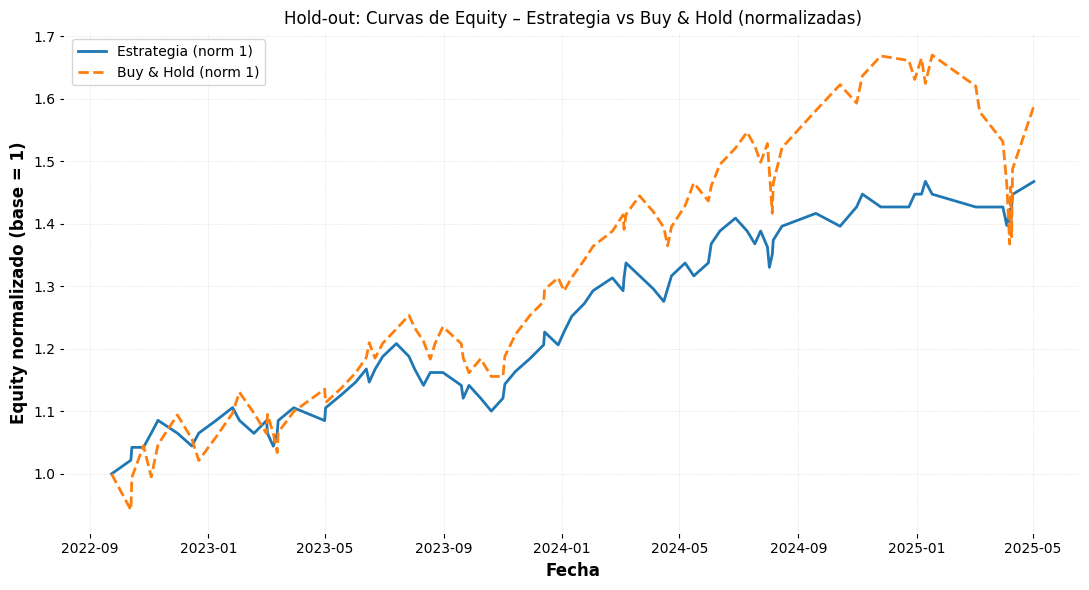

Retorno final Estrategia (norm): 46.78%
Retorno final Buy & Hold (norm): 58.87%


In [ ]:
# === 1) Determinar rango del hold-out según los folds ya construidos ===
fecha_ini = pd.to_datetime(df_combo.loc[folds_hold[0][1][0], 'Fecha_Cierre'])
fecha_fin = pd.to_datetime(df_combo.loc[folds_hold[-1][1][-1], 'Fecha_Cierre'])

# === 2) Equity de la estrategia en el período hold-out ===
# CAMBIO 1: usar df_global_bt (el real) en vez de df_hold_global_bt
df_e = df_global_bt.copy()
df_e['Fecha_Cierre'] = pd.to_datetime(df_e['Fecha_Cierre'])

# Filtrar al rango hold-out
mask_e = (df_e['Fecha_Cierre'] >= fecha_ini) & (df_e['Fecha_Cierre'] <= fecha_fin)
df_e = df_e.loc[mask_e].sort_values('Fecha_Cierre')

# CAMBIO 2: construir una equity GLOBAL continua con el NetPnL acumulado
# (la 'Equity' por fold se resetea cada fold y distorsiona el gráfico)
df_e['Equity_global'] = capital_inicial + df_e['NetPnL'].cumsum()

# Tomar 1 valor por fecha y normalizar
df_e_periodo = (
    df_e[['Fecha_Cierre','Equity_global']]
      .drop_duplicates(subset=['Fecha_Cierre'])
      .sort_values('Fecha_Cierre')
      .copy()
)
df_e_periodo['Equity_norm'] = df_e_periodo['Equity_global'] / df_e_periodo['Equity_global'].iloc[0]

# === 3) Equity Buy & Hold en el mismo rango ===
df_p = df_barras[['Fecha_Cierre','Precio_Cierre']].copy()
df_p['Fecha_Cierre'] = pd.to_datetime(df_p['Fecha_Cierre'])
mask_p = (df_p['Fecha_Cierre'] >= fecha_ini) & (df_p['Fecha_Cierre'] <= fecha_fin)
df_p_periodo = (
    df_p.loc[mask_p]
        .drop_duplicates(subset=['Fecha_Cierre'])
        .sort_values('Fecha_Cierre')
        .copy()
)
df_p_periodo['BH_norm'] = df_p_periodo['Precio_Cierre'] / df_p_periodo['Precio_Cierre'].iloc[0]

# === 4) Alinear por fecha ===
df_cmp = pd.merge(
    df_e_periodo[['Fecha_Cierre','Equity_norm']],
    df_p_periodo[['Fecha_Cierre','BH_norm']],
    on='Fecha_Cierre', how='inner'
).sort_values('Fecha_Cierre')

if len(df_cmp) < 2:
    raise ValueError("No hay suficientes puntos para graficar el comparativo en el período hold-out.")

# === 5) Graficar ===
plt.figure(figsize=(11, 6))
plt.plot(df_cmp['Fecha_Cierre'], df_cmp['Equity_norm'], label='Estrategia (norm 1)')
plt.plot(df_cmp['Fecha_Cierre'], df_cmp['BH_norm'],     label='Buy & Hold (norm 1)', linestyle='--')
plt.title('Hold-out: Curvas de Equity – Estrategia vs Buy & Hold (normalizadas)')
plt.xlabel('Fecha'); plt.ylabel('Equity normalizado (base = 1)')
plt.grid(True, alpha=0.3); plt.legend(loc='best'); plt.tight_layout(); plt.show()

# === 6) Retornos finales (opc.)
ret_estrategia = df_cmp['Equity_norm'].iloc[-1] - 1
ret_bh         = df_cmp['BH_norm'].iloc[-1] - 1
print(f"Retorno final Estrategia (norm): {ret_estrategia:.2%}")
print(f"Retorno final Buy & Hold (norm): {ret_bh:.2%}")

In [ ]:
# ============================================
# Comparación Estrategia vs Buy & Hold (HOLD-OUT, 3 folds)
# ============================================

metrics = ['CAGR','Sharpe','Sortino','Calmar','HitRate']

def _ensure_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{name} no contiene columnas requeridas: {missing}")

# 1) Validaciones y selección de las tablas correctas (HOLD-OUT)
_ensure_cols(df_metrics_ho, metrics, "df_metrics_ho (estrategia)")
_ensure_cols(df_bh_folds,  metrics, "df_bh_folds (buy&hold)")

# 2) Forzar exactamente los folds de hold-out (1..len(folds_hold))
folds_ho_idx = list(range(1, len(folds_hold) + 1))  # p.ej. [1,2,3]

df_strat_ho = df_metrics_ho[metrics].reindex(folds_ho_idx)
df_bh_ho    = df_bh_folds[metrics].reindex(folds_ho_idx)

# 3) Comparación fold a fold (manejo robusto de NaN por métrica)
comp = pd.DataFrame(index=metrics, columns=['Wins', 'TotalFolds', 'Pct_Estrategia>BH'])

for m in metrics:
    a = df_strat_ho[m].astype(float).to_numpy()
    b = df_bh_ho[m].astype(float).to_numpy()
    valid = ~np.isnan(a) & ~np.isnan(b)  # sólo folds con dato en ambas tablas
    wins  = int((a[valid] > b[valid]).sum())
    total = int(valid.sum())  # debería ser 3; si falta algún dato, reduce el denominador

    comp.loc[m, 'Wins']              = wins
    comp.loc[m, 'TotalFolds']        = total
    comp.loc[m, 'Pct_Estrategia>BH'] = (wins / total * 100.0) if total > 0 else np.nan

# 4) Formato de salida igual al de CV por folds
comp_formatted = comp.copy()
comp_formatted['Pct_Estrategia>BH'] = comp_formatted['Pct_Estrategia>BH'].astype(float).map(lambda x: f"{x:.1f}%" if pd.notna(x) else "n/a")

print("\nComparación fold a fold de Estrategia vs Buy & Hold (HOLD-OUT):")
print(comp_formatted)

# 5) Guardar en Excel (mismo nombre si quieres mantener consistencia)
comp.to_excel('comparacion_estrategia_vs_buyhold.xlsx')
print("Archivo 'comparacion_estrategia_vs_buyhold.xlsx' guardado correctamente.")


Comparación fold a fold de Estrategia vs Buy & Hold (HOLD-OUT):
        Wins TotalFolds Pct_Estrategia>BH
CAGR       1          3             33.3%
Sharpe     1          3             33.3%
Sortino    3          3            100.0%
Calmar     2          3             66.7%
HitRate    2          3             66.7%
Archivo 'comparacion_estrategia_vs_buyhold.xlsx' guardado correctamente.


In [ ]:
# ===========================================================
# Análisis de Señales en HOLD-OUT: resultado, calibración, random test
# ===========================================================

from sklearn.metrics import roc_auc_score

# -----------------------------
# 0) Selección del tramo HOLD-OUT
# -----------------------------
if 'df_holdout' in globals():
    df_ho = df_holdout.copy()
else:
    # Fallback: usar df_combo desde el inicio del tramo hold-out
    if 'df_combo' not in globals() or 'df_train_tail' not in globals():
        raise NameError("No se encuentra df_holdout ni (df_combo + df_train_tail) para delimitar el hold-out.")
    start_hold = len(df_train_tail)
    df_ho = df_combo.loc[start_hold:].copy()

# Chequeos mínimos
needed_cols = ['Precio_Cierre','Señal_HO','Probabilidad_Señal_HO']
missing = [c for c in needed_cols if c not in df_ho.columns]
if missing:
    raise KeyError(f"Faltan columnas en tramo HO: {missing}")


=== Descriptivos de Probabilidad por Resultado (HOLD-OUT) ===
                     count   mean    std    min    25%    50%    75%    max
Resultado_Señal_HO                                                         
0.0000             32.0000 0.5813 0.0473 0.5257 0.5639 0.5681 0.5881 0.7999
1.0000             55.0000 0.5700 0.0400 0.5010 0.5523 0.5681 0.5724 0.7271


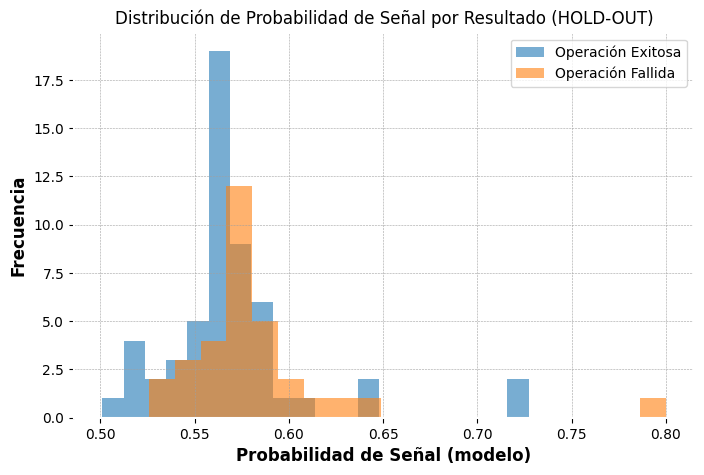

AUC (hold-out): 0.422


In [ ]:
# -----------------------------
# 1) Resultado por señal (HOLD-OUT)
# -----------------------------
df_ho["Resultado_Señal_HO"] = np.where(
    (df_ho["Señal_HO"] == 1) & (df_ho["Precio_Cierre"].shift(-1) > df_ho["Precio_Cierre"]),
    1,
    np.where((df_ho["Señal_HO"] == 1) & (df_ho["Precio_Cierre"].shift(-1) <= df_ho["Precio_Cierre"]), 0, np.nan)
)

# Extrae sólo señales con resultado disponible
df_senal_ho = df_ho[df_ho['Señal_HO'] == 1].copy()
df_senal_ho = df_senal_ho[df_senal_ho['Resultado_Señal_HO'].notna()]

# Tabla: promedios de probabilidad según éxito
if len(df_senal_ho) > 0:
    print("\n=== Descriptivos de Probabilidad por Resultado (HOLD-OUT) ===")
    print(df_senal_ho.groupby('Resultado_Señal_HO')['Probabilidad_Señal_HO'].describe())
else:
    print("\n(No hay señales con resultado disponible en hold-out)")

# Gráfica: histogramas de probabilidad por resultado
if len(df_senal_ho) > 0:
    plt.figure(figsize=(8,5))
    plt.hist(df_senal_ho.loc[df_senal_ho['Resultado_Señal_HO']==1, 'Probabilidad_Señal_HO'], bins=20, alpha=0.6, label='Operación Exitosa')
    plt.hist(df_senal_ho.loc[df_senal_ho['Resultado_Señal_HO']==0, 'Probabilidad_Señal_HO'], bins=20, alpha=0.6, label='Operación Fallida')
    plt.xlabel('Probabilidad de Señal (modelo)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Probabilidad de Señal por Resultado (HOLD-OUT)')
    plt.legend()
    plt.show()

    # AUC (probabilidad vs. resultado)
    auc_ho = roc_auc_score(df_senal_ho['Resultado_Señal_HO'].astype(int), df_senal_ho['Probabilidad_Señal_HO'].astype(float))
    print(f"AUC (hold-out): {auc_ho:.3f}")


=== Calibración por tramos de probabilidad (HOLD-OUT) ===
        prob_bin  Promedio_Probabilidad  Tasa_Éxito  Cantidad_Senales
0  (-0.001, 0.1]                    NaN         NaN                 0
1     (0.1, 0.2]                    NaN         NaN                 0
2     (0.2, 0.3]                    NaN         NaN                 0
3     (0.3, 0.4]                    NaN         NaN                 0
4     (0.4, 0.5]                    NaN         NaN                 0
5     (0.5, 0.6]                 0.5615      0.6533                75
6     (0.6, 0.7]                 0.6200      0.4444                 9
7     (0.7, 0.8]                 0.7514      0.6667                 3
8     (0.8, 0.9]                    NaN         NaN                 0
9     (0.9, 1.0]                    NaN         NaN                 0


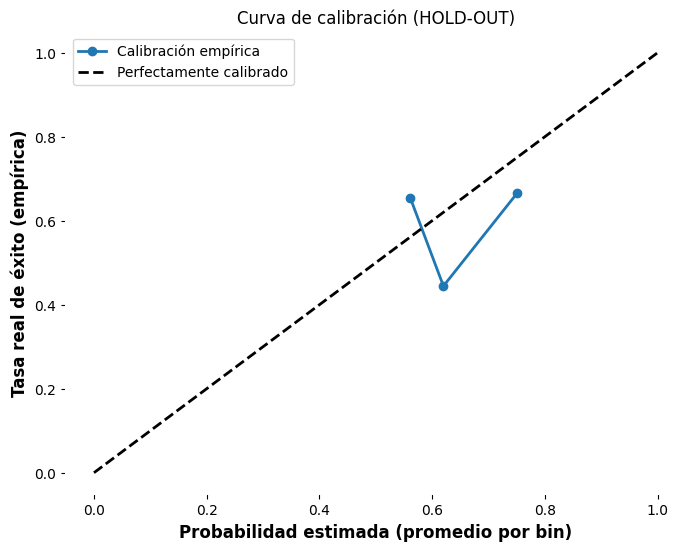

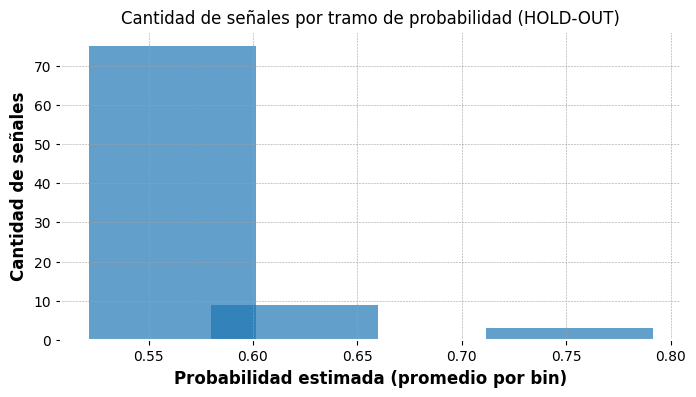

In [ ]:
# -----------------------------
# 2) Calibración por bins (HOLD-OUT)
# -----------------------------
if len(df_senal_ho) > 0:
    n_bins = 10
    df_senal_ho['prob_bin'] = pd.cut(
        df_senal_ho['Probabilidad_Señal_HO'],
        bins=np.linspace(0, 1, n_bins+1),
        include_lowest=True
    )

    calibration = df_senal_ho.groupby('prob_bin').agg(
        Promedio_Probabilidad=('Probabilidad_Señal_HO', 'mean'),
        Tasa_Éxito=('Resultado_Señal_HO', 'mean'),
        Cantidad_Senales=('Resultado_Señal_HO', 'count')
    ).reset_index()

    print("\n=== Calibración por tramos de probabilidad (HOLD-OUT) ===")
    print(calibration)

    # Curva de calibración
    plt.figure(figsize=(8,6))
    plt.plot(calibration['Promedio_Probabilidad'], calibration['Tasa_Éxito'], 'o-', label='Calibración empírica')
    plt.plot([0,1], [0,1], 'k--', label='Perfectamente calibrado')
    plt.xlabel('Probabilidad estimada (promedio por bin)')
    plt.ylabel('Tasa real de éxito (empírica)')
    plt.title('Curva de calibración (HOLD-OUT)')
    plt.legend()
    plt.grid()
    plt.show()

    # Histograma de cantidad de señales por bin
    plt.figure(figsize=(8,4))
    plt.bar(calibration['Promedio_Probabilidad'], calibration['Cantidad_Senales'], width=0.08, alpha=0.7)
    plt.xlabel('Probabilidad estimada (promedio por bin)')
    plt.ylabel('Cantidad de señales')
    plt.title('Cantidad de señales por tramo de probabilidad (HOLD-OUT)')
    plt.show()

In [ ]:
# -----------------------------
# 3) Señalizados vs Descartados (HOLD-OUT)
# -----------------------------
# Preferimos 'Objetivo' si existe; si no, usamos Resultado_Señal_HO como proxy
if 'Objetivo' in df_ho.columns and df_ho['Objetivo'].notna().any():
    eventos_señalizados   = df_ho[df_ho['Señal_HO'] == 1]
    eventos_descartados   = df_ho[df_ho['Señal_HO'] == 0]
    tasa_acierto_s        = eventos_señalizados['Objetivo'].mean()
    tasa_acierto_d        = eventos_descartados['Objetivo'].mean()
else:
    # Proxy con resultado observado (sólo para señalizados; para descartados, no hay trade => usamos próximo retorno > 0)
    eventos_señalizados   = df_ho[df_ho['Señal_HO'] == 1].copy()
    eventos_descartados   = df_ho[df_ho['Señal_HO'] == 0].copy()
    tasa_acierto_s        = eventos_señalizados['Resultado_Señal_HO'].mean()
    # Para descartados: proxy binaria de si el próximo cierre subió
    prox_subio = (eventos_descartados['Precio_Cierre'].shift(-1) > eventos_descartados['Precio_Cierre']).astype(float)
    tasa_acierto_d        = prox_subio.mean()

cantidad_señalizados = len(eventos_señalizados)
cantidad_descartados = len(eventos_descartados)

print("\n=== Señalizados vs Descartados (HOLD-OUT) ===")
print(f"Cantidad de eventos señalizados: {cantidad_señalizados}")
print(f"Cantidad de eventos descartados: {cantidad_descartados}")
print(f"Tasa de acierto (señalizados):   {tasa_acierto_s:.2%}" if pd.notna(tasa_acierto_s) else "Tasa de acierto (señalizados):   n/a")
print(f"Tasa de acierto (descartados):   {tasa_acierto_d:.2%}" if pd.notna(tasa_acierto_d) else "Tasa de acierto (descartados):   n/a")


=== Señalizados vs Descartados (HOLD-OUT) ===
Cantidad de eventos señalizados: 88
Cantidad de eventos descartados: 7
Tasa de acierto (señalizados):   62.50%
Tasa de acierto (descartados):   14.29%



=== Resultados promedio de señales aleatorias (HOLD-OUT) ===
CAGR            0.1292
Sharpe          1.0917
Sortino         8.3173
MDD            -0.0906
Calmar          1.4640
HitRate         0.5960
ProfitFactor    1.4625
TUW             0.7143
dtype: float64

=== P-values (aleatorio >= modelo HO; en TUW y MDD: aleatorio <=/ >= según corresponda) ===
CAGR: 0.008
Sharpe: 0.016
Sortino: 0.085
MDD: 0.369
Calmar: 0.102
HitRate: 0.020
ProfitFactor: 0.016
TUW: 0.061


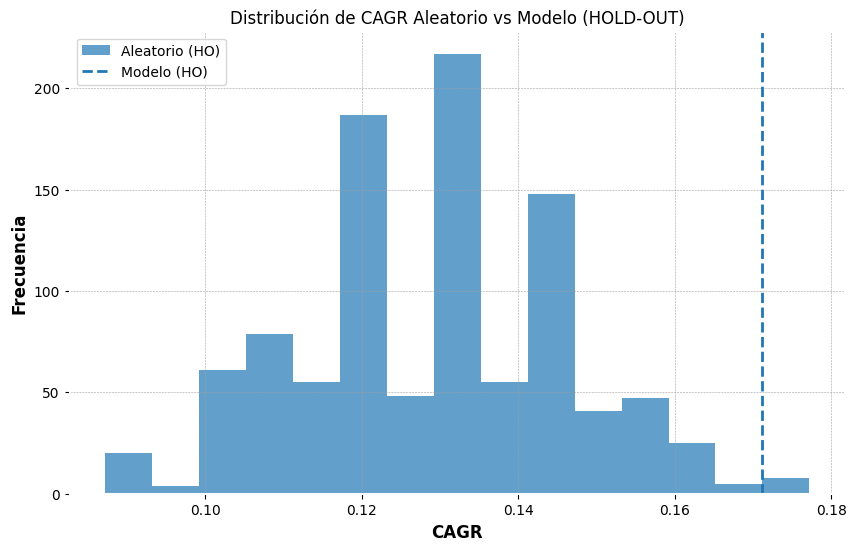

In [ ]:
# -----------------------------
# 4) Simulación aleatoria en HOLD-OUT (misma cantidad de señales)
# -----------------------------
# Señales reales HO para comparar
n_signals = int((df_ho['Señal_HO'] == 1).sum())

# Backtest REAL sobre HO con Señal_HO
df_bt_real = ejecutar_backtest(
    df_ho.assign(Signal=df_ho['Señal_HO'].values),
    signal_col='Signal',
    capital_inicial=capital_inicial,
    riesgo_pct=riesgo_pct,
    spread=spread,
    comision_por_accion=comision_por_accion
)

def _metrics_from_bt(df_bt):
    if len(df_bt) < 2:
        return dict(CAGR=np.nan, Sharpe=np.nan, Sortino=np.nan, MDD=np.nan, Calmar=np.nan,
                    HitRate=np.nan, ProfitFactor=np.nan, TUW=np.nan)
    equity = df_bt['Equity']
    fechas = pd.to_datetime(df_bt['Fecha_Cierre'])
    anios = (fechas.iloc[-1] - fechas.iloc[0]).days / 365.25
    if anios <= 0: anios = 1/365.25

    cagr = (equity.iloc[-1] / equity.iloc[0])**(1/anios) - 1
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1
    mdd = drawdowns.min()
    calmar = cagr / abs(mdd) if (pd.notna(cagr) and mdd < 0) else np.nan
    tuw = (equity < running_max).mean()

    df_trades = df_bt[df_bt['Shares'] > 0]
    if len(df_trades) > 0:
        hit_rate = (df_trades['NetPnL'] > 0).mean()
        wins = df_trades.loc[df_trades['NetPnL'] > 0, 'NetPnL'].sum()
        loses = -df_trades.loc[df_trades['NetPnL'] < 0, 'NetPnL'].sum()
        profit_factor = wins / loses if loses > 0 else np.nan
    else:
        hit_rate = np.nan
        profit_factor = np.nan

    rets = df_bt['NetPnL'] / equity.iloc[0]
    mean_ret = rets.mean()
    std_ret = rets.std(ddof=0)
    events_per_year = len(rets) / anios
    sharpe = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret > 0 else np.nan
    neg_rets = rets[rets < 0]
    sortino = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year) if len(neg_rets) > 0 else np.nan

    return dict(CAGR=cagr, Sharpe=sharpe, Sortino=sortino, MDD=mdd, Calmar=calmar,
                HitRate=hit_rate, ProfitFactor=profit_factor, TUW=tuw)

real_metrics = _metrics_from_bt(df_bt_real)

# Simulaciones
metrics_list = ['CAGR','Sharpe','Sortino','MDD','Calmar','HitRate','ProfitFactor','TUW']
random_metrics = {k: [] for k in metrics_list}

n_simulaciones = 1000
idx_ho = df_ho.index

for sim in range(n_simulaciones):
    rng = np.random.default_rng(sim + 42)
    # Elegir índices aleatorios (sin reemplazo) dentro del tramo HO
    random_idx = rng.choice(idx_ho, size=n_signals, replace=False)
    signal_arr = np.zeros(len(df_ho), dtype=int)
    # Mapear a posiciones posicionales
    pos = df_ho.index.get_indexer(random_idx)
    signal_arr[pos] = 1

    df_bt_random = ejecutar_backtest(
        df_ho.assign(Signal=signal_arr),
        signal_col='Signal',
        capital_inicial=capital_inicial,
        riesgo_pct=riesgo_pct,
        spread=spread,
        comision_por_accion=comision_por_accion
    )
    rnd = _metrics_from_bt(df_bt_random)
    for k in metrics_list:
        random_metrics[k].append(rnd[k])

df_rand_results = pd.DataFrame(random_metrics)

# P-values contra las métricas reales del HO
def pvalue(dist, valor_real, higher_better=True):
    arr = np.array(dist, dtype=float)
    if higher_better:
        return float(np.mean(arr >= valor_real))
    else:
        return float(np.mean(arr <= valor_real))

pvals = {
    'CAGR':         pvalue(df_rand_results['CAGR'],         real_metrics['CAGR'],         True),
    'Sharpe':       pvalue(df_rand_results['Sharpe'],       real_metrics['Sharpe'],       True),
    'Sortino':      pvalue(df_rand_results['Sortino'],      real_metrics['Sortino'],      True),
    'MDD':          float(np.mean(np.array(df_rand_results['MDD']) >= real_metrics['MDD'])),  # más negativo es peor
    'Calmar':       pvalue(df_rand_results['Calmar'],       real_metrics['Calmar'],       True),
    'HitRate':      pvalue(df_rand_results['HitRate'],      real_metrics['HitRate'],      True),
    'ProfitFactor': pvalue(df_rand_results['ProfitFactor'], real_metrics['ProfitFactor'], True),
    'TUW':          pvalue(df_rand_results['TUW'],          real_metrics['TUW'],          False) # menor es mejor
}

print("\n=== Resultados promedio de señales aleatorias (HOLD-OUT) ===")
print(df_rand_results.mean(numeric_only=True))

print("\n=== P-values (aleatorio >= modelo HO; en TUW y MDD: aleatorio <=/ >= según corresponda) ===")
for k, v in pvals.items():
    print(f"{k}: {v:.3f}")

# (Opcional) Gráfico ejemplo: distribución de CAGR aleatorio vs. modelo HO
plt.figure(figsize=(10, 6))
plt.hist(df_rand_results['CAGR'], bins=15, alpha=0.7, label='Aleatorio (HO)')
plt.axvline(real_metrics['CAGR'], linestyle='--', label='Modelo (HO)')
plt.xlabel('CAGR')
plt.ylabel('Frecuencia')
plt.title('Distribución de CAGR Aleatorio vs Modelo (HOLD-OUT)')
plt.legend()
plt.show()

In [ ]:
# ===========================================================
# Test de Aleatorización Restringida en HOLD-OUT
#  - Misma cantidad de descartes que el modelo
#  - P-values one-sided para: (i) baja calidad del descarte, (ii) brecha señalizados-descartes
# ===========================================================

# -----------------------------
# 0) Selección del tramo HOLD-OUT
# -----------------------------
if 'df_holdout' in globals():
    df_ho = df_holdout.copy()
else:
    if 'df_combo' not in globals() or 'df_train_tail' not in globals():
        raise NameError("No se encuentra df_holdout ni (df_combo + df_train_tail) para delimitar el hold-out.")
    start_hold = len(df_train_tail)
    df_ho = df_combo.loc[start_hold:].copy()

# Columnas necesarias mínimas
needed = ['Precio_Cierre', 'Señal_HO']
missing = [c for c in needed if c not in df_ho.columns]
if missing:
    raise KeyError(f"Faltan columnas en hold-out: {missing}")

# -----------------------------
# 1) Label binario uniforme (éxito si próximo cierre > actual)
#    - Usa 'Objetivo' si existe; si no, lo calcula con next price
# -----------------------------
if 'Objetivo' in df_ho.columns and df_ho['Objetivo'].notna().any():
    y = df_ho['Objetivo'].astype(float).copy()
else:
    y = (df_ho['Precio_Cierre'].shift(-1) > df_ho['Precio_Cierre']).astype(float)

# Filtramos filas con label definido (la última suele quedar NaN)
mask_valid = y.notna()
dfv = df_ho.loc[mask_valid].copy()
y   = y.loc[mask_valid].astype(float)
signal = (dfv['Señal_HO'].astype(int) == 1)

# -----------------------------
# 2) Observado (del modelo)
# -----------------------------
n_total = int(len(dfv))
n_disc  = int((~signal).sum())
n_sign  = int(signal.sum())

rate_disc_obs = float(y[~signal].mean()) if n_disc > 0 else np.nan
rate_sign_obs = float(y[ signal].mean()) if n_sign > 0 else np.nan
gap_obs       = rate_sign_obs - rate_disc_obs if np.isfinite(rate_sign_obs) and np.isfinite(rate_disc_obs) else np.nan

print("=== Observado en HOLD-OUT ===")
print(f"Total eventos validos  : {n_total}")
print(f"Señalizados (modelo)   : {n_sign}")
print(f"Descartados (modelo)   : {n_disc}")
print(f"Tasa éxito descartes   : {rate_disc_obs:.2%}" if np.isfinite(rate_disc_obs) else "Tasa éxito descartes   : n/a")
print(f"Tasa éxito señalizados : {rate_sign_obs:.2%}" if np.isfinite(rate_sign_obs) else "Tasa éxito señalizados : n/a")
print(f"Brecha (sig - disc)    : {gap_obs:.2%}"     if np.isfinite(gap_obs) else "Brecha (sig - disc)    : n/a")

# Seguridad: necesitamos al menos 1 descarte y 1 señalizado para el test
if n_disc <= 0 or n_sign <= 0:
    raise ValueError("No hay suficientes descartes/señalizados para ejecutar el test de aleatorización.")

# -----------------------------
# 3) Aleatorización restringida
# -----------------------------
n_iter = 10000
rng = np.random.default_rng(42)

idx = np.arange(n_total)  # indices posicionales dentro de dfv
y_arr = y.to_numpy()

rand_rate_disc  = np.empty(n_iter, dtype=float)
rand_gap        = np.empty(n_iter, dtype=float)

for it in range(n_iter):
    disc_idx = rng.choice(idx, size=n_disc, replace=False)          # elegimos 'n_disc' eventos al azar
    sign_idx = np.setdiff1d(idx, disc_idx, assume_unique=False)     # resto quedan señalizados

    rate_disc = y_arr[disc_idx].mean()
    rate_sign = y_arr[sign_idx].mean()

    rand_rate_disc[it] = rate_disc
    rand_gap[it]       = (rate_sign - rate_disc)

# -----------------------------
# 4) P-values (one-sided)
#   - p_discard_low: ¿qué tan raro es obtener TASA_DESCARTE <= observada?
#   - p_gap_large:   ¿qué tan raro es obtener BRECHA >= observada?
# -----------------------------
p_discard_low = float(np.mean(rand_rate_disc <= rate_disc_obs))
p_gap_large   = float(np.mean(rand_gap >= gap_obs))

print("\n=== Test de Aleatorización (one-sided) ===")
print(f"p_discard_low (descartes aleatorios <= {rate_disc_obs:.2%}): {p_discard_low:.4f}")
print(f"p_gap_large  (brecha aleatoria >= {gap_obs:.2%})         : {p_gap_large:.4f}")

# (Opcional) Resumen adicional
print("\nDistribución aleatoria (resumen):")
print(f"Tasa descartes (media ± sd): {rand_rate_disc.mean():.2%} ± {rand_rate_disc.std(ddof=1):.2%}")
print(f"Brecha (media ± sd)        : {rand_gap.mean():.2%} ± {rand_gap.std(ddof=1):.2%}")

=== Observado en HOLD-OUT ===
Total eventos validos  : 95
Señalizados (modelo)   : 88
Descartados (modelo)   : 7
Tasa éxito descartes   : 14.29%
Tasa éxito señalizados : 62.50%
Brecha (sig - disc)    : 48.21%

=== Test de Aleatorización (one-sided) ===
p_discard_low (descartes aleatorios <= 14.29%): 0.0172
p_gap_large  (brecha aleatoria >= 48.21%)         : 0.0172

Distribución aleatoria (resumen):
Tasa descartes (media ± sd): 58.93% ± 18.00%
Brecha (media ± sd)        : 0.02% ± 19.44%


In [ ]:
# ===========================================================
# Test de Aleatorización Restringida en HOLD-OUT + Gráficos
#  - Misma cantidad de descartes que el modelo
#  - P-values one-sided: (i) baja calidad del descarte, (ii) brecha señalizados-descartes
#  - Guarda distribuciones para graficar y documentar
# ===========================================================

# -----------------------------
# 0) Selección del tramo HOLD-OUT
# -----------------------------
if 'df_holdout' in globals():
    df_ho = df_holdout.copy()
else:
    if 'df_combo' not in globals() or 'df_train_tail' not in globals():
        raise NameError("No se encuentra df_holdout ni (df_combo + df_train_tail) para delimitar el hold-out.")
    start_hold = len(df_train_tail)
    df_ho = df_combo.loc[start_hold:].copy()

# Columnas necesarias mínimas
needed = ['Precio_Cierre', 'Señal_HO']
missing = [c for c in needed if c not in df_ho.columns]
if missing:
    raise KeyError(f"Faltan columnas en hold-out: {missing}")

# -----------------------------
# 1) Label binario uniforme (éxito si próximo cierre > actual)
#    - Usa 'Objetivo' si existe; si no, lo calcula con next price
# -----------------------------
if 'Objetivo' in df_ho.columns and df_ho['Objetivo'].notna().any():
    y = df_ho['Objetivo'].astype(float).copy()
else:
    y = (df_ho['Precio_Cierre'].shift(-1) > df_ho['Precio_Cierre']).astype(float)

# Filtramos filas con label definido (la última suele quedar NaN)
mask_valid = y.notna()
dfv = df_ho.loc[mask_valid].copy()
y   = y.loc[mask_valid].astype(float)
signal = (dfv['Señal_HO'].astype(int) == 1)

# -----------------------------
# 2) Observado (del modelo)
# -----------------------------
n_total = int(len(dfv))
n_disc  = int((~signal).sum())
n_sign  = int(signal.sum())

if n_disc <= 0 or n_sign <= 0:
    raise ValueError("No hay suficientes descartes/señalizados para ejecutar el test de aleatorización.")

rate_disc_obs = float(y[~signal].mean())
rate_sign_obs = float(y[ signal].mean())
gap_obs       = rate_sign_obs - rate_disc_obs

print("=== Observado en HOLD-OUT ===")
print(f"Total eventos validos  : {n_total}")
print(f"Señalizados (modelo)   : {n_sign}")
print(f"Descartados (modelo)   : {n_disc}")
print(f"Tasa éxito descartes   : {rate_disc_obs:.2%}")
print(f"Tasa éxito señalizados : {rate_sign_obs:.2%}")
print(f"Brecha (sig - disc)    : {gap_obs:.2%}")

=== Observado en HOLD-OUT ===
Total eventos validos  : 95
Señalizados (modelo)   : 88
Descartados (modelo)   : 7
Tasa éxito descartes   : 14.29%
Tasa éxito señalizados : 62.50%
Brecha (sig - disc)    : 48.21%



=== Test de Aleatorización (one-sided) ===
p_discard_low (descartes aleatorios <= 14.29%): 0.0172
p_gap_large  (brecha aleatoria >= 48.21%)         : 0.0172

Distribución aleatoria (resumen):
Tasa descartes (media ± sd): 58.93% ± 18.00%
Brecha (media ± sd)        : 0.02% ± 19.44%


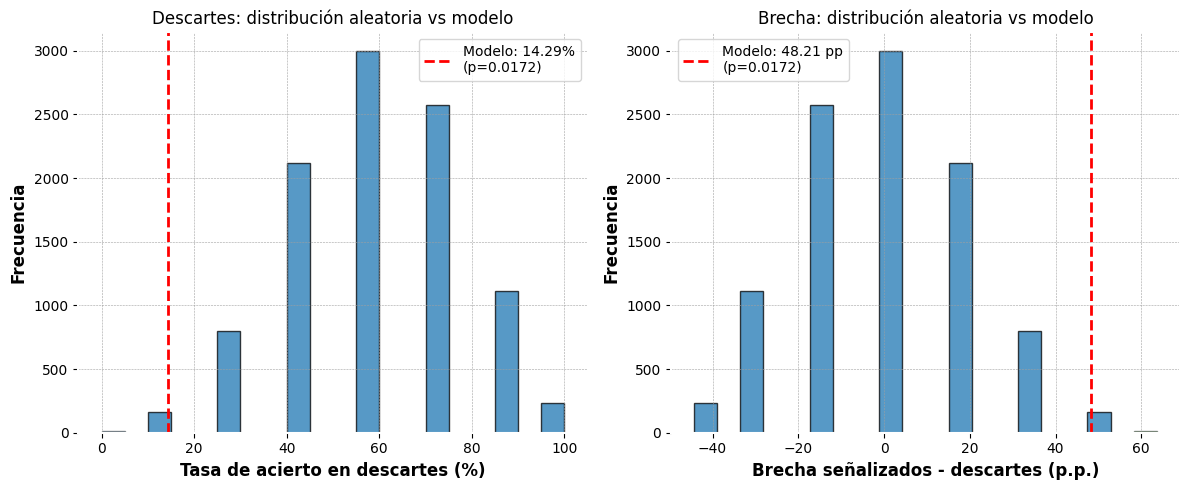

In [ ]:
# -----------------------------
# 3) Aleatorización restringida
# -----------------------------
n_iter = 10000
rng = np.random.default_rng(42)

idx = np.arange(n_total)          # indices posicionales dentro de dfv
y_arr = y.to_numpy()

rand_rate_disc  = np.empty(n_iter, dtype=float)  # proporciones
rand_gap        = np.empty(n_iter, dtype=float)  # proporciones (sig - disc)

for it in range(n_iter):
    disc_idx = rng.choice(idx, size=n_disc, replace=False)          # elegimos 'n_disc' eventos al azar
    sign_idx = np.setdiff1d(idx, disc_idx, assume_unique=False)     # resto quedan señalizados

    rate_disc = y_arr[disc_idx].mean()
    rate_sign = y_arr[sign_idx].mean()

    rand_rate_disc[it] = rate_disc
    rand_gap[it]       = (rate_sign - rate_disc)

# Versiones listas para graficar (en %)
discard_rates_random = rand_rate_disc.copy() * 100.0  # %
gaps_random          = rand_gap.copy() * 100.0        # %

# -----------------------------
# 4) P-values (one-sided)
# -----------------------------
p_discard_low = float(np.mean(rand_rate_disc <= rate_disc_obs))
p_gap_large   = float(np.mean(rand_gap >= gap_obs))

print("\n=== Test de Aleatorización (one-sided) ===")
print(f"p_discard_low (descartes aleatorios <= {rate_disc_obs:.2%}): {p_discard_low:.4f}")
print(f"p_gap_large  (brecha aleatoria >= {gap_obs:.2%})         : {p_gap_large:.4f}")

print("\nDistribución aleatoria (resumen):")
print(f"Tasa descartes (media ± sd): {rand_rate_disc.mean():.2%} ± {rand_rate_disc.std(ddof=1):.2%}")
print(f"Brecha (media ± sd)        : {rand_gap.mean():.2%} ± {rand_gap.std(ddof=1):.2%}")

# -----------------------------
# 5) Gráficos con sombreado de cola (usa las mismas distribuciones del test)
# -----------------------------
obs_disc_pct = rate_disc_obs * 100.0
obs_gap_pct  = gap_obs * 100.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- (a) Tasa de acierto en descartes ---
ax = axes[0]
counts, bins, patches = ax.hist(discard_rates_random, bins=20, alpha=0.75, edgecolor='k')
ax.axvline(obs_disc_pct, color='red', linestyle='--', linewidth=2,
           label=f"Modelo: {obs_disc_pct:.2f}%\n(p={p_discard_low:.4f})")
# Sombrear cola izquierda (<= observado)
for left, right, patch in zip(bins[:-1], bins[1:], patches):
    if right <= obs_disc_pct:
        patch.set_facecolor('tab:blue')
        patch.set_alpha(0.45)
ax.set_xlabel('Tasa de acierto en descartes (%)')
ax.set_ylabel('Frecuencia')
ax.set_title('Descartes: distribución aleatoria vs modelo')
ax.legend()

# --- (b) Brecha señalizados - descartes ---
ax = axes[1]
counts, bins, patches = ax.hist(gaps_random, bins=20, alpha=0.75, edgecolor='k')
ax.axvline(obs_gap_pct, color='red', linestyle='--', linewidth=2,
           label=f"Modelo: {obs_gap_pct:.2f} pp\n(p={p_gap_large:.4f})")
# Sombrear cola derecha (>= observado)
for left, right, patch in zip(bins[:-1], bins[1:], patches):
    if left >= obs_gap_pct:
        patch.set_facecolor('tab:green')
        patch.set_alpha(0.45)
ax.set_xlabel('Brecha señalizados - descartes (p.p.)')
ax.set_ylabel('Frecuencia')
ax.set_title('Brecha: distribución aleatoria vs modelo')
ax.legend()

plt.tight_layout()
plt.show()

# 9. Análisis Posterior

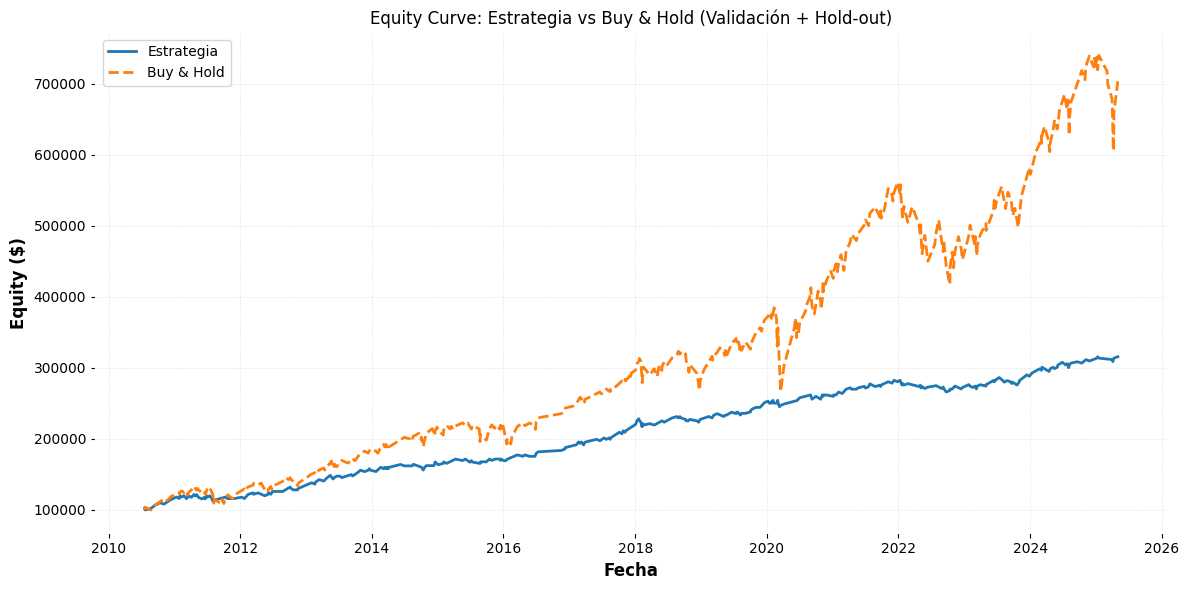

In [ ]:
# ============================================================
# Unir Validación (últimos 400 de df_train) + Hold-out y graficar
#   - Curva de equity comparativa con Buy & Hold
#   - Gráfico de eventos (círculos), descartados en rojo
# ============================================================

# -----------------------------
# 1) Preparar tramo de VALIDACIÓN (últimos 400 de df_train)
# -----------------------------
N_VAL = 400
cols_need = ['Fecha_Cierre','Precio_Cierre','SL','Señal']
missing_val = [c for c in cols_need if c not in df_train.columns]
if missing_val:
    raise KeyError(f"df_train no contiene columnas requeridas para validación: {missing_val}")

df_val = df_train.iloc[-N_VAL:].copy()
df_val = df_val[['Fecha_Cierre','Precio_Cierre','SL','Señal']].copy()
df_val.rename(columns={'Señal': 'Signal'}, inplace=True)
# Señales NaN -> 0
df_val['Signal'] = df_val['Signal'].fillna(0).astype(int)

# -----------------------------
# 2) Preparar tramo de HOLD-OUT
# -----------------------------
if 'df_holdout' in globals():
    df_ho = df_holdout.copy()
else:
    # Fallback: tomar desde df_combo a partir de start_hold = len(df_train_tail)
    if 'df_combo' not in globals() or 'df_train_tail' not in globals():
        raise NameError("No se encuentra df_holdout ni (df_combo + df_train_tail) para delimitar el hold-out.")
    start_hold = len(df_train_tail)
    df_ho = df_combo.loc[start_hold:].copy()

cols_need_ho = ['Fecha_Cierre','Precio_Cierre','SL','Señal_HO']
missing_ho = [c for c in cols_need_ho if c not in df_ho.columns]
if missing_ho:
    raise KeyError(f"Tramo hold-out no contiene columnas requeridas: {missing_ho}")

df_ho = df_ho[['Fecha_Cierre','Precio_Cierre','SL','Señal_HO']].copy()
df_ho.rename(columns={'Señal_HO': 'Signal'}, inplace=True)
df_ho['Signal'] = df_ho['Signal'].fillna(0).astype(int)

# -----------------------------
# 3) Concatenar VALIDACIÓN + HOLD-OUT (orden temporal)
# -----------------------------
df_all = pd.concat([df_val, df_ho], axis=0, ignore_index=True)
# Asegurar orden por fecha por si acaso
df_all['Fecha_Cierre'] = pd.to_datetime(df_all['Fecha_Cierre'])
df_all = df_all.sort_values('Fecha_Cierre').reset_index(drop=True)

# -----------------------------
# 4) Backtest de la estrategia combinada
# -----------------------------
df_bt_all = ejecutar_backtest(
    df_all.copy(),
    signal_col='Signal',
    capital_inicial=capital_inicial,
    riesgo_pct=riesgo_pct,
    spread=spread,
    comision_por_accion=comision_por_accion
)

# df_bt_all tiene len = len(df_all) - 1 (por el ExitPrice shift)
fechas_bt = pd.to_datetime(df_bt_all['Fecha_Cierre'])
equity_strat = df_bt_all['Equity'].values

# -----------------------------
# 5) Curva Buy & Hold en el mismo período
# -----------------------------
# Usamos el precio de cierre del df_all (mismo muestreo/eventos)
precios_all = df_all['Precio_Cierre'].values
# Para alinear con df_bt_all (que pierde la última fila), cortamos a len-1
precios_for_bh = precios_all[:-1]
equity_bh = capital_inicial * (precios_for_bh / precios_for_bh[0])

# -----------------------------
# 6) Plot 1: Curva de Equity — Estrategia vs Buy & Hold
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(fechas_bt, equity_strat, label='Estrategia', linewidth=2)
plt.plot(fechas_bt, equity_bh, label='Buy & Hold', linestyle='--')
plt.title('Equity Curve: Estrategia vs Buy & Hold (Validación + Hold-out)')
plt.xlabel('Fecha')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()